<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/LSTM/LSTM_Electric_Power_Consumption_Forecasting_Student_ID_21072112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [1]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [3]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

Date      Time Global_active_power Global_reactive_power  \
0        16/12/2006  17:24:00               4.216                 0.418   
1        16/12/2006  17:25:00               5.360                 0.436   
2        16/12/2006  17:26:00               5.374                 0.498   
3        16/12/2006  17:27:00               5.388                 0.502   
4        16/12/2006  17:28:00               3.666                 0.528   
...             ...       ...                 ...                   ...   
2075254  26/11/2010  20:58:00               0.946                   0.0   
2075255  26/11/2010  20:59:00               0.944                   0.0   
2075256  26/11/2010  21:00:00               0.938                   0.0   
2075257  26/11/2010  21:01:00               0.934                   0.0   
2075258  26/11/2010  21:02:00               0.932                   0.0   

         Voltage Global_intensity Sub_metering_1 Sub_metering_2  \
0        234.840           18.400          0.000          1.000   
1        233.630           23.000          0.000          1.000   
2        233.290           23.000          0.000          2.000   
3        233.740           23.000          0.000          1.000   
4        235.680           15.800          0.000          1.000   
...          ...              ...            ...            ...   
2075254   240.43              4.0            0.0            0.0   
2075255    240.0              4.0            0.0            0.0   
2075256   239.82              3.8            0.0            0.0   
2075257    239.7              3.8            0.0            0.0   
2075258   239.55              3.8            0.0            0.0   

         Sub_metering_3  
0                  17.0  
1                  16.0  
2                  17.0  
3                  17.0  
4                  17.0  
...                 ...  
2075254             0.0  
2075255             0.0  
2075256             0.0  
2075257             0.0  
2075258             0.0  

[2075259 rows x 9 columns]

In [4]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [5]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [6]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [7]:
# Check Missing Values
df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [8]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Copy the original DataFrame into a new DataFrame
df_copy = df.copy()
df_copy

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
date_time                            
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0  
...                             ...  
2010-11-26 20:58:00             0.0  
2010-11-26 20:59:00             0.0  
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0  

[2075259 rows x 7 columns]

# Data Imputation

In [9]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [10]:
# Apply MICE imputer
imputer = IterativeImputer(random_state=0)
df_imputed = imputer.fit_transform(df)

# Convert back to DataFrame
df_imputed = pd.DataFrame(df_imputed, index=df.index, columns=df.columns)

# Fill NaN values using the mean for each column
#df_imputed = df.copy()
#df_imputed.fillna(df.mean(), inplace=True)

# Save the DataFrame to an Excel file
df_imputed.to_csv('df_imputed.csv')

In [11]:
# Check Missing Values after imputation
df_imputed.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [12]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df_imputed['Global_active_power']*1000/60)
equation2 = df_imputed['Sub_metering_1'] + df_imputed['Sub_metering_2'] + df_imputed['Sub_metering_3']
df_imputed['Sub_metering_4'] = equation1 - equation2
df_imputed

Global_active_power  Global_reactive_power  Voltage  \
date_time                                                                  
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
date_time                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   
...                               ...             ...             ...   
2010-11-26 20:58:00               4.0             0.0             0.0   
2010-11-26 20:59:00               4.0             0.0             0.0   
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  Sub_metering_4  
date_time                                            
2006-12-16 17:24:00            17.0       52.266667  
2006-12-16 17:25:00            16.0       72.333333  
2006-12-16 17:26:00            17.0       70.566667  
2006-12-16 17:27:00            17.0       71.800000  
2006-12-16 17:28:00            17.0       43.100000  
...                             ...             ...  
2010-11-26 20:58:00             0.0       15.766667  
2010-11-26 20:59:00             0.0       15.733333  
2010-11-26 21:00:00             0.0       15.633333  
2010-11-26 21:01:00             0.0       15.566667  
2010-11-26 21:02:00             0.0       15.533333  

[2075259 rows x 8 columns]

In [13]:
# Resampled the data
hourly_resampled = df_imputed.resample('H').mean()

# Save DataFrame to a CSV file
hourly_resampled.to_csv('hourly_resampled.csv')

# EDA

In [14]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(df, resample_type, title):

  # Resample the data
  df_resampled = df.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))
  print('\n')

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(25,20))
  plt.suptitle("Visualization of %s Resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ Distribution Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ Correlation Plot for %s Resampled Data **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm', fmt='.2f')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(200)
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 




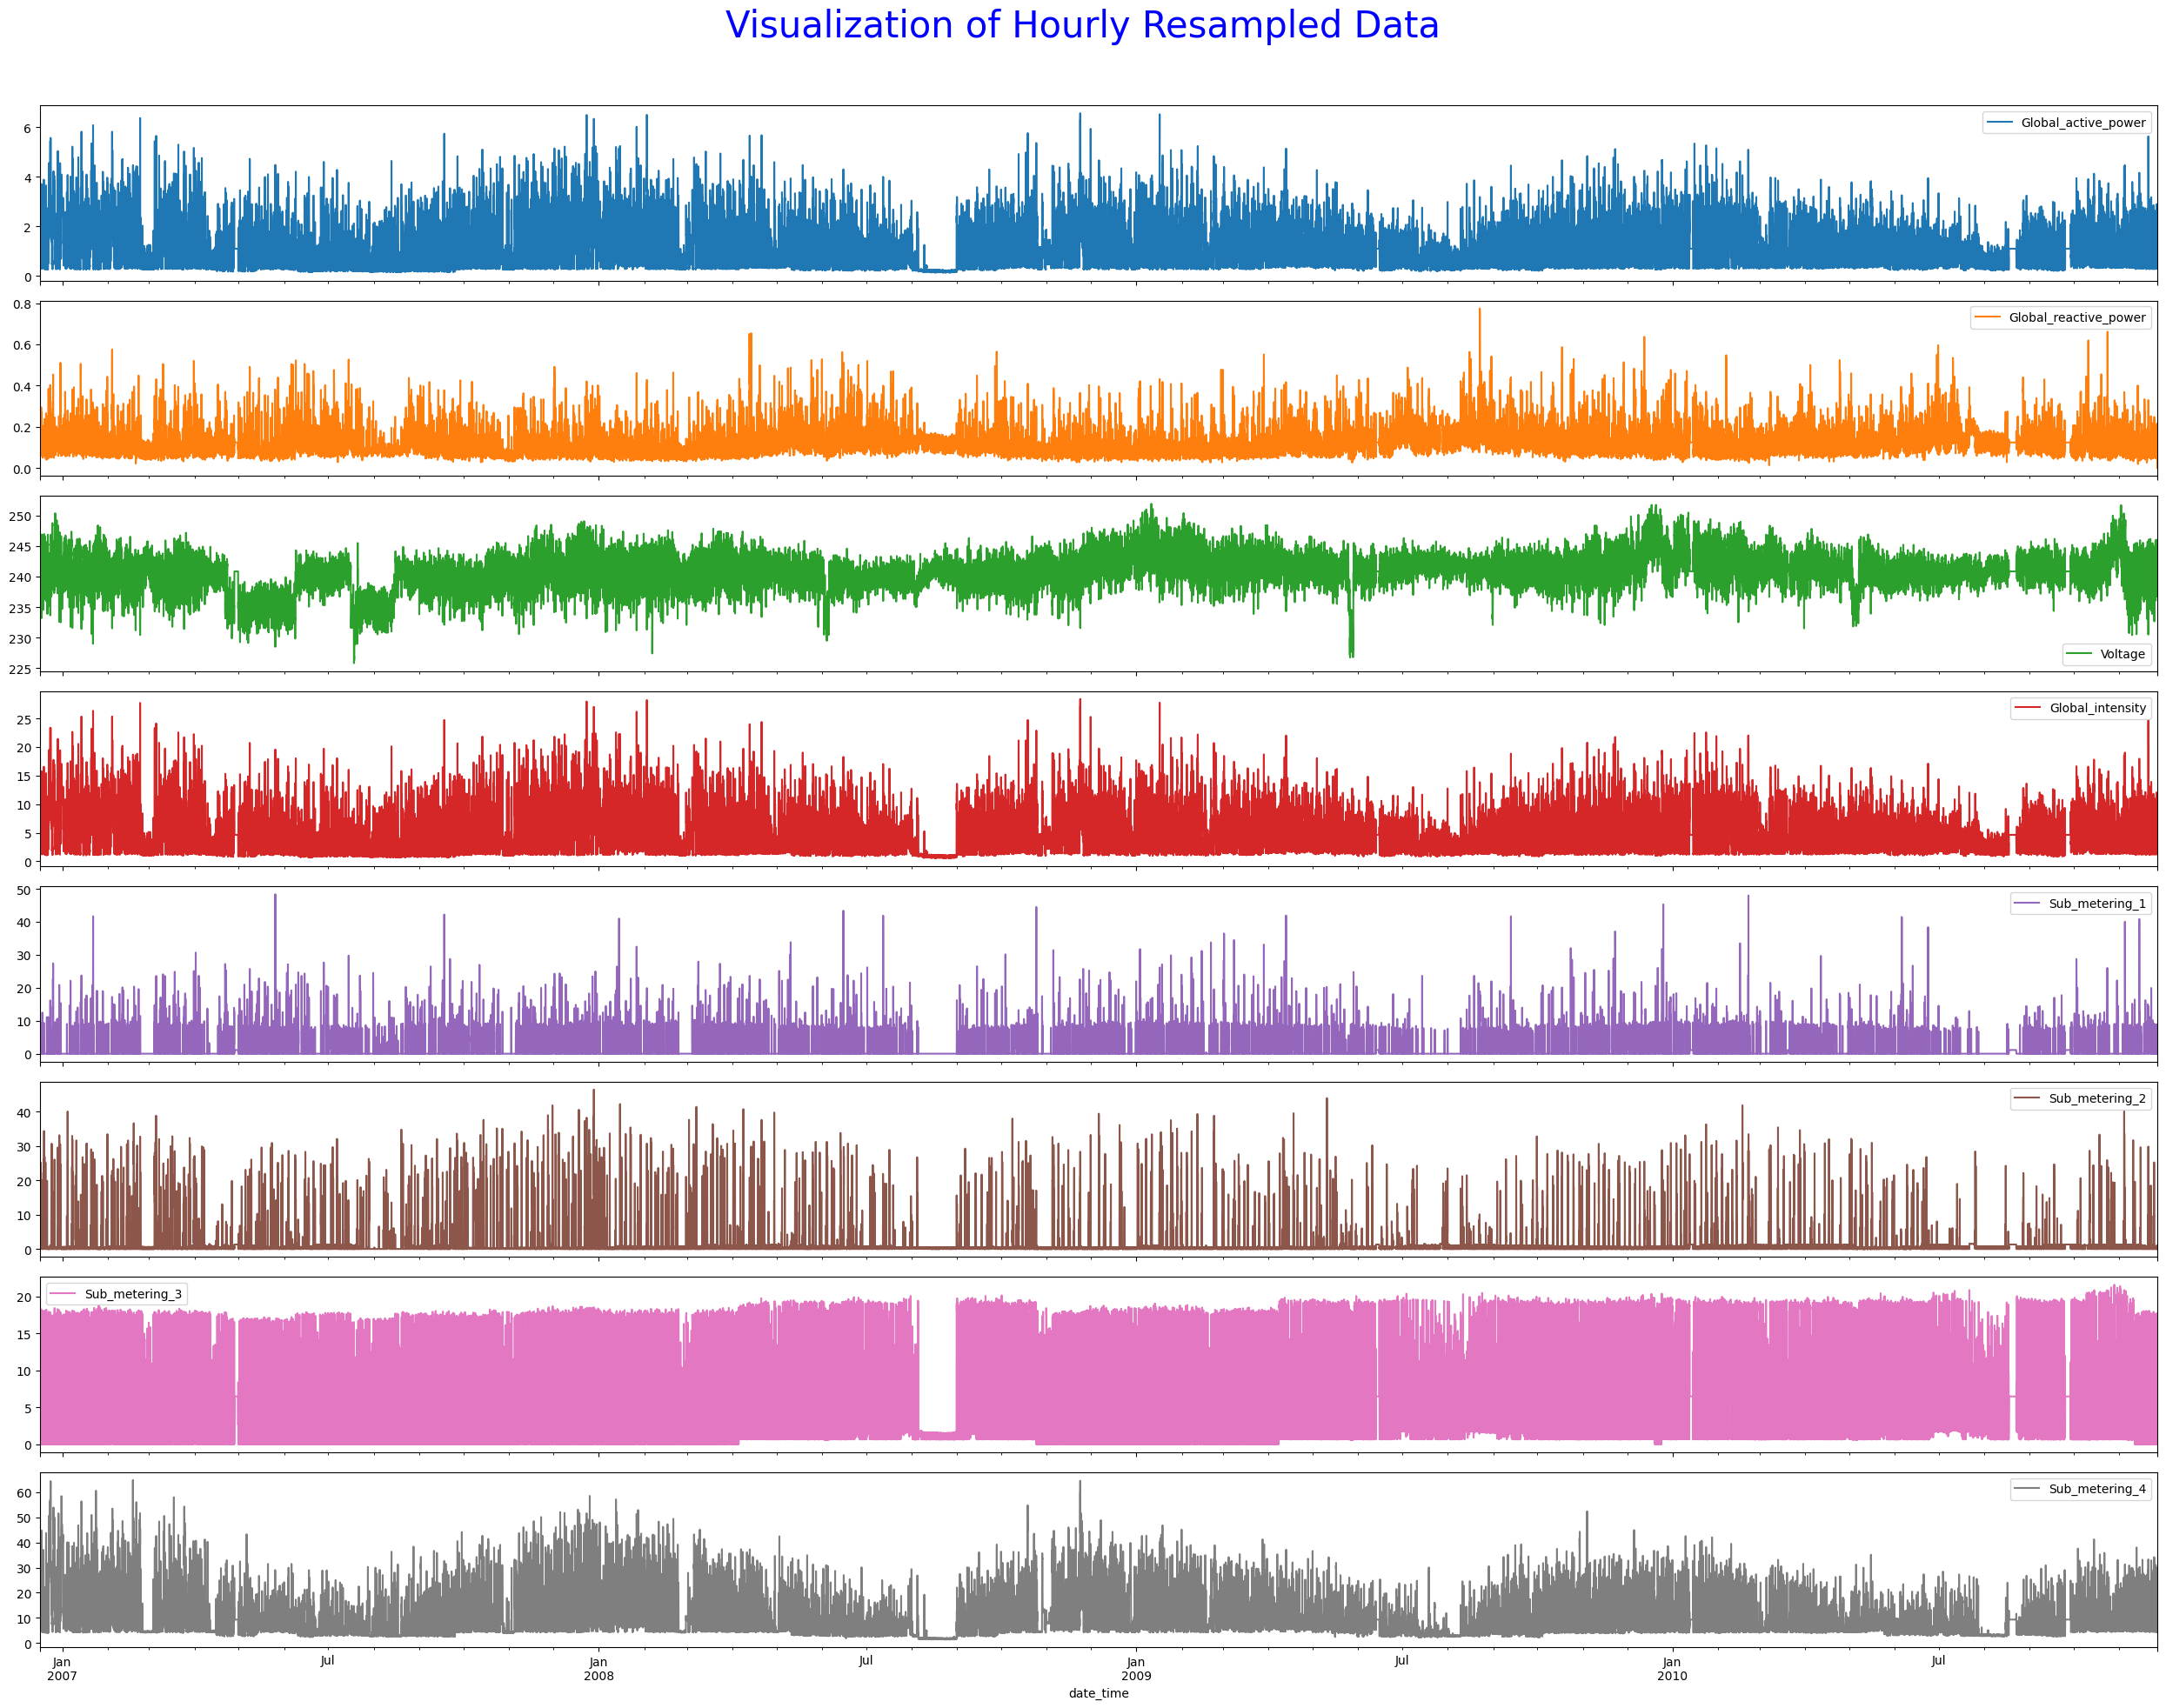

 

************************************************ Distribution Plot for Hourly Resampled Data **************************************************



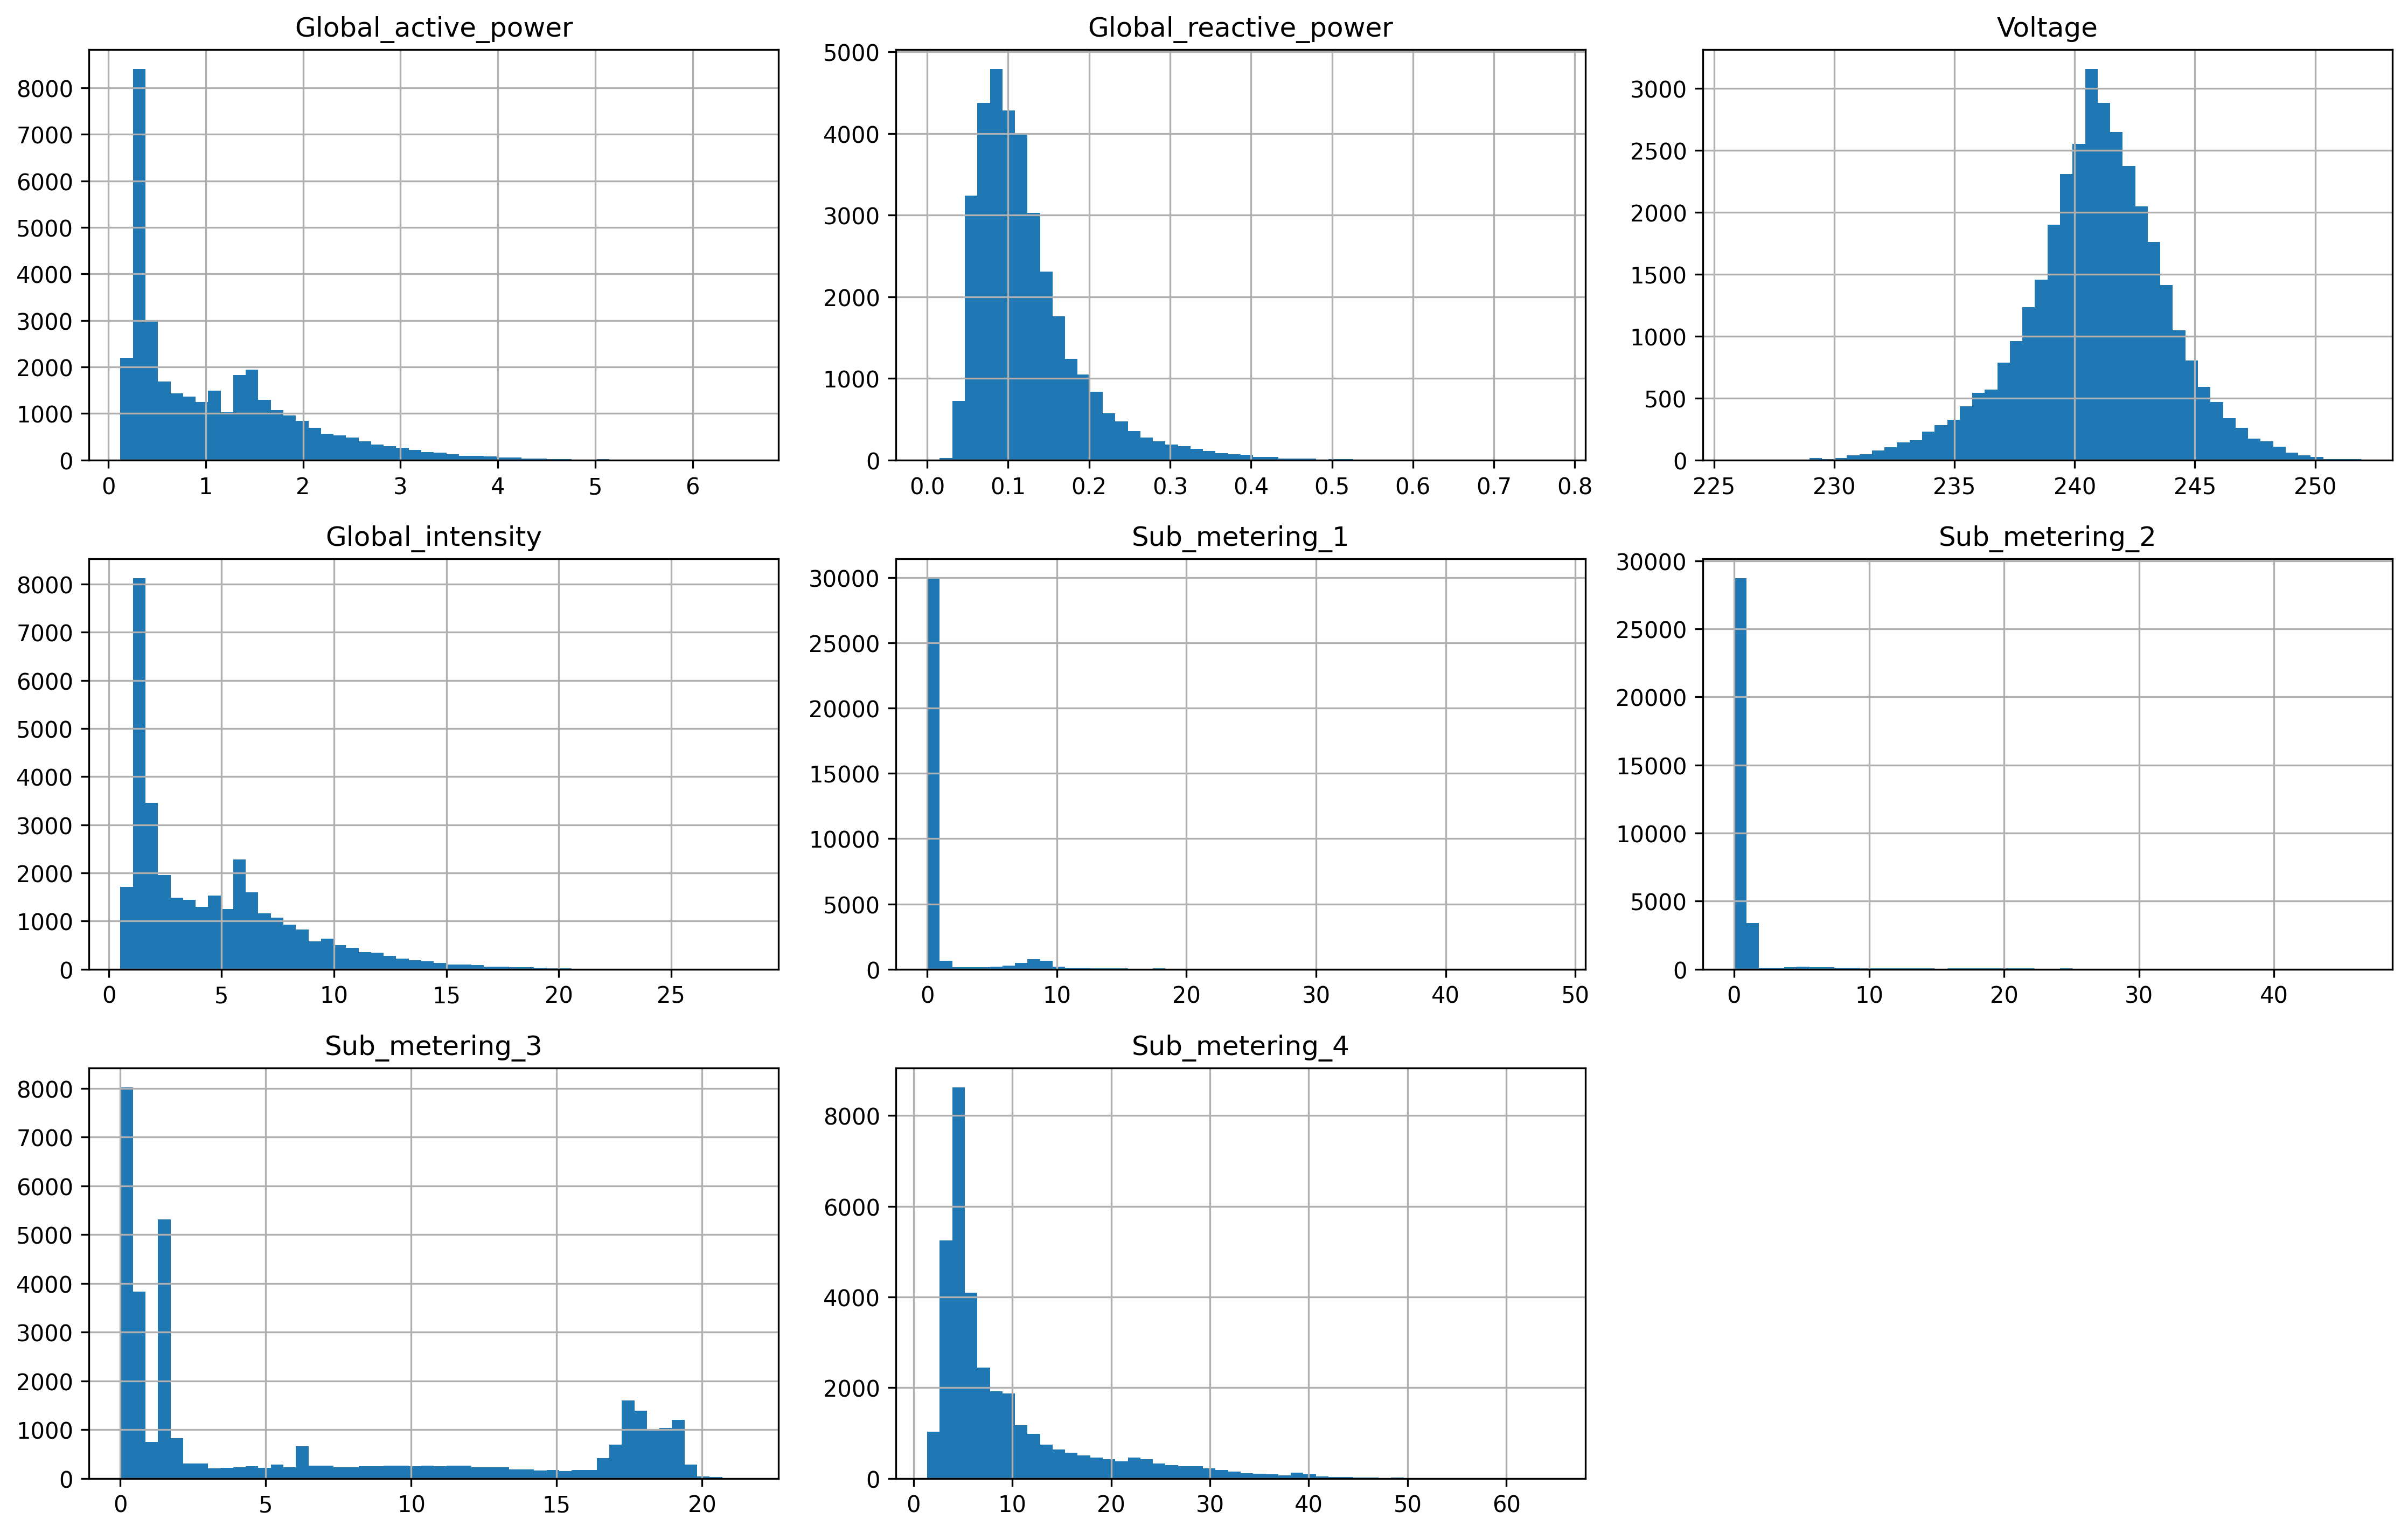

 

************************************************ Correlation Plot for Hourly Resampled Data **************************************************



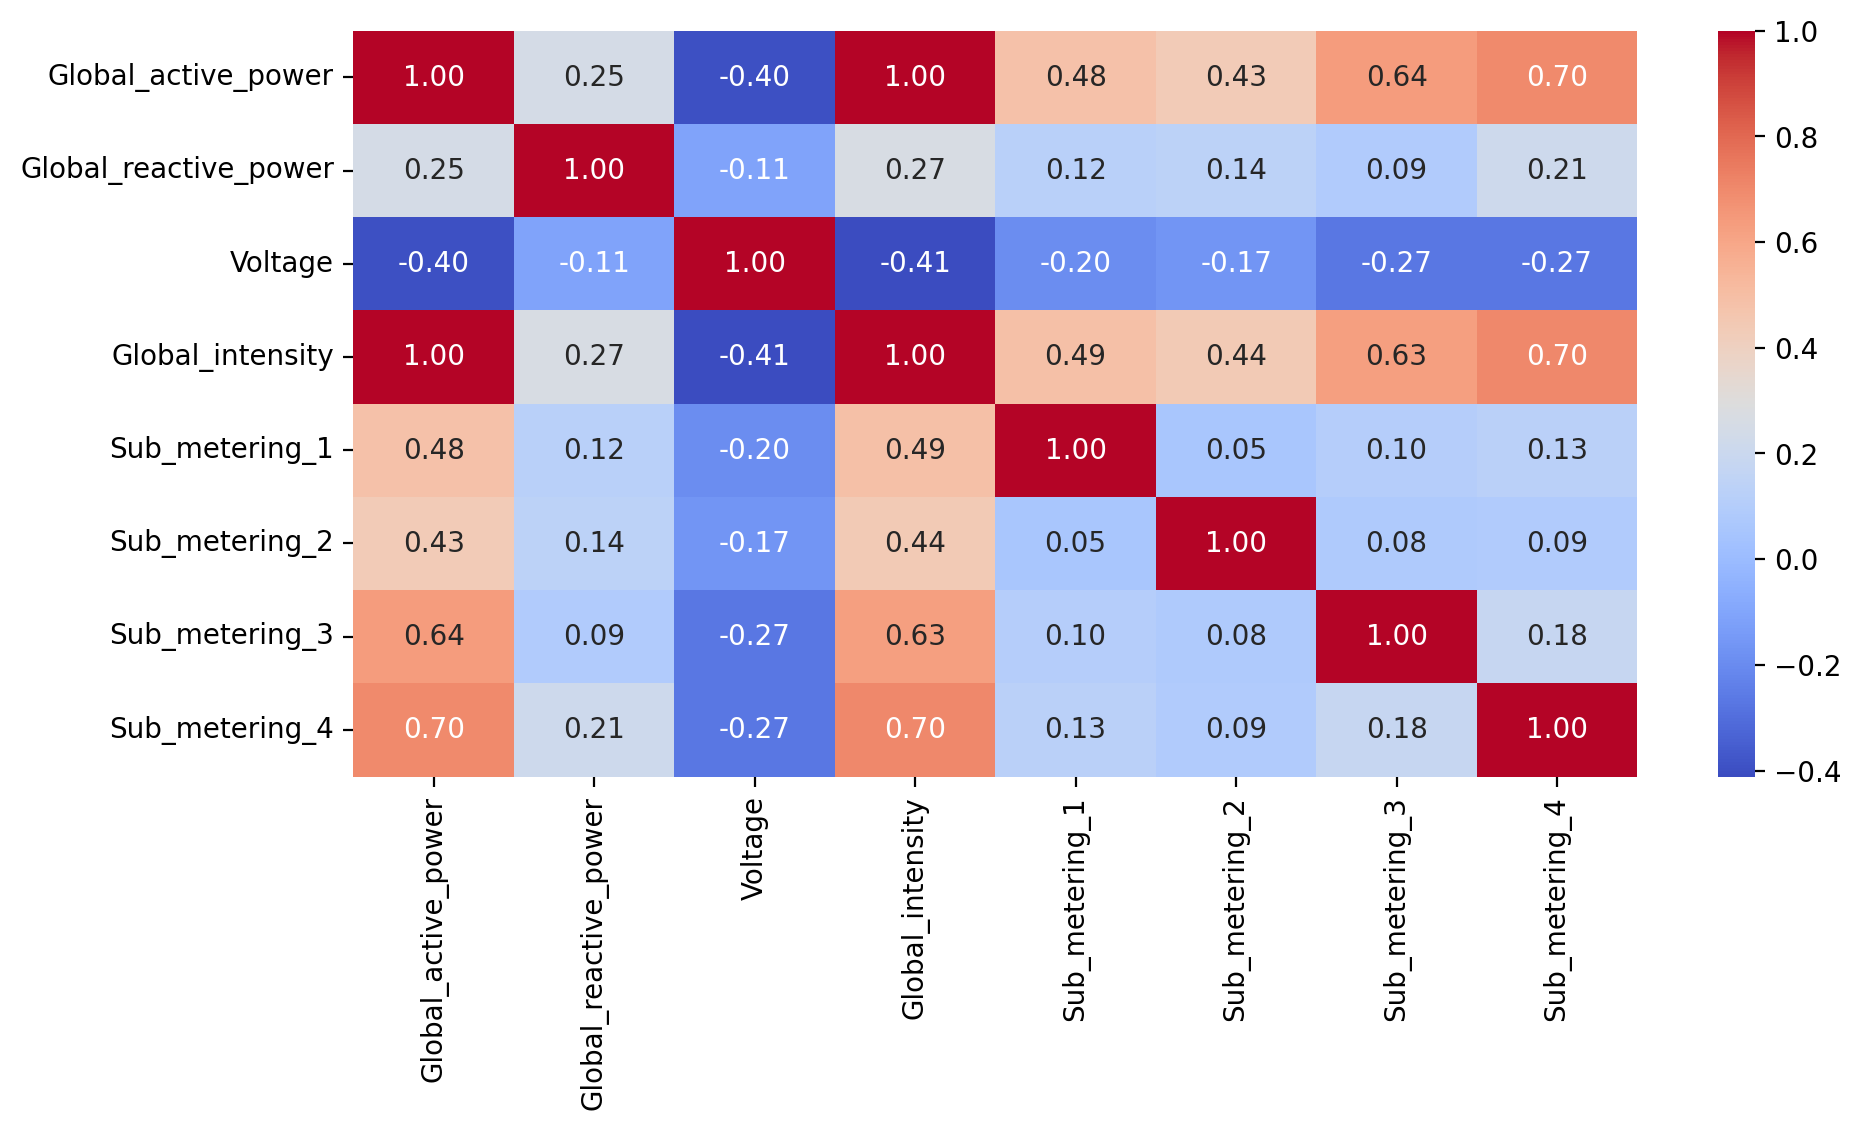

In [15]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df_imputed, "H", "Hourly")

Note:- As Global_intensity and Sub_metering_4 are highly correlated with Global_active_power so I am removing Global_intensity column

In [16]:
df1 = hourly_resampled.drop(['Global_intensity', 'Sub_metering_4'], axis=1)
#df1 = df1.Global_active_power
#df1 = pd.DataFrame(df1)
df1

Global_active_power  Global_reactive_power     Voltage  \
date_time                                                                     
2006-12-16 17:00:00             4.222889               0.229000  234.643889   
2006-12-16 18:00:00             3.632200               0.080033  234.580167   
2006-12-16 19:00:00             3.400233               0.085233  233.232500   
2006-12-16 20:00:00             3.268567               0.075100  234.071500   
2006-12-16 21:00:00             3.056467               0.076667  237.158667   
...                                  ...                    ...         ...   
2010-11-26 17:00:00             1.725900               0.061400  237.069667   
2010-11-26 18:00:00             1.573467               0.053700  237.531833   
2010-11-26 19:00:00             1.659333               0.060033  236.741000   
2010-11-26 20:00:00             1.163700               0.061167  239.396000   
2010-11-26 21:00:00             0.934667               0.000000  239.690000   

                     Sub_metering_1  Sub_metering_2  Sub_metering_3  
date_time                                                            
2006-12-16 17:00:00             0.0        0.527778       16.861111  
2006-12-16 18:00:00             0.0        6.716667       16.866667  
2006-12-16 19:00:00             0.0        1.433333       16.683333  
2006-12-16 20:00:00             0.0        0.000000       16.783333  
2006-12-16 21:00:00             0.0        0.416667       17.216667  
...                             ...             ...             ...  
2010-11-26 17:00:00             0.0        0.000000       12.866667  
2010-11-26 18:00:00             0.0        0.000000        0.000000  
2010-11-26 19:00:00             0.0        0.066667        0.000000  
2010-11-26 20:00:00             0.0        1.066667        0.000000  
2010-11-26 21:00:00             0.0        0.000000        0.000000  

[34589 rows x 6 columns]

# Feature Engineering

In [17]:
# Create new columns for hour, day, quarter, month, and year
#df1['hour'] = hourly_resampled.index.hour
#df1['month'] = hourly_resampled.index.month
#df1['quarter'] = hourly_resampled.index.quarter
#df1['year'] = hourly_resampled.index.year
#df1['week_of_year'] = hourly_resampled.index.isocalendar().week
#df1['day_of_week'] = hourly_resampled.index.dayofweek
#df1['day_of_month'] = hourly_resampled.index.day
#df1['day_of_year'] = hourly_resampled.index.dayofyear
#df1

# Data Normalization

In [18]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df1)

# See the scaled data
scaled_df

array([[0.63681623, 0.29573827, 0.33794529, 0.        , 0.01136636,
        0.78241815],
       [0.54504495, 0.10335773, 0.33550078, 0.        , 0.14465183,
        0.78267595],
       [0.50900588, 0.11007318, 0.28380167, 0.        , 0.03086863,
        0.7741686 ],
       ...,
       [0.2385342 , 0.07752906, 0.41839455, 0.        , 0.00143575,
        0.        ],
       [0.16153105, 0.07899268, 0.52024552, 0.        , 0.022972  ,
        0.        ],
       [0.12594772, 0.        , 0.53152393, 0.        , 0.        ,
        0.        ]])

# LSTM model-1 Adam(learning_rate=0.0001, epochs=20, batch_size=32)

(27661, 12, 6) (27661,) (6916, 12, 6) (6916,)
Epoch 1/20
865/865 - 16s - 18ms/step - loss: 0.0195 - val_loss: 0.0115
Epoch 2/20
865/865 - 9s - 10ms/step - loss: 0.0143 - val_loss: 0.0101
Epoch 3/20
865/865 - 10s - 12ms/step - loss: 0.0126 - val_loss: 0.0093
Epoch 4/20
865/865 - 12s - 14ms/step - loss: 0.0118 - val_loss: 0.0088
Epoch 5/20
865/865 - 9s - 10ms/step - loss: 0.0113 - val_loss: 0.0085
Epoch 6/20
865/865 - 10s - 12ms/step - loss: 0.0109 - val_loss: 0.0083
Epoch 7/20
865/865 - 13s - 15ms/step - loss: 0.0105 - val_loss: 0.0082
Epoch 8/20
865/865 - 17s - 20ms/step - loss: 0.0103 - val_loss: 0.0081
Epoch 9/20
865/865 - 10s - 12ms/step - loss: 0.0101 - val_loss: 0.0083
Epoch 10/20
865/865 - 8s - 9ms/step - loss: 0.0099 - val_loss: 0.0082
Epoch 11/20
865/865 - 12s - 14ms/step - loss: 0.0098 - val_loss: 0.0079
Epoch 12/20
865/865 - 10s - 12ms/step - loss: 0.0097 - val_loss: 0.0079
Epoch 13/20
865/865 - 8s - 9ms/step - loss: 0.0096 - val_loss: 0.0078
Epoch 14/20
865/865 - 12s - 14ms/

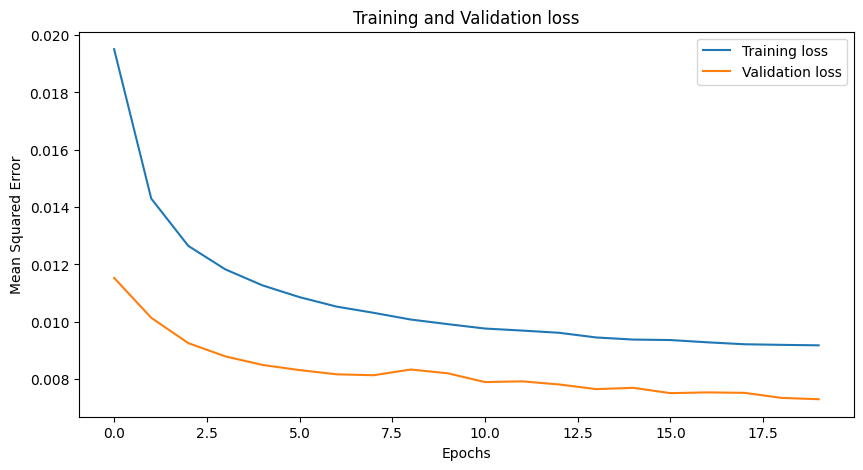

865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Train MAE: 0.482
Train MSE: 0.391
Train RMSE: 0.625
Train R² score: 0.546

Test MAE: 0.435
Test MSE: 0.302
Test RMSE: 0.550
Test R² score: 0.423


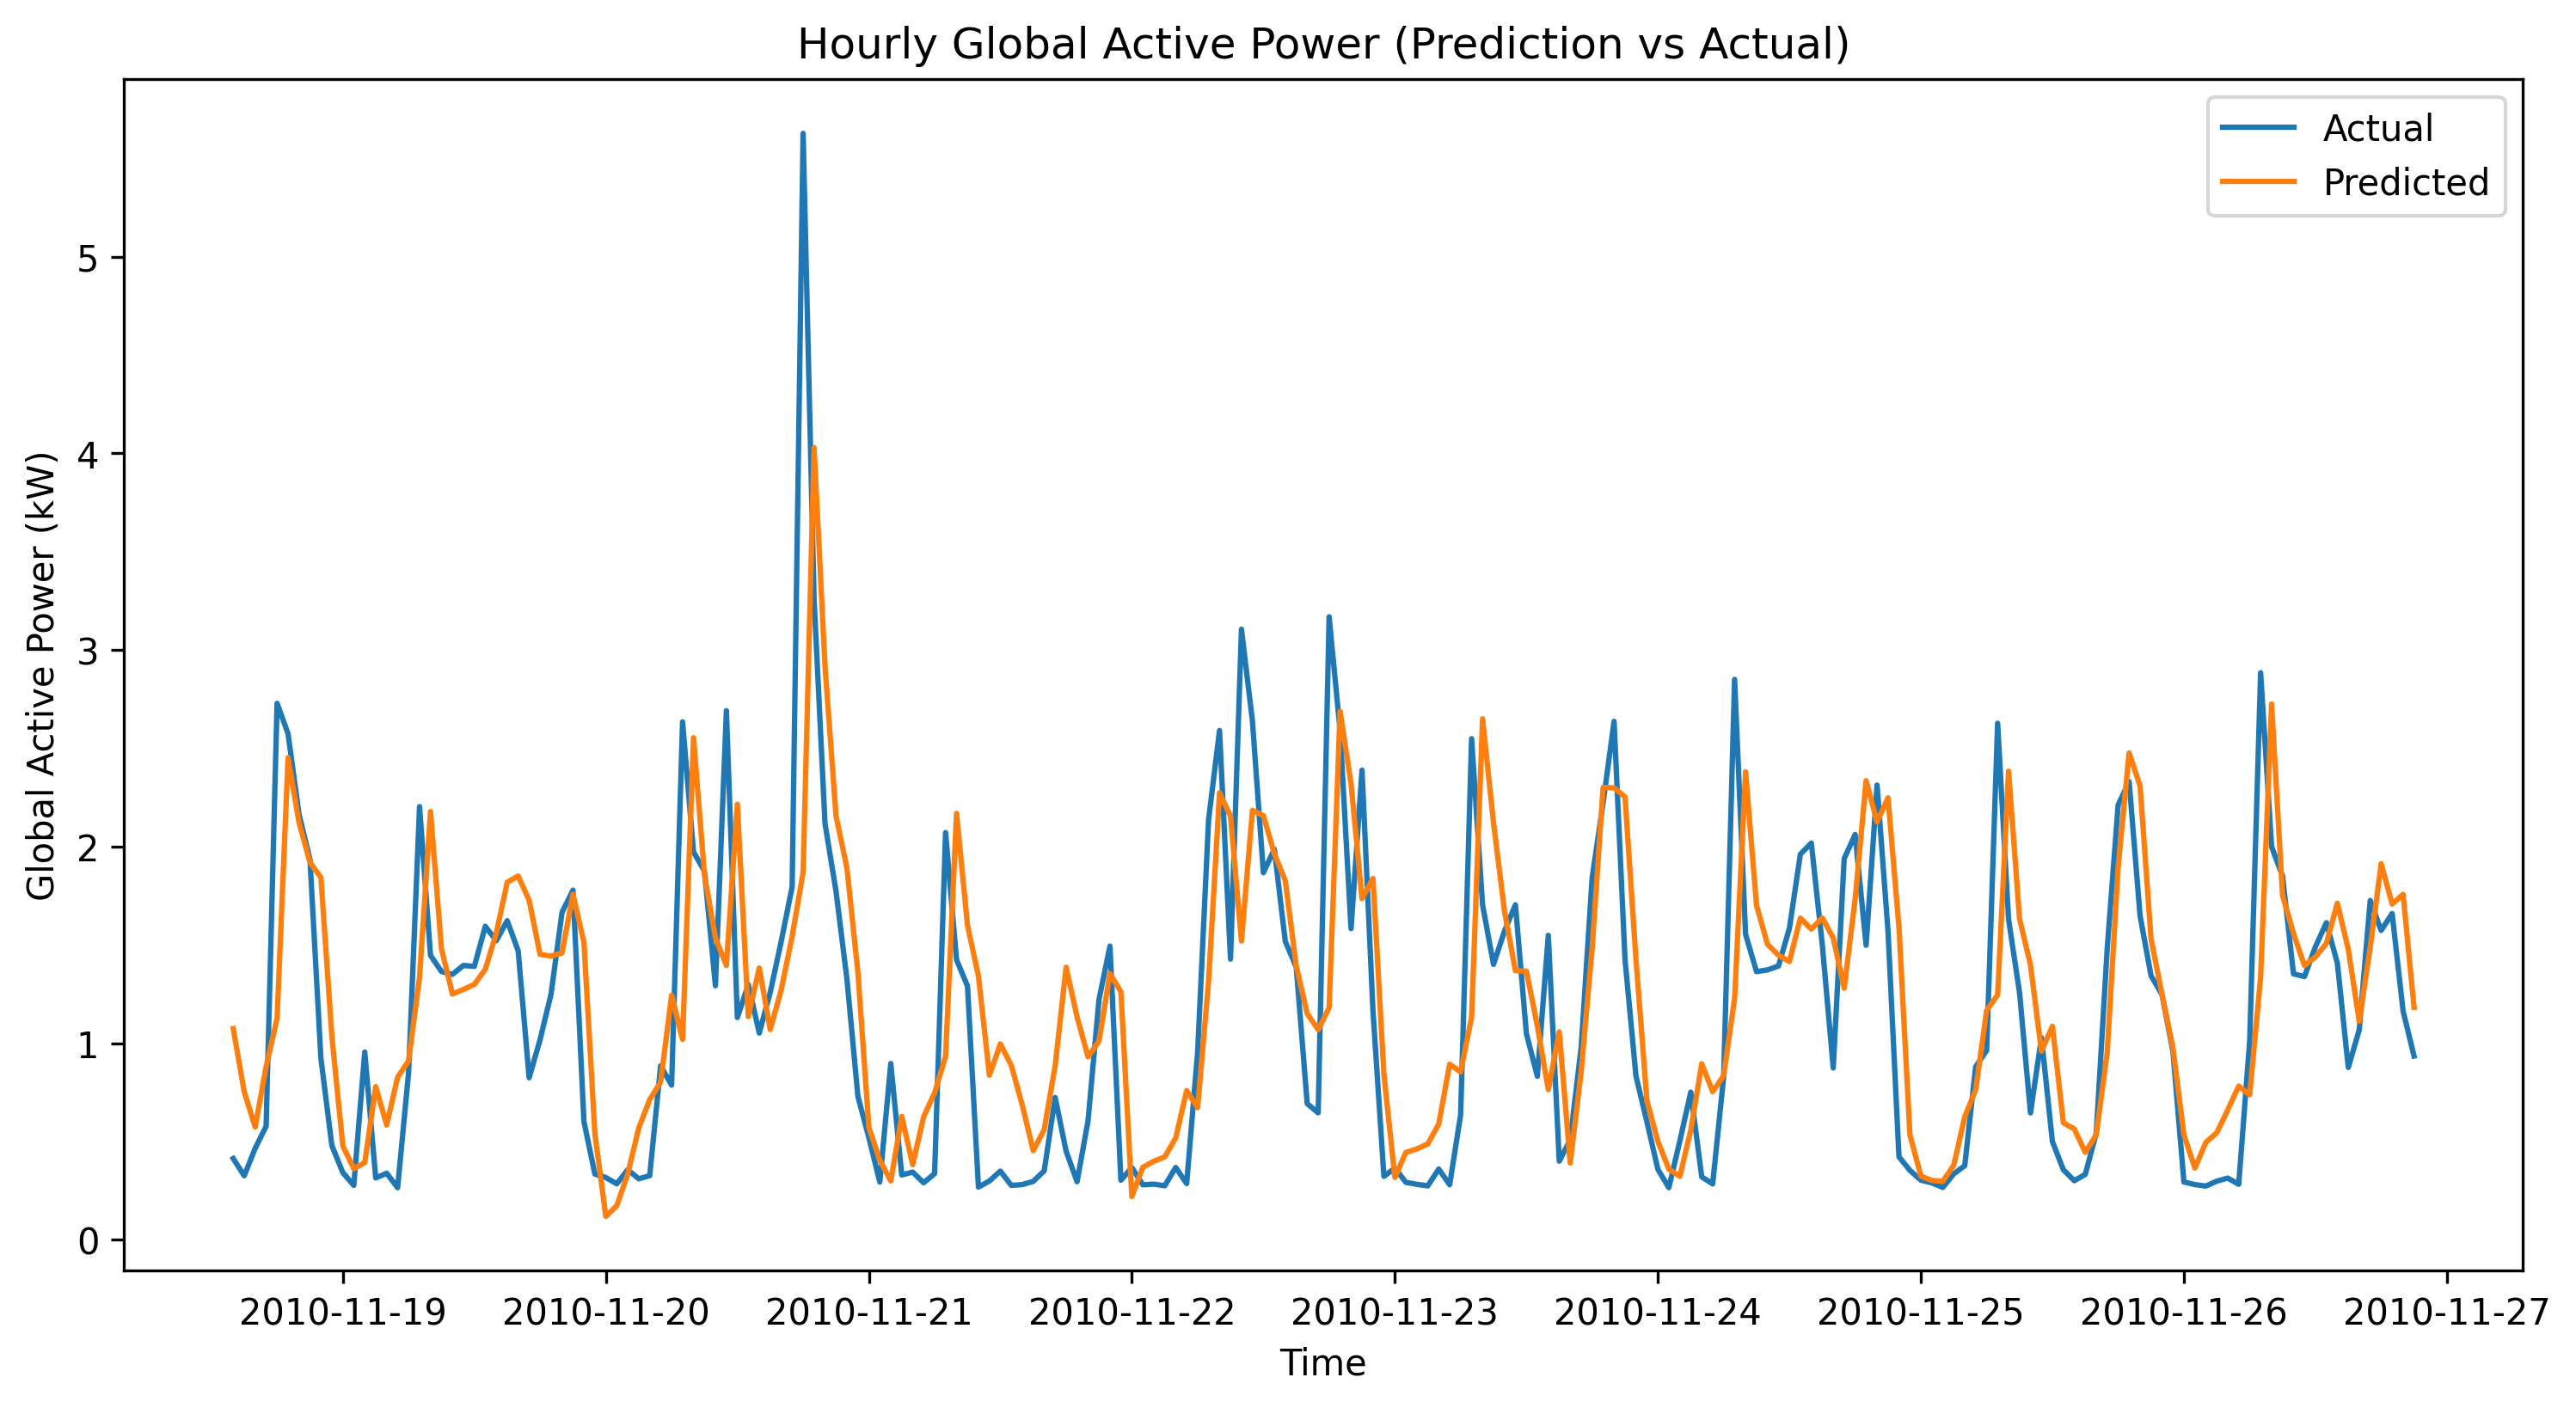

In [19]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-2 Adam(learning_rate=0.0001, epochs=30, batch_size=64)

Epoch 1/30
433/433 - 10s - 24ms/step - loss: 0.0201 - val_loss: 0.0102
Epoch 2/30
433/433 - 13s - 30ms/step - loss: 0.0157 - val_loss: 0.0094
Epoch 3/30
433/433 - 7s - 17ms/step - loss: 0.0140 - val_loss: 0.0087
Epoch 4/30
433/433 - 9s - 21ms/step - loss: 0.0128 - val_loss: 0.0083
Epoch 5/30
433/433 - 7s - 17ms/step - loss: 0.0123 - val_loss: 0.0080
Epoch 6/30
433/433 - 10s - 22ms/step - loss: 0.0117 - val_loss: 0.0080
Epoch 7/30
433/433 - 13s - 30ms/step - loss: 0.0115 - val_loss: 0.0078
Epoch 8/30
433/433 - 9s - 20ms/step - loss: 0.0112 - val_loss: 0.0077
Epoch 9/30
433/433 - 9s - 20ms/step - loss: 0.0110 - val_loss: 0.0076
Epoch 10/30
433/433 - 11s - 25ms/step - loss: 0.0107 - val_loss: 0.0075
Epoch 11/30
433/433 - 8s - 18ms/step - loss: 0.0106 - val_loss: 0.0075
Epoch 12/30
433/433 - 10s - 23ms/step - loss: 0.0104 - val_loss: 0.0074
Epoch 13/30
433/433 - 7s - 16ms/step - loss: 0.0102 - val_loss: 0.0074
Epoch 14/30
433/433 - 10s - 23ms/step - loss: 0.0102 - val_loss: 0.0074
Epoch 15

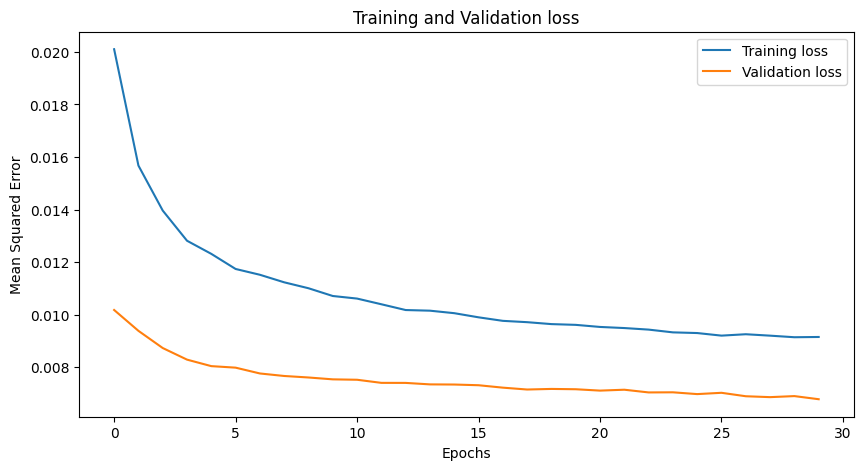

865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Train MAE: 0.459
Train MSE: 0.371
Train RMSE: 0.609
Train R² score: 0.569

Test MAE: 0.409
Test MSE: 0.281
Test RMSE: 0.530
Test R² score: 0.463


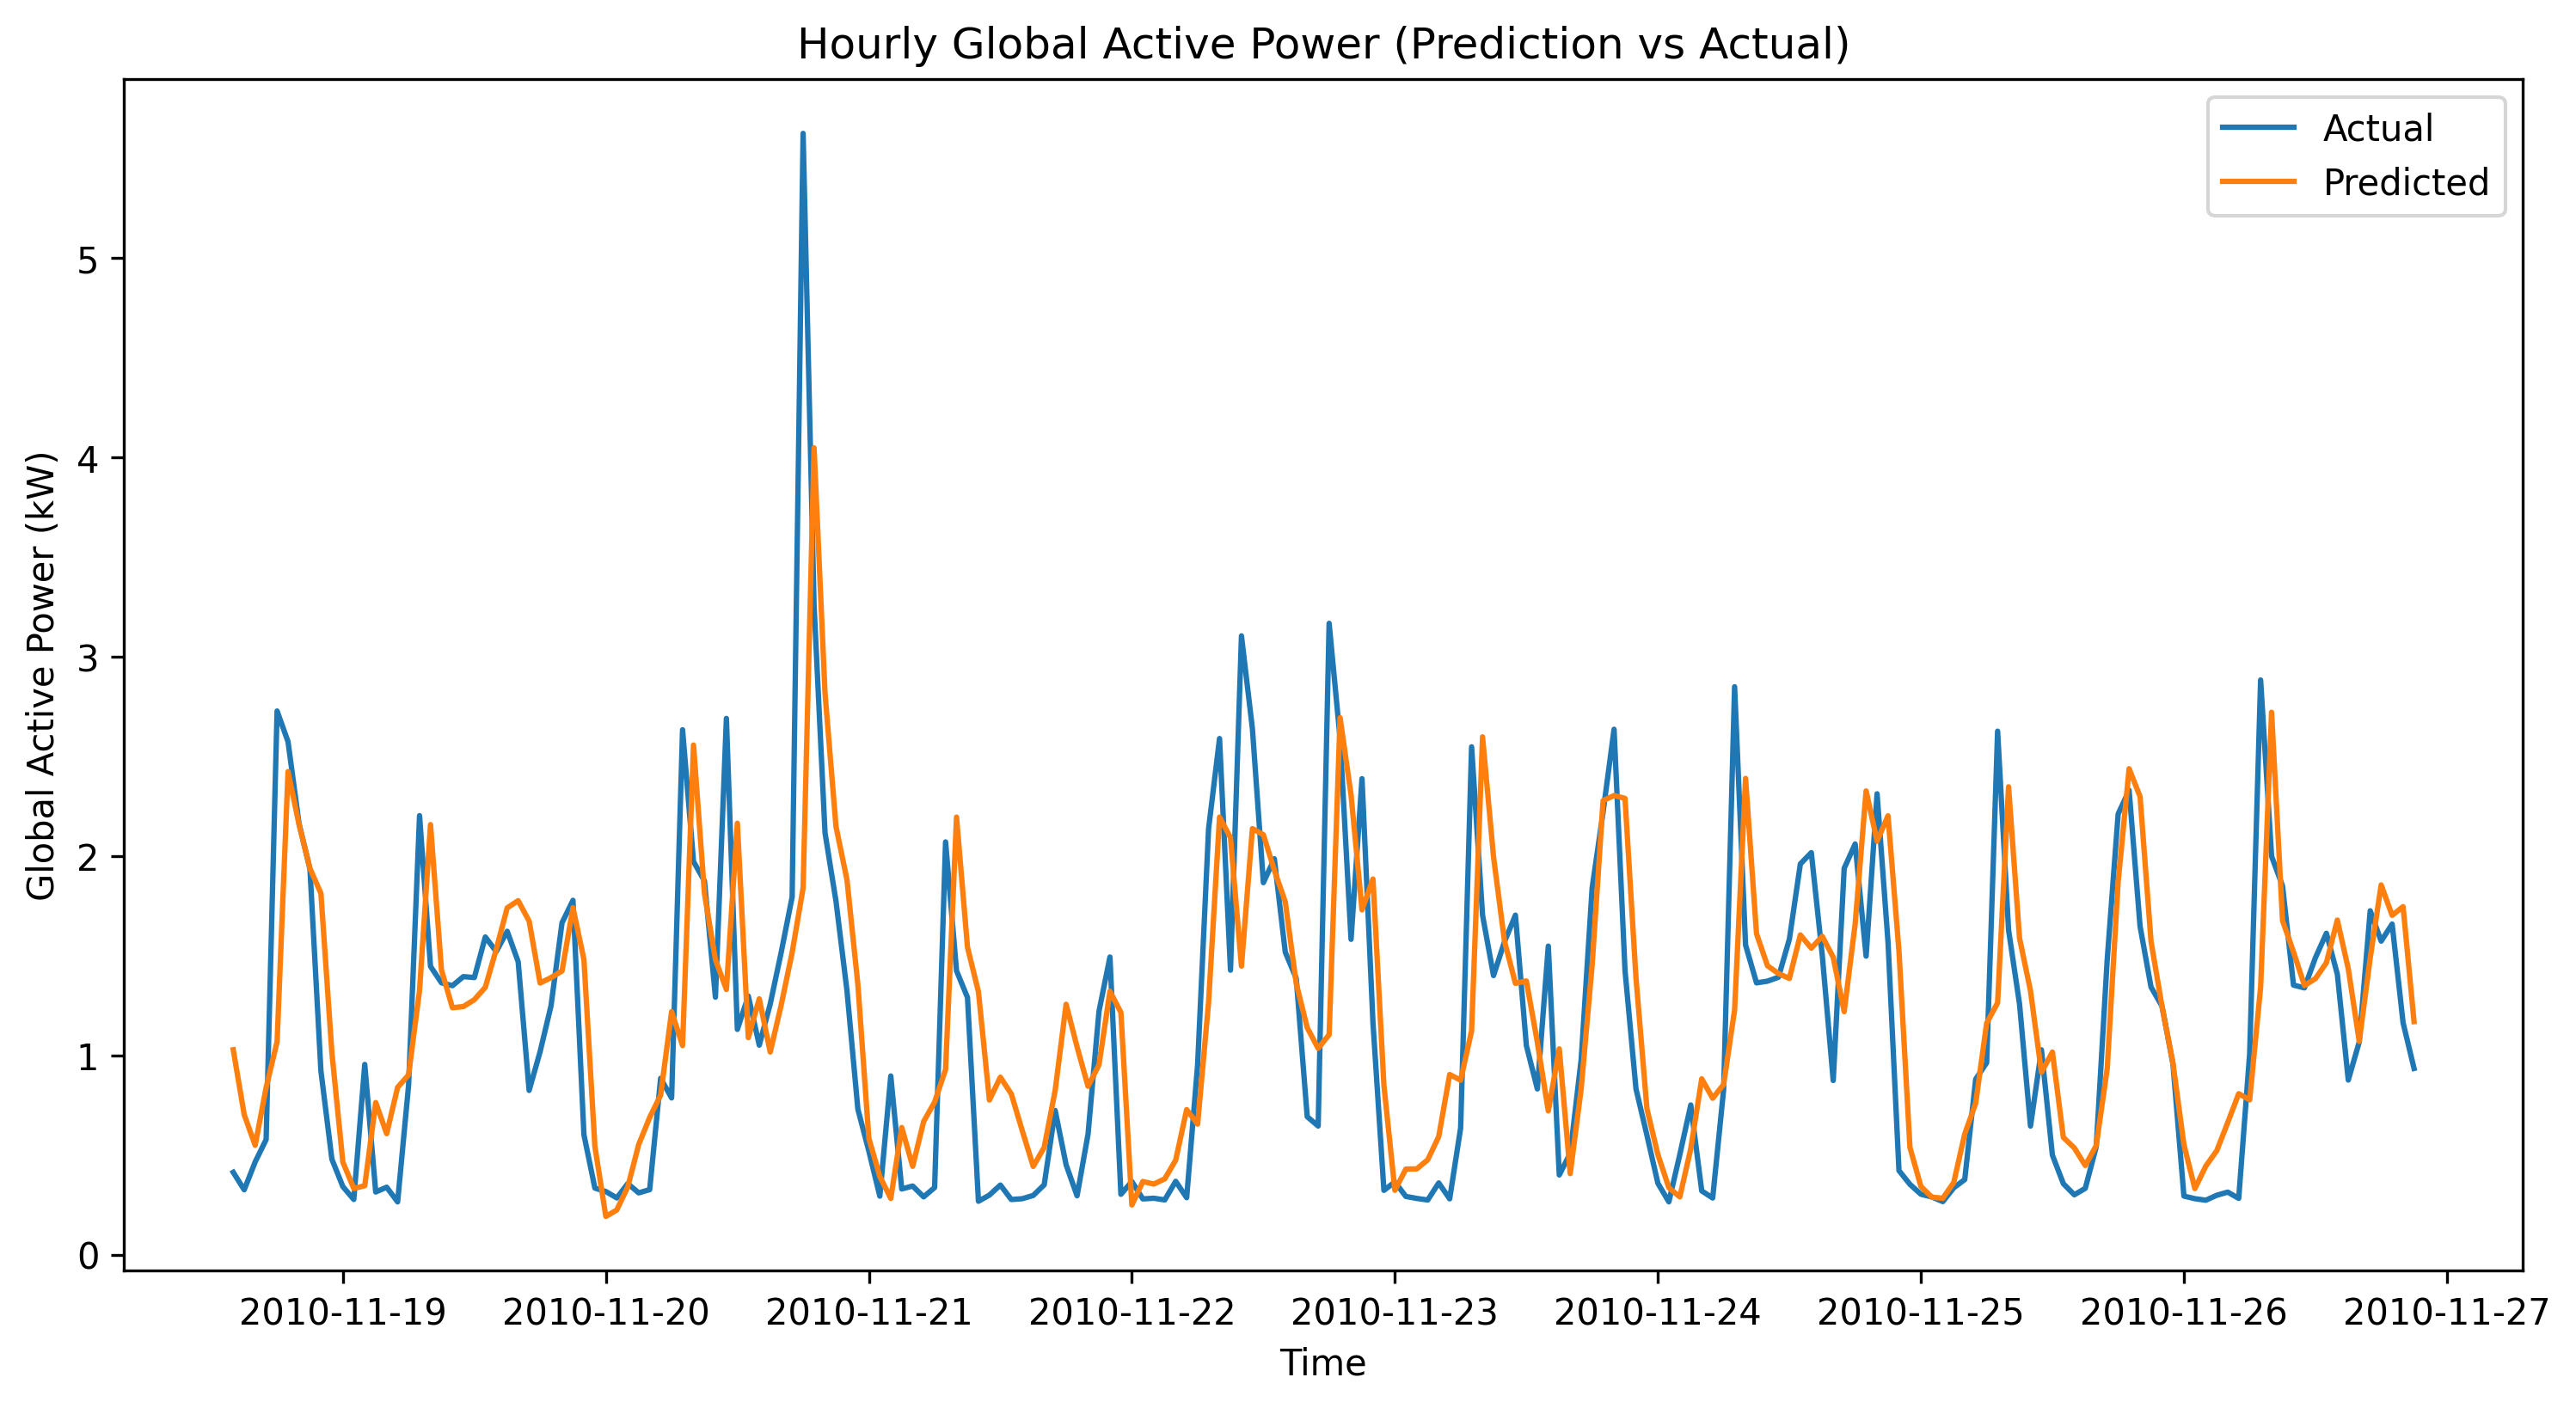

In [20]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-3 Adam(learning_rate=0.0001, epochs=50, batch_size=128)

Epoch 1/50
217/217 - 8s - 35ms/step - loss: 0.0232 - val_loss: 0.0114
Epoch 2/50
217/217 - 6s - 29ms/step - loss: 0.0192 - val_loss: 0.0104
Epoch 3/50
217/217 - 7s - 33ms/step - loss: 0.0172 - val_loss: 0.0095
Epoch 4/50
217/217 - 5s - 24ms/step - loss: 0.0158 - val_loss: 0.0092
Epoch 5/50
217/217 - 10s - 47ms/step - loss: 0.0147 - val_loss: 0.0089
Epoch 6/50
217/217 - 13s - 61ms/step - loss: 0.0141 - val_loss: 0.0086
Epoch 7/50
217/217 - 7s - 34ms/step - loss: 0.0136 - val_loss: 0.0084
Epoch 8/50
217/217 - 10s - 47ms/step - loss: 0.0132 - val_loss: 0.0082
Epoch 9/50
217/217 - 6s - 29ms/step - loss: 0.0130 - val_loss: 0.0081
Epoch 10/50
217/217 - 9s - 42ms/step - loss: 0.0126 - val_loss: 0.0080
Epoch 11/50
217/217 - 7s - 34ms/step - loss: 0.0124 - val_loss: 0.0079
Epoch 12/50
217/217 - 6s - 26ms/step - loss: 0.0121 - val_loss: 0.0078
Epoch 13/50
217/217 - 13s - 58ms/step - loss: 0.0120 - val_loss: 0.0077
Epoch 14/50
217/217 - 5s - 24ms/step - loss: 0.0117 - val_loss: 0.0077
Epoch 15/50

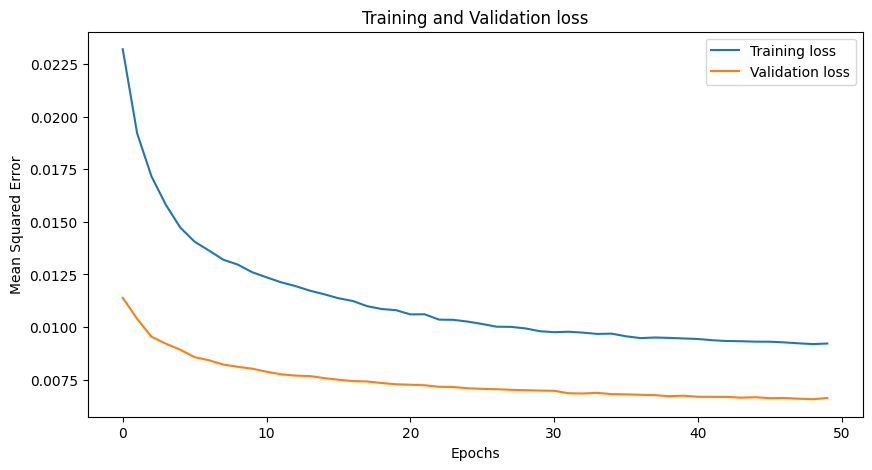

865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Train MAE: 0.447
Train MSE: 0.363
Train RMSE: 0.603
Train R² score: 0.578

Test MAE: 0.400
Test MSE: 0.275
Test RMSE: 0.524
Test R² score: 0.475


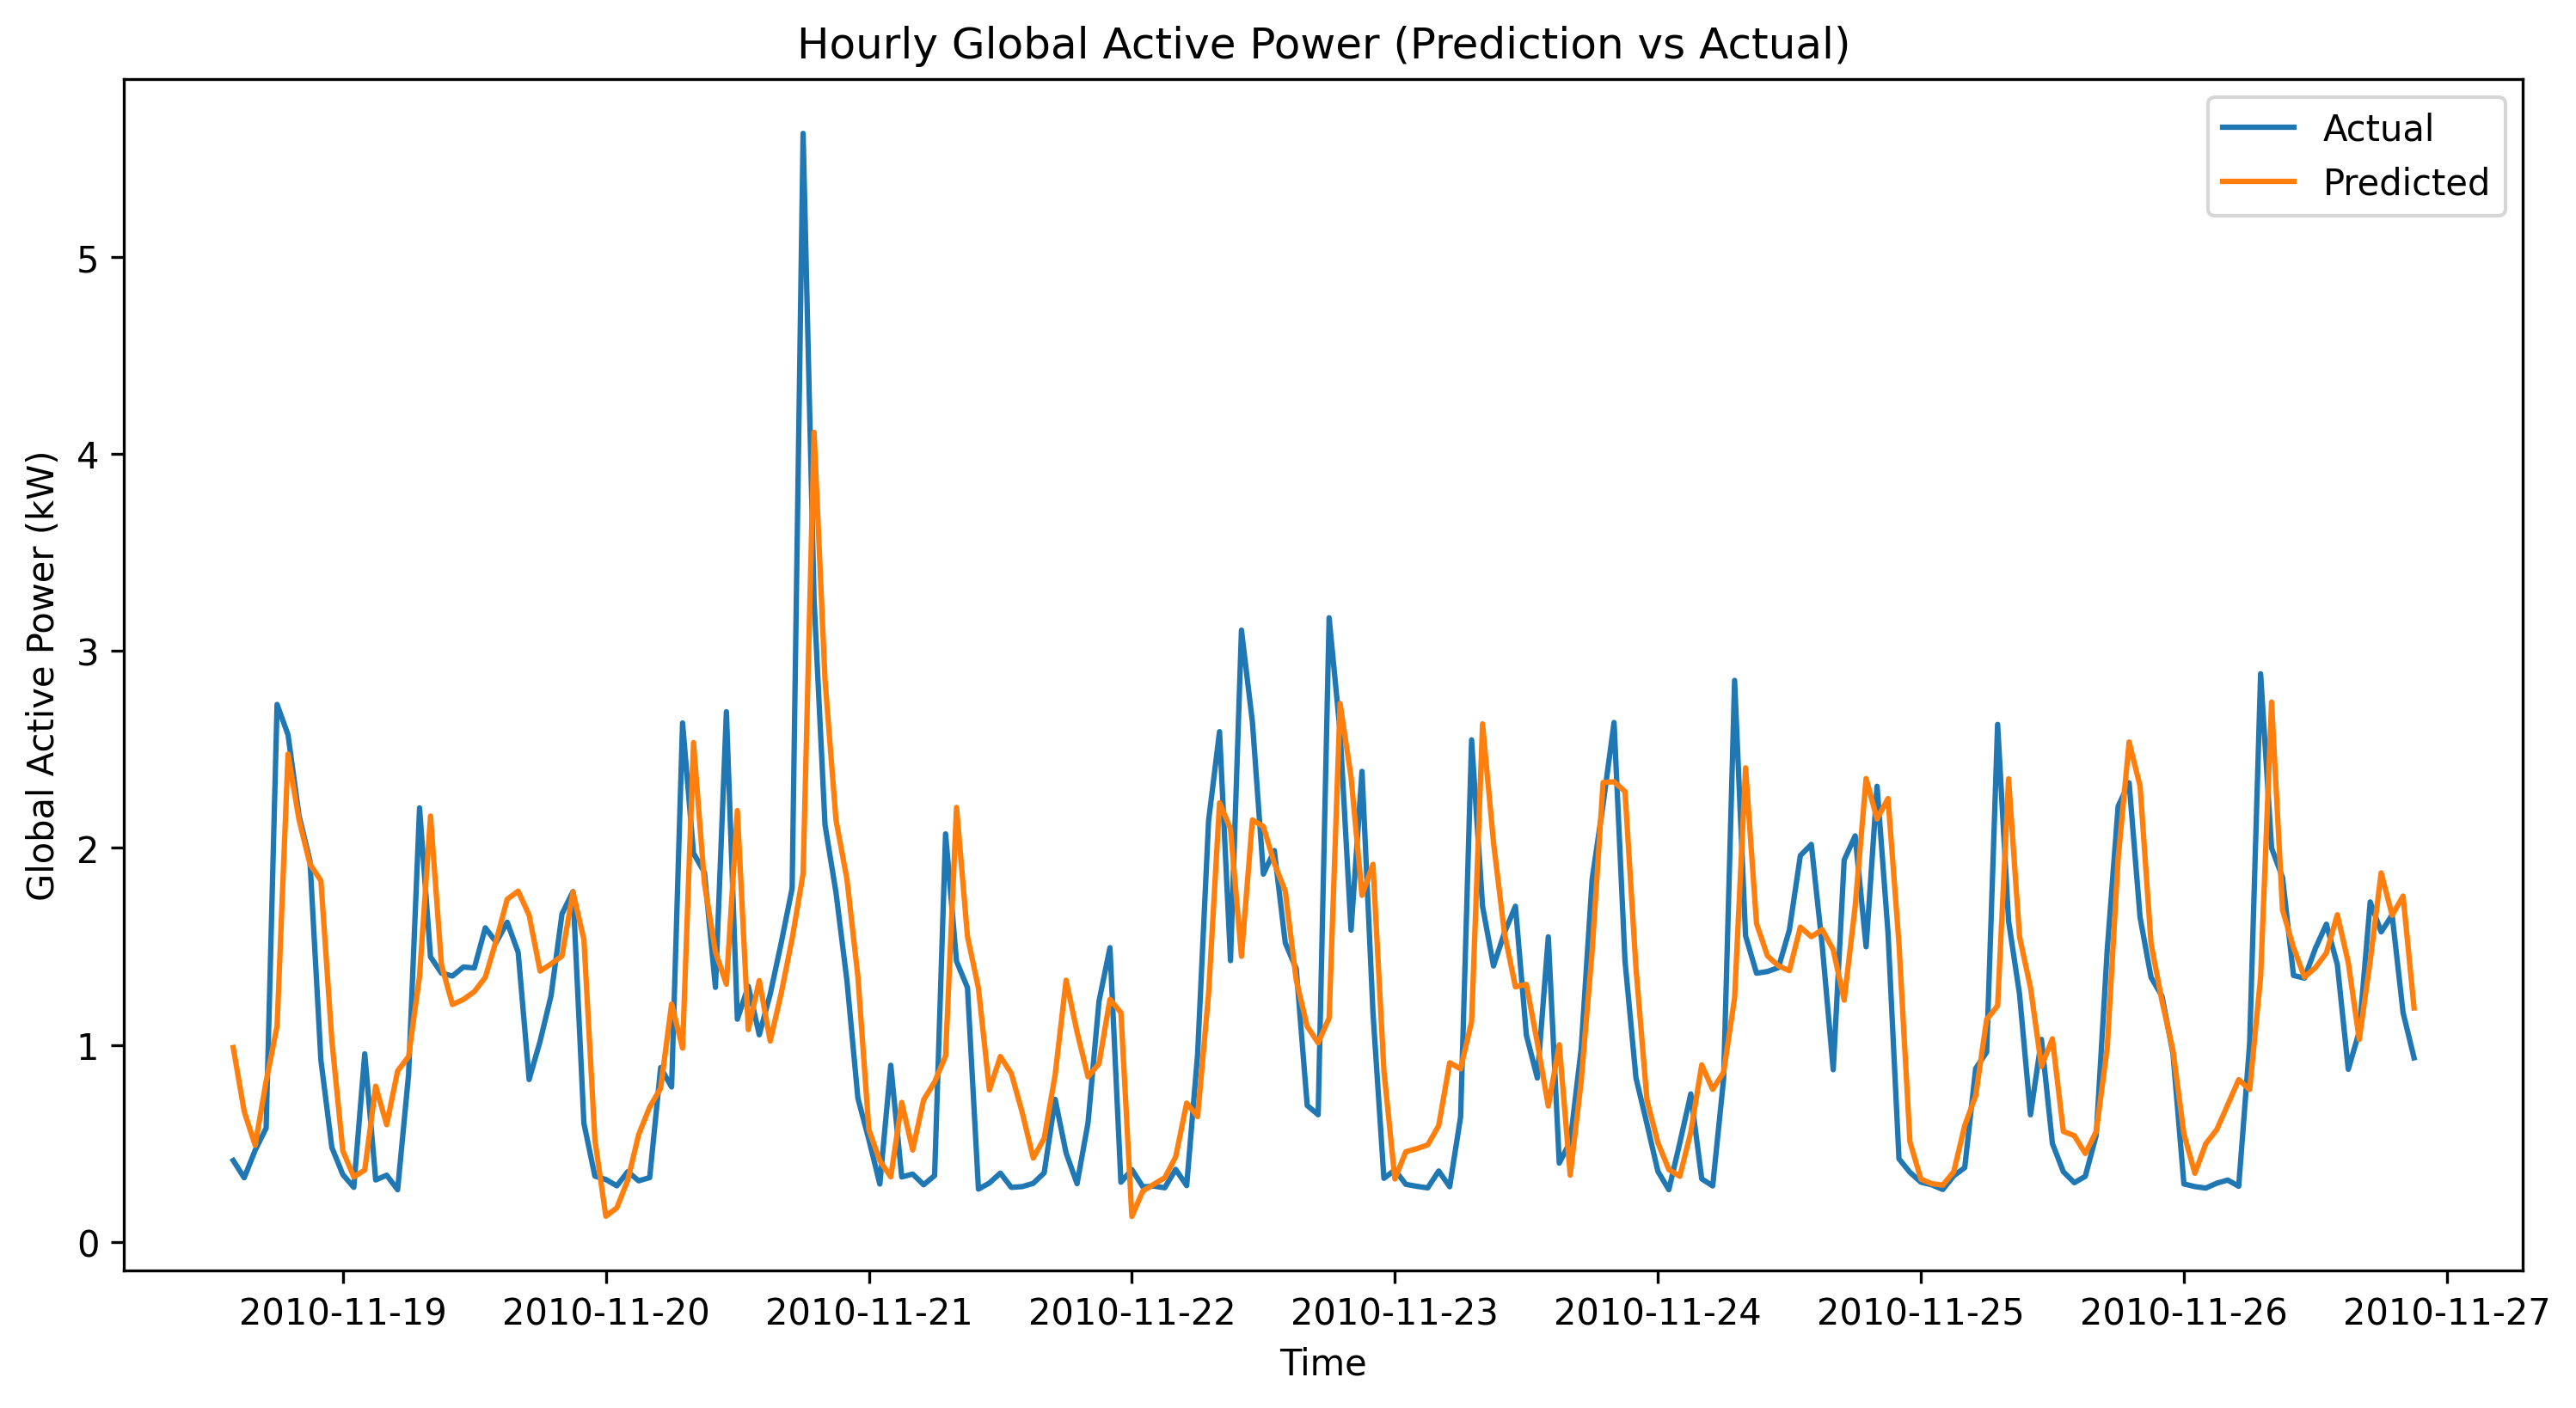

In [21]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-4 Adam(learning_rate=0.0001, epochs=100, batch_size=256)

(27661, 12, 6) (27661,) (6916, 12, 6) (6916,)
Epoch 1/100
109/109 - 7s - 62ms/step - loss: 0.0277 - val_loss: 0.0116
Epoch 2/100
109/109 - 5s - 45ms/step - loss: 0.0218 - val_loss: 0.0108
Epoch 3/100
109/109 - 7s - 62ms/step - loss: 0.0198 - val_loss: 0.0103
Epoch 4/100
109/109 - 4s - 40ms/step - loss: 0.0183 - val_loss: 0.0098
Epoch 5/100
109/109 - 5s - 45ms/step - loss: 0.0174 - val_loss: 0.0094
Epoch 6/100
109/109 - 7s - 63ms/step - loss: 0.0164 - val_loss: 0.0091
Epoch 7/100
109/109 - 4s - 40ms/step - loss: 0.0157 - val_loss: 0.0089
Epoch 8/100
109/109 - 4s - 39ms/step - loss: 0.0151 - val_loss: 0.0087
Epoch 9/100
109/109 - 8s - 75ms/step - loss: 0.0146 - val_loss: 0.0085
Epoch 10/100
109/109 - 4s - 39ms/step - loss: 0.0141 - val_loss: 0.0083
Epoch 11/100
109/109 - 5s - 45ms/step - loss: 0.0136 - val_loss: 0.0082
Epoch 12/100
109/109 - 7s - 66ms/step - loss: 0.0133 - val_loss: 0.0080
Epoch 13/100
109/109 - 4s - 38ms/step - loss: 0.0131 - val_loss: 0.0080
Epoch 14/100
109/109 - 5s -

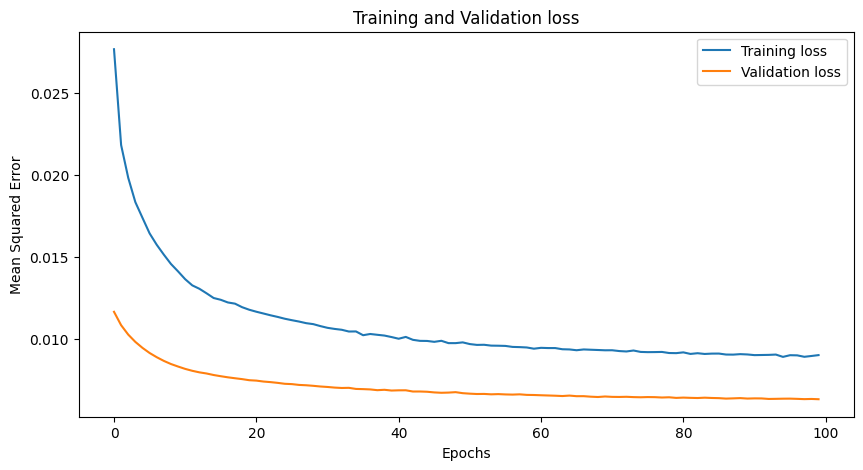

865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Train MAE: 0.424
Train MSE: 0.350
Train RMSE: 0.591
Train R² score: 0.593

Test MAE: 0.377
Test MSE: 0.261
Test RMSE: 0.511
Test R² score: 0.501


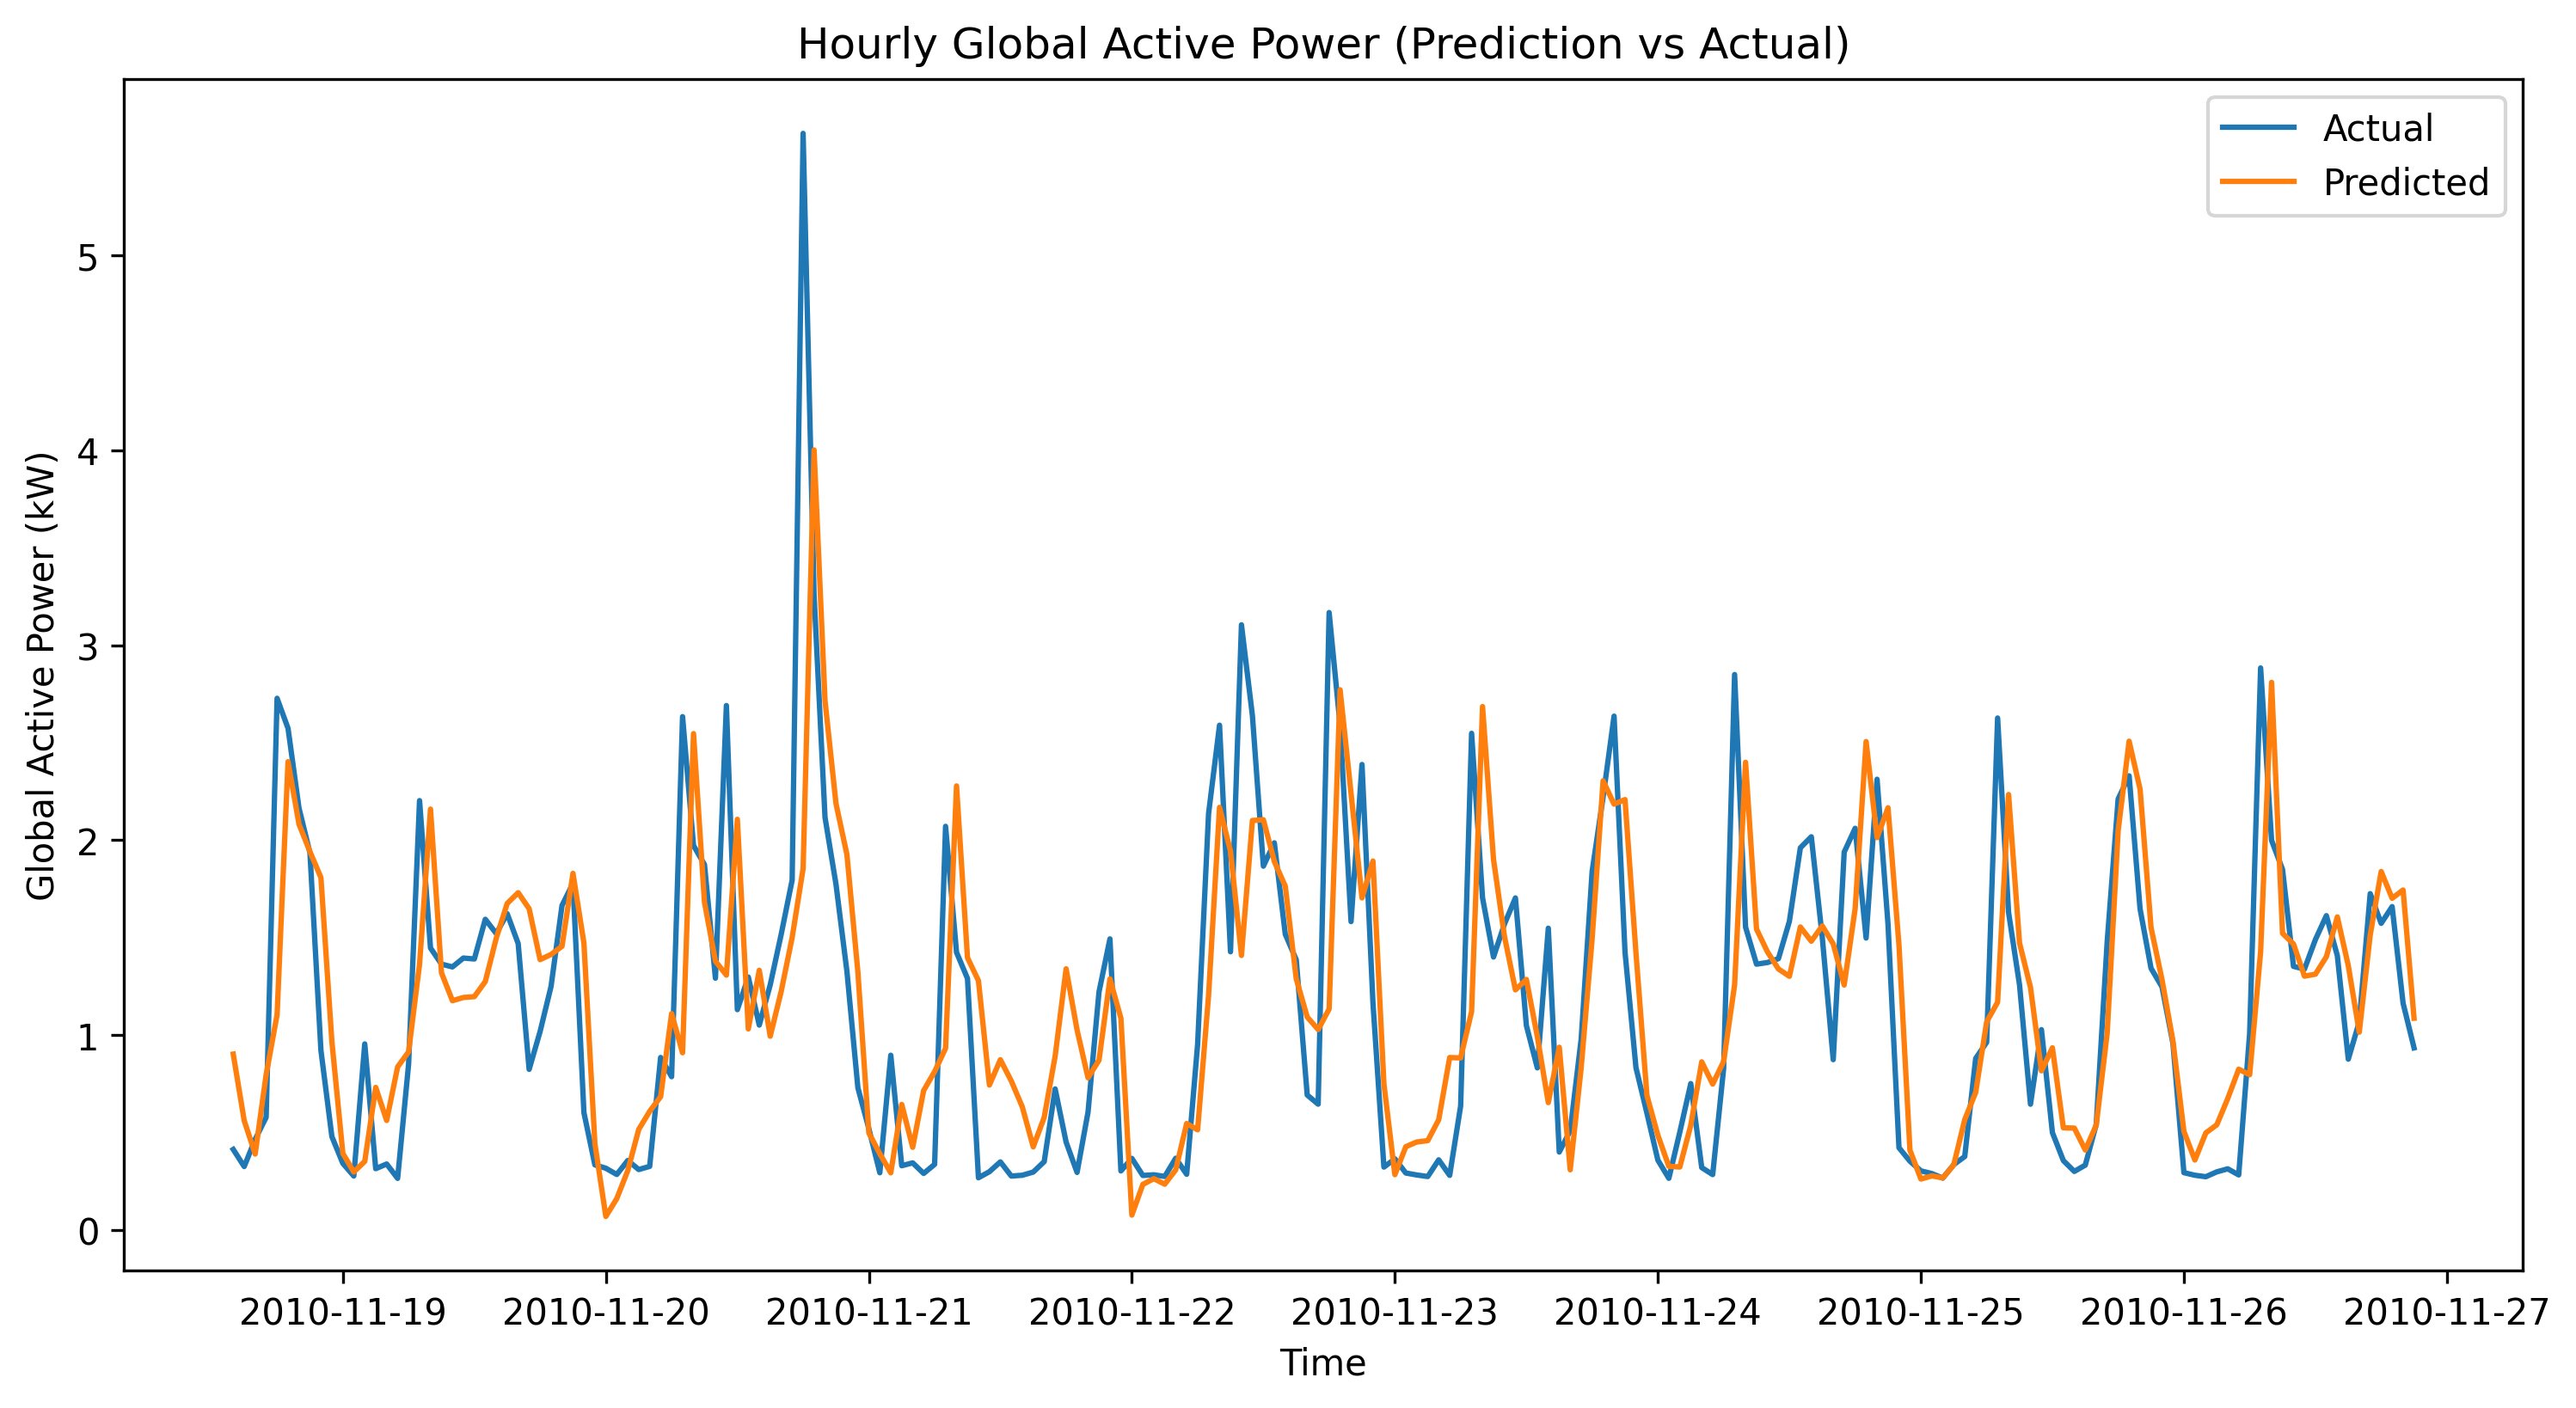

In [22]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-5 SGD(learning_rate=0.0001, epochs=20, batch_size=32)

(27661, 12, 6) (27661,) (6916, 12, 6) (6916,)
Epoch 1/20
865/865 - 11s - 12ms/step - loss: 0.0530 - val_loss: 0.0216
Epoch 2/20
865/865 - 9s - 10ms/step - loss: 0.0327 - val_loss: 0.0142
Epoch 3/20
865/865 - 9s - 10ms/step - loss: 0.0273 - val_loss: 0.0127
Epoch 4/20
865/865 - 12s - 14ms/step - loss: 0.0260 - val_loss: 0.0125
Epoch 5/20
865/865 - 9s - 10ms/step - loss: 0.0254 - val_loss: 0.0125
Epoch 6/20
865/865 - 9s - 10ms/step - loss: 0.0250 - val_loss: 0.0125
Epoch 7/20
865/865 - 11s - 13ms/step - loss: 0.0249 - val_loss: 0.0125
Epoch 8/20
865/865 - 8s - 9ms/step - loss: 0.0247 - val_loss: 0.0124
Epoch 9/20
865/865 - 12s - 14ms/step - loss: 0.0247 - val_loss: 0.0123
Epoch 10/20
865/865 - 11s - 12ms/step - loss: 0.0245 - val_loss: 0.0123
Epoch 11/20
865/865 - 8s - 10ms/step - loss: 0.0241 - val_loss: 0.0122
Epoch 12/20
865/865 - 12s - 14ms/step - loss: 0.0240 - val_loss: 0.0121
Epoch 13/20
865/865 - 9s - 10ms/step - loss: 0.0240 - val_loss: 0.0121
Epoch 14/20
865/865 - 9s - 10ms/ste

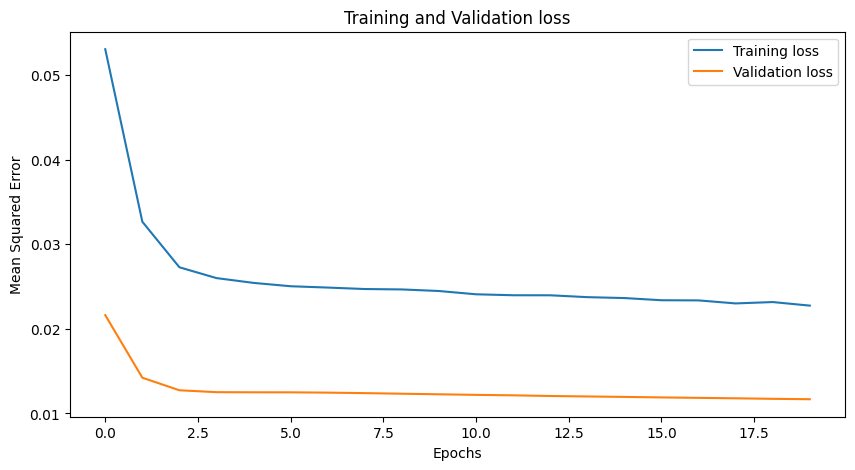

865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Train MAE: 0.704
Train MSE: 0.786
Train RMSE: 0.887
Train R² score: 0.086

Test MAE: 0.571
Test MSE: 0.484
Test RMSE: 0.696
Test R² score: 0.075


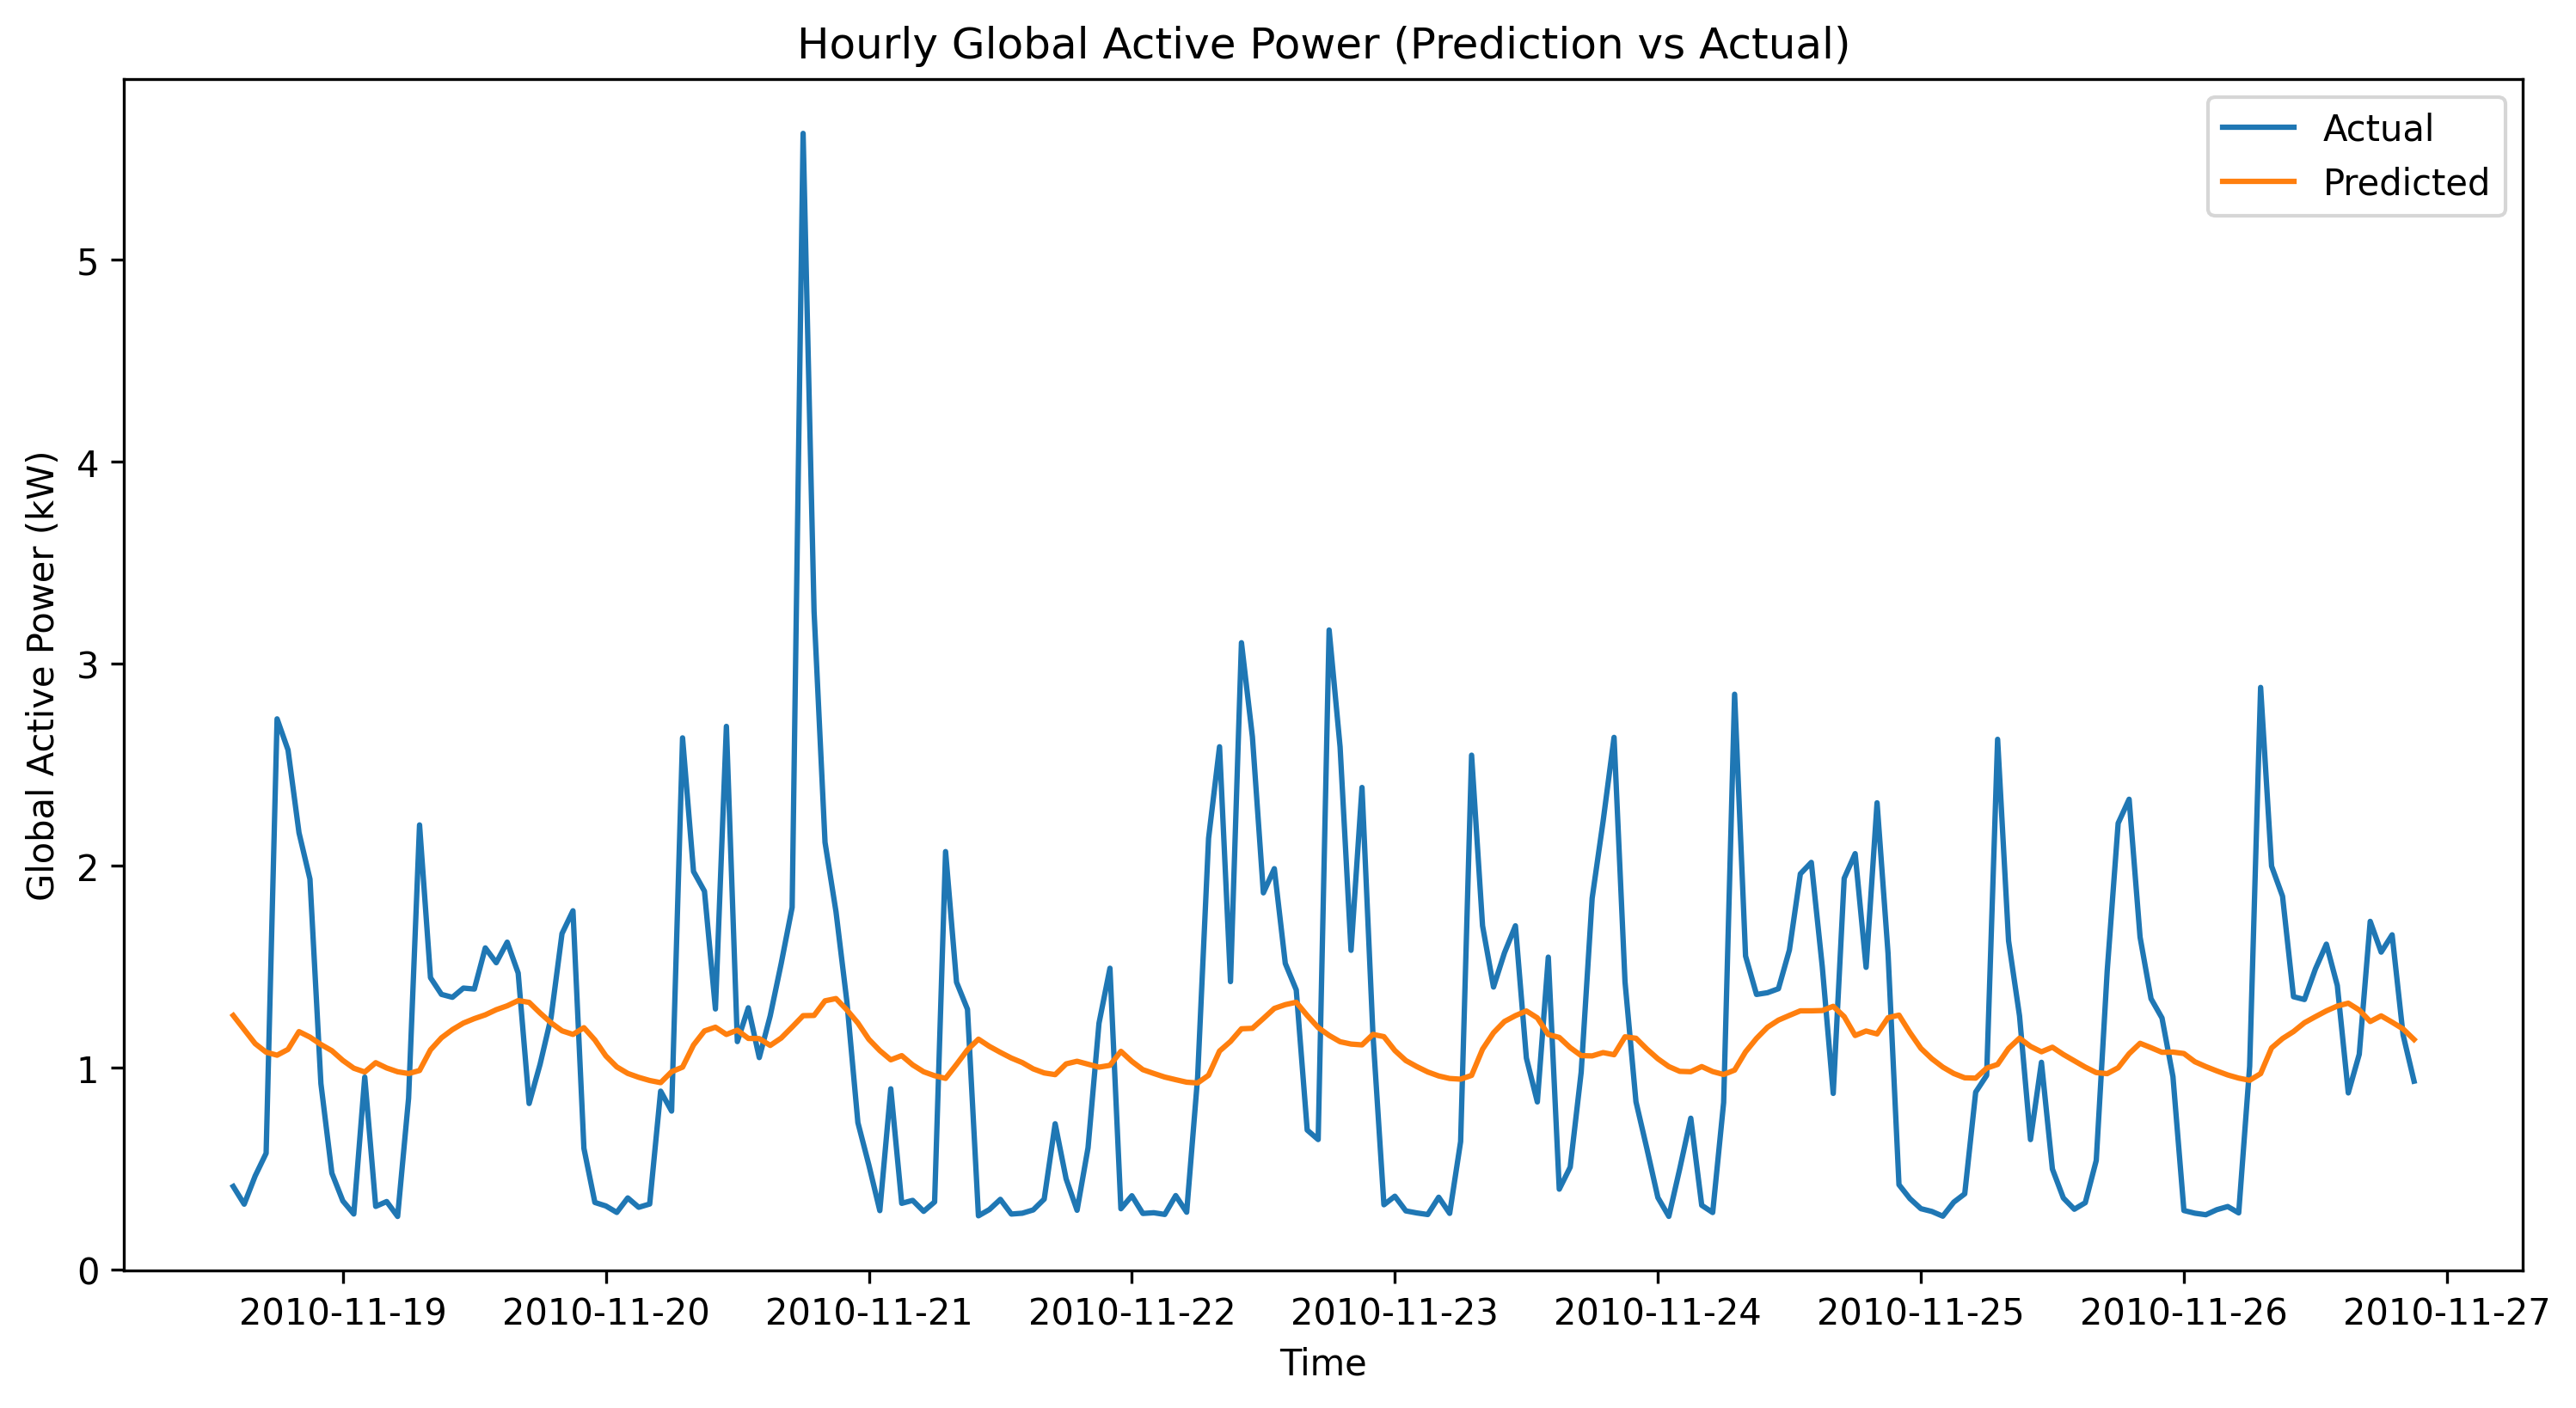

In [23]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-6 SGD(learning_rate=0.0001, epochs=30, batch_size=64)

Epoch 1/30
433/433 - 11s - 25ms/step - loss: 0.0426 - val_loss: 0.0192
Epoch 2/30
433/433 - 7s - 17ms/step - loss: 0.0364 - val_loss: 0.0162
Epoch 3/30
433/433 - 9s - 21ms/step - loss: 0.0334 - val_loss: 0.0150
Epoch 4/30
433/433 - 7s - 17ms/step - loss: 0.0318 - val_loss: 0.0147
Epoch 5/30
433/433 - 9s - 21ms/step - loss: 0.0310 - val_loss: 0.0146
Epoch 6/30
433/433 - 9s - 22ms/step - loss: 0.0302 - val_loss: 0.0146
Epoch 7/30
433/433 - 9s - 20ms/step - loss: 0.0303 - val_loss: 0.0146
Epoch 8/30
433/433 - 13s - 29ms/step - loss: 0.0298 - val_loss: 0.0146
Epoch 9/30
433/433 - 7s - 17ms/step - loss: 0.0298 - val_loss: 0.0145
Epoch 10/30
433/433 - 10s - 23ms/step - loss: 0.0292 - val_loss: 0.0145
Epoch 11/30
433/433 - 8s - 18ms/step - loss: 0.0293 - val_loss: 0.0145
Epoch 12/30
433/433 - 9s - 21ms/step - loss: 0.0291 - val_loss: 0.0144
Epoch 13/30
433/433 - 13s - 30ms/step - loss: 0.0290 - val_loss: 0.0144
Epoch 14/30
433/433 - 9s - 20ms/step - loss: 0.0293 - val_loss: 0.0143
Epoch 15/30

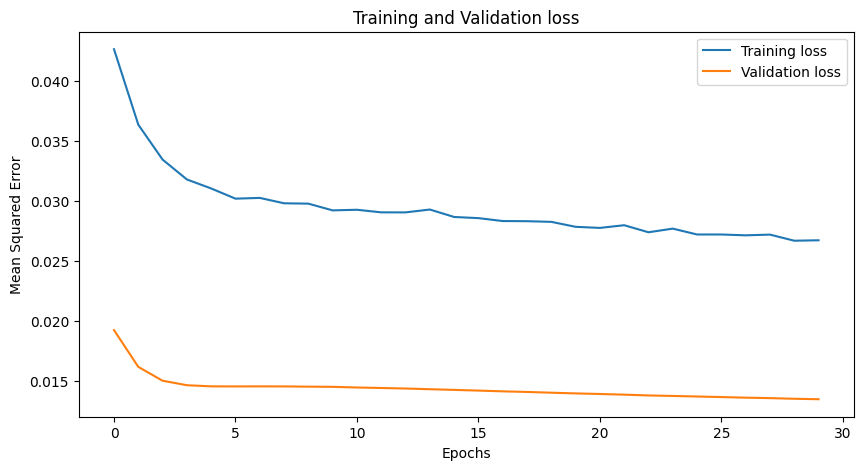

865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Train MAE: 0.758
Train MSE: 0.911
Train RMSE: 0.954
Train R² score: -0.058

Test MAE: 0.619
Test MSE: 0.559
Test RMSE: 0.747
Test R² score: -0.067


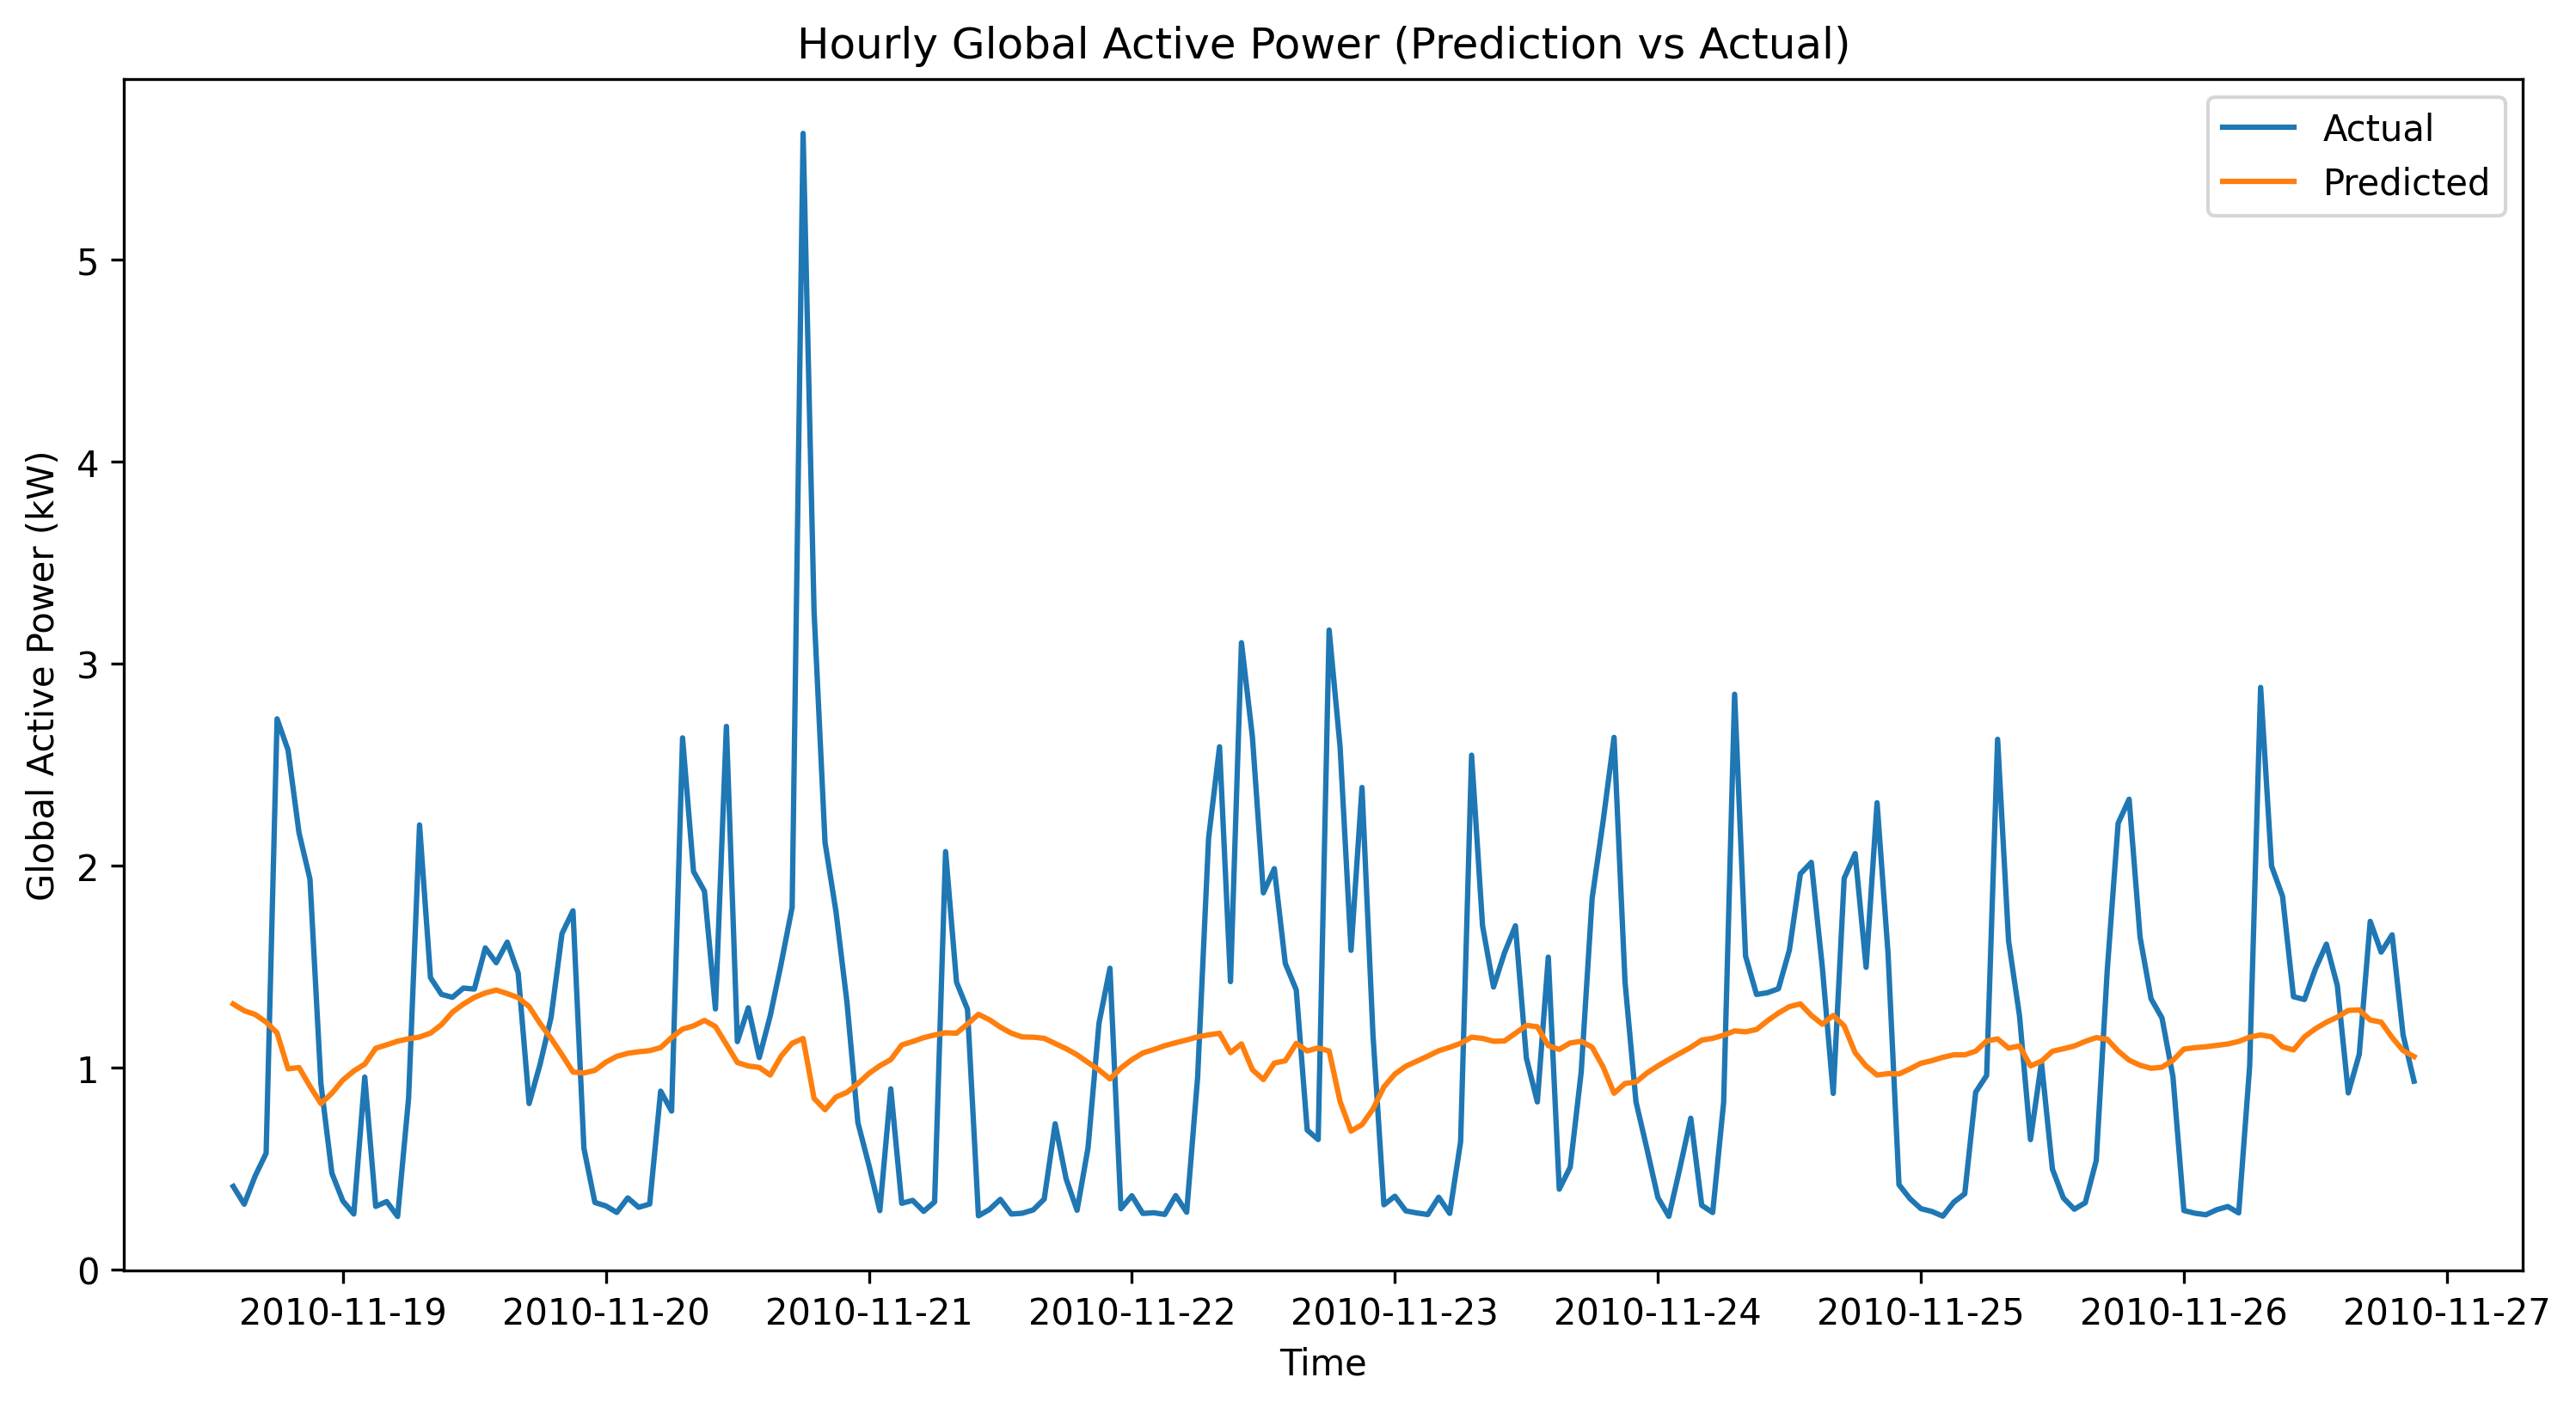

In [24]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-7 SGD(learning_rate=0.0001, epochs=50, batch_size=128)

Epoch 1/50
217/217 - 10s - 47ms/step - loss: 0.0239 - val_loss: 0.0113
Epoch 2/50
217/217 - 7s - 31ms/step - loss: 0.0190 - val_loss: 0.0102
Epoch 3/50
217/217 - 10s - 47ms/step - loss: 0.0172 - val_loss: 0.0095
Epoch 4/50
217/217 - 6s - 27ms/step - loss: 0.0157 - val_loss: 0.0090
Epoch 5/50
217/217 - 9s - 44ms/step - loss: 0.0148 - val_loss: 0.0086
Epoch 6/50
217/217 - 12s - 54ms/step - loss: 0.0139 - val_loss: 0.0083
Epoch 7/50
217/217 - 12s - 55ms/step - loss: 0.0135 - val_loss: 0.0081
Epoch 8/50
217/217 - 7s - 33ms/step - loss: 0.0130 - val_loss: 0.0081
Epoch 9/50
217/217 - 12s - 55ms/step - loss: 0.0127 - val_loss: 0.0079
Epoch 10/50
217/217 - 5s - 24ms/step - loss: 0.0123 - val_loss: 0.0078
Epoch 11/50
217/217 - 10s - 47ms/step - loss: 0.0121 - val_loss: 0.0077
Epoch 12/50
217/217 - 13s - 60ms/step - loss: 0.0120 - val_loss: 0.0077
Epoch 13/50
217/217 - 7s - 34ms/step - loss: 0.0118 - val_loss: 0.0076
Epoch 14/50
217/217 - 10s - 46ms/step - loss: 0.0116 - val_loss: 0.0075
Epoch 1

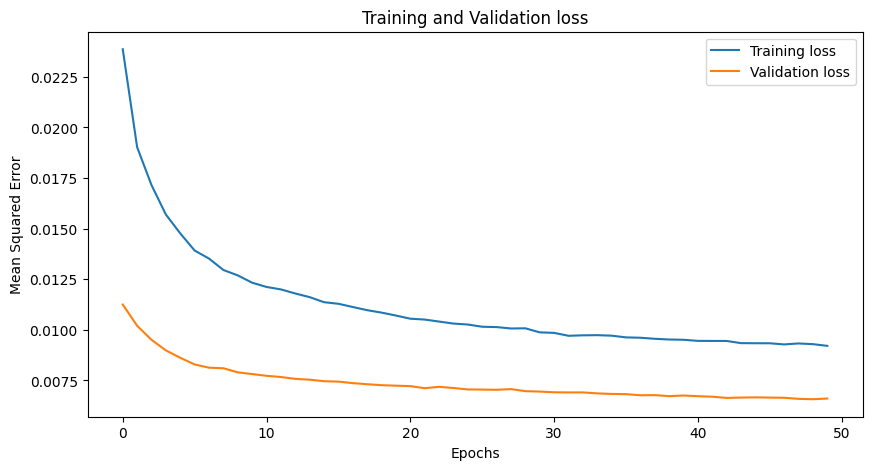

865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Train MAE: 0.446
Train MSE: 0.363
Train RMSE: 0.603
Train R² score: 0.578

Test MAE: 0.397
Test MSE: 0.274
Test RMSE: 0.523
Test R² score: 0.477


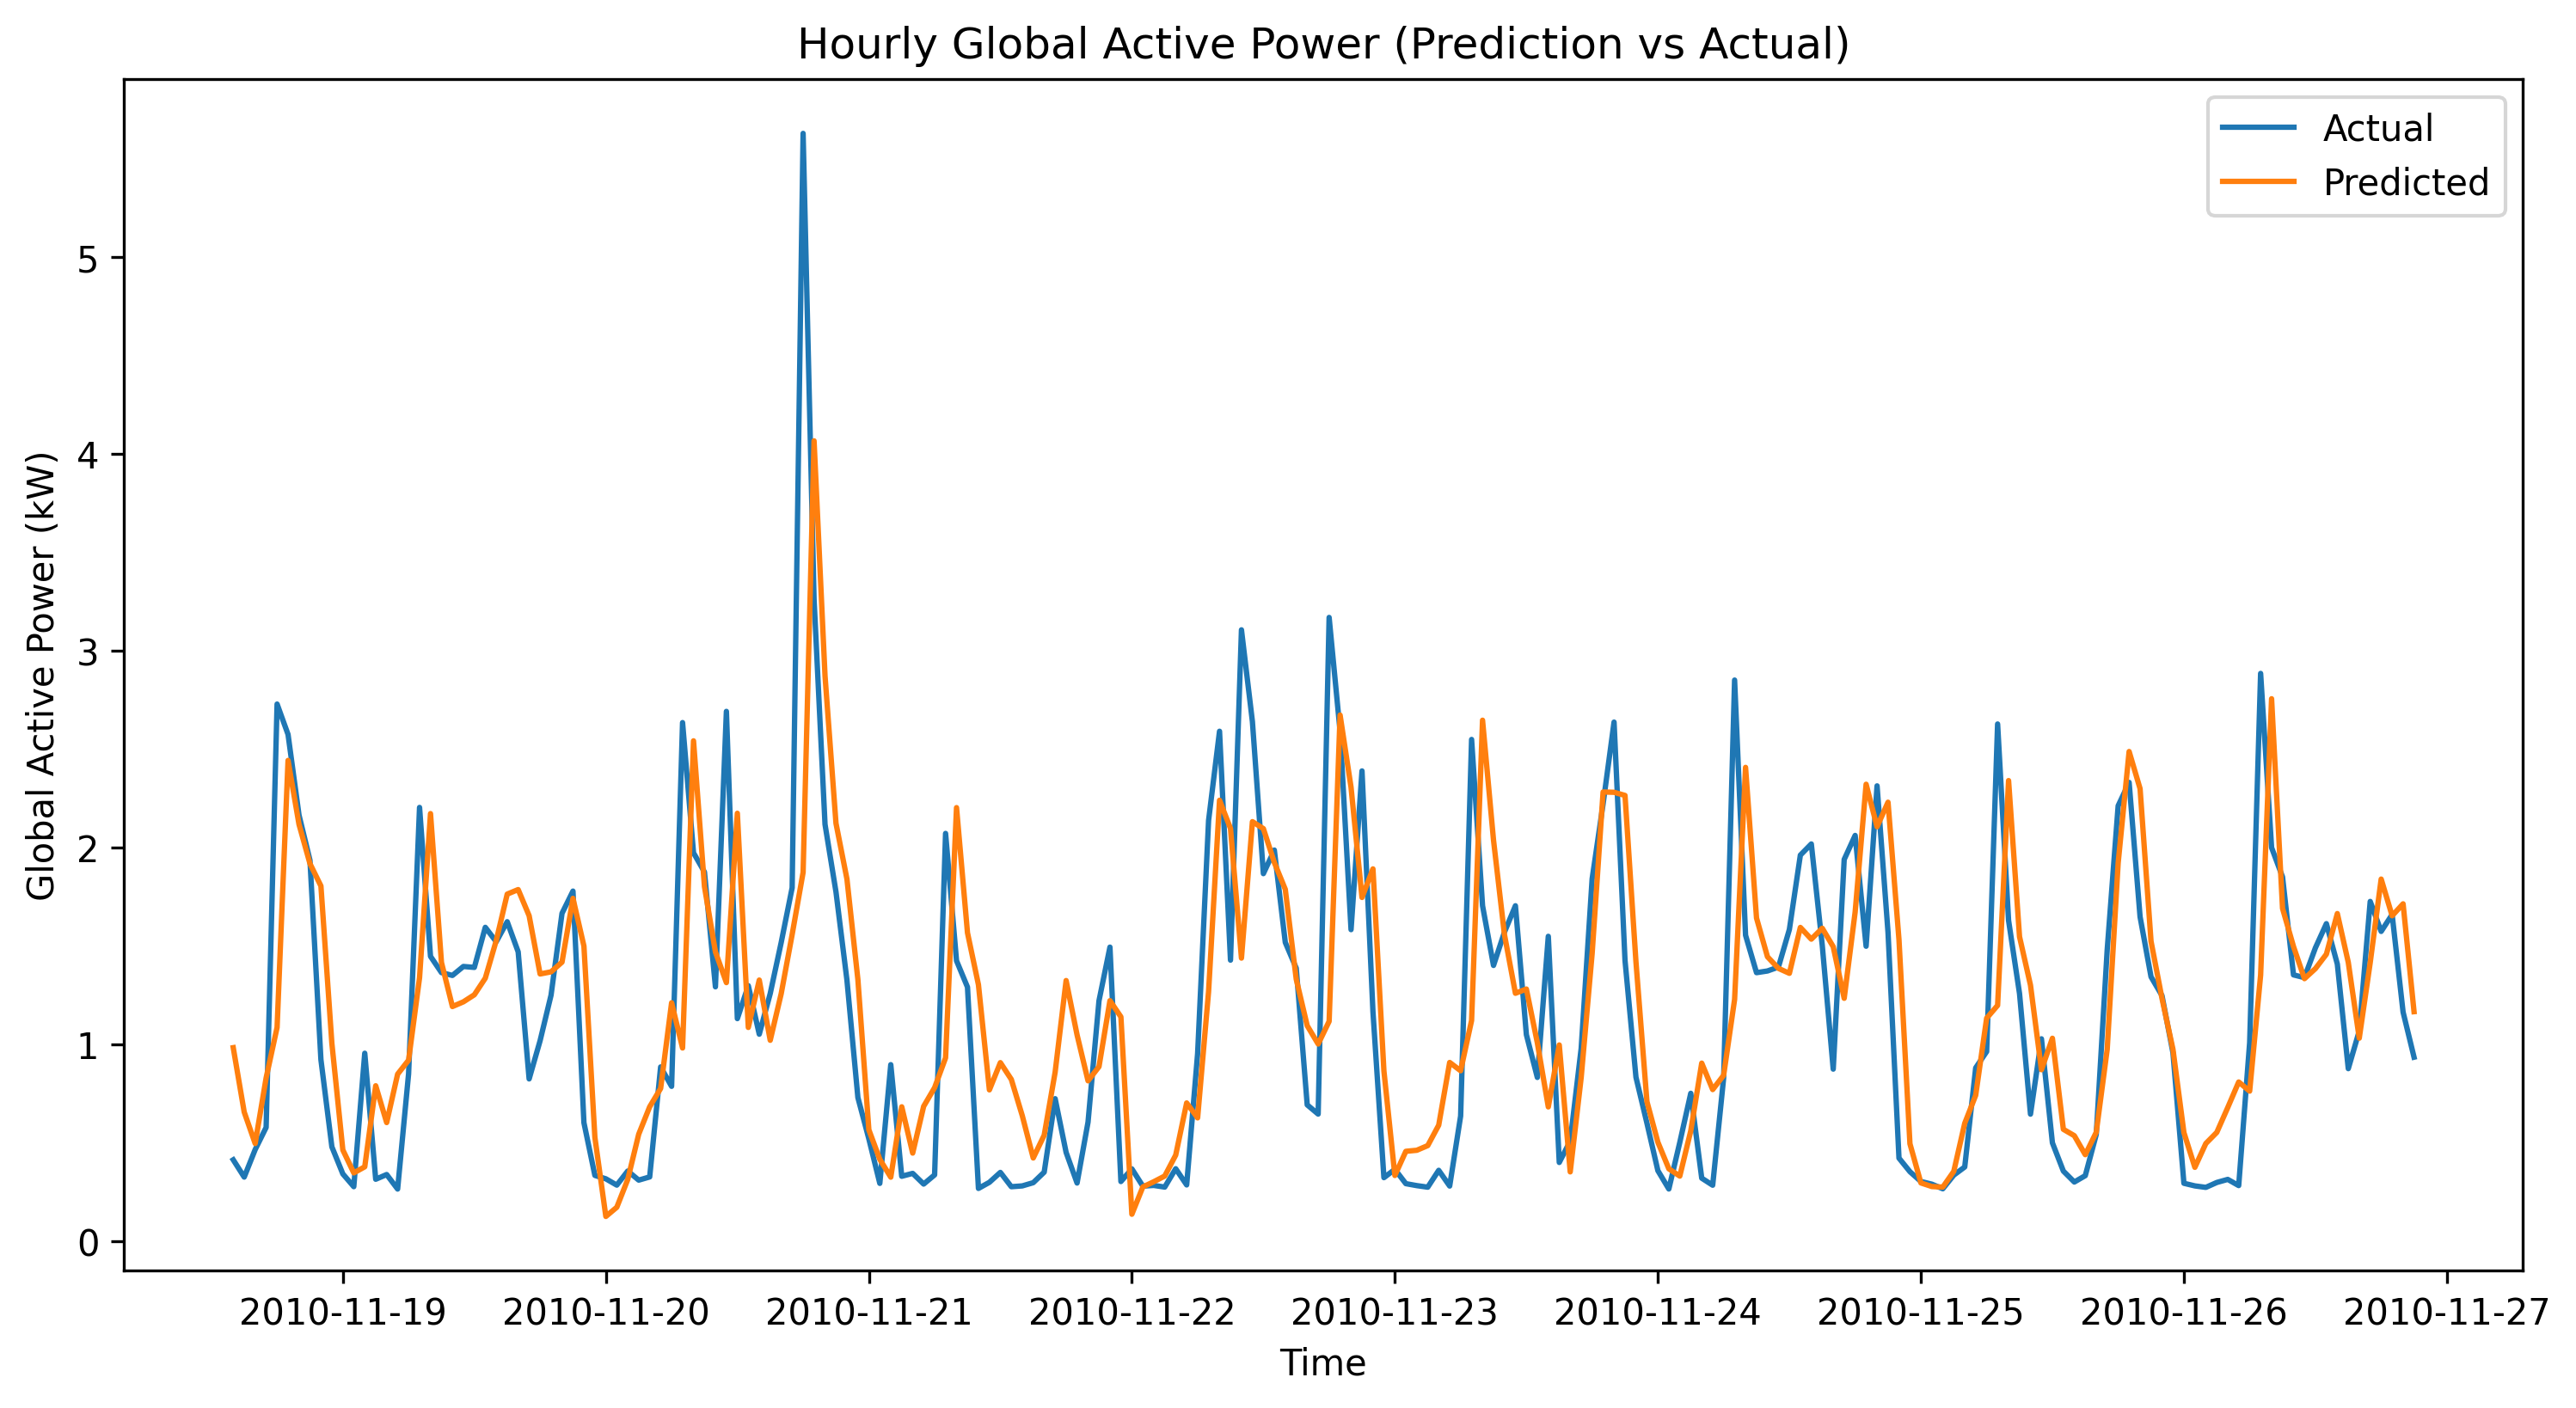

In [25]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-8 SGD(learning_rate=0.0001, epochs=100, batch_size=256)

(27661, 12, 6) (27661,) (6916, 12, 6) (6916,)
Epoch 1/100
109/109 - 8s - 74ms/step - loss: 0.0371 - val_loss: 0.0193
Epoch 2/100
109/109 - 7s - 64ms/step - loss: 0.0348 - val_loss: 0.0177
Epoch 3/100
109/109 - 7s - 65ms/step - loss: 0.0333 - val_loss: 0.0164
Epoch 4/100
109/109 - 9s - 78ms/step - loss: 0.0313 - val_loss: 0.0153
Epoch 5/100
109/109 - 7s - 61ms/step - loss: 0.0304 - val_loss: 0.0144
Epoch 6/100
109/109 - 5s - 48ms/step - loss: 0.0293 - val_loss: 0.0137
Epoch 7/100
109/109 - 4s - 38ms/step - loss: 0.0284 - val_loss: 0.0131
Epoch 8/100
109/109 - 5s - 50ms/step - loss: 0.0278 - val_loss: 0.0127
Epoch 9/100
109/109 - 9s - 82ms/step - loss: 0.0271 - val_loss: 0.0123
Epoch 10/100
109/109 - 6s - 51ms/step - loss: 0.0262 - val_loss: 0.0121
Epoch 11/100
109/109 - 9s - 80ms/step - loss: 0.0258 - val_loss: 0.0119
Epoch 12/100
109/109 - 8s - 69ms/step - loss: 0.0255 - val_loss: 0.0117
Epoch 13/100
109/109 - 8s - 72ms/step - loss: 0.0256 - val_loss: 0.0116
Epoch 14/100
109/109 - 7s -

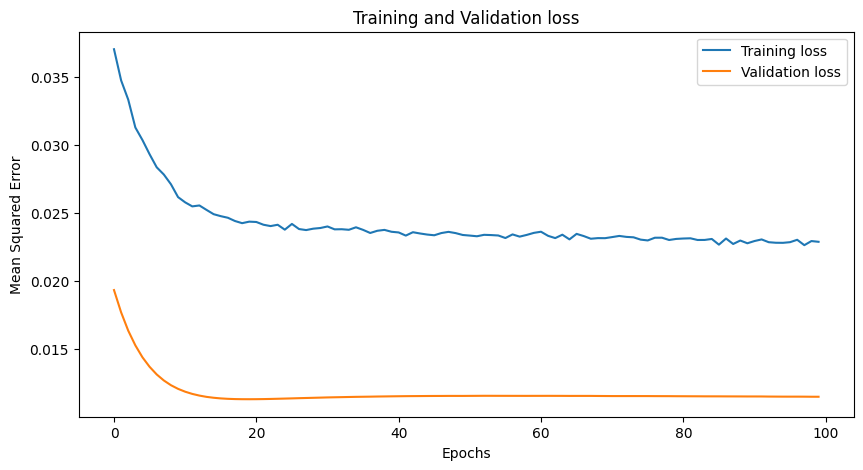

865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Train MAE: 0.687
Train MSE: 0.767
Train RMSE: 0.876
Train R² score: 0.109

Test MAE: 0.559
Test MSE: 0.476
Test RMSE: 0.690
Test R² score: 0.090


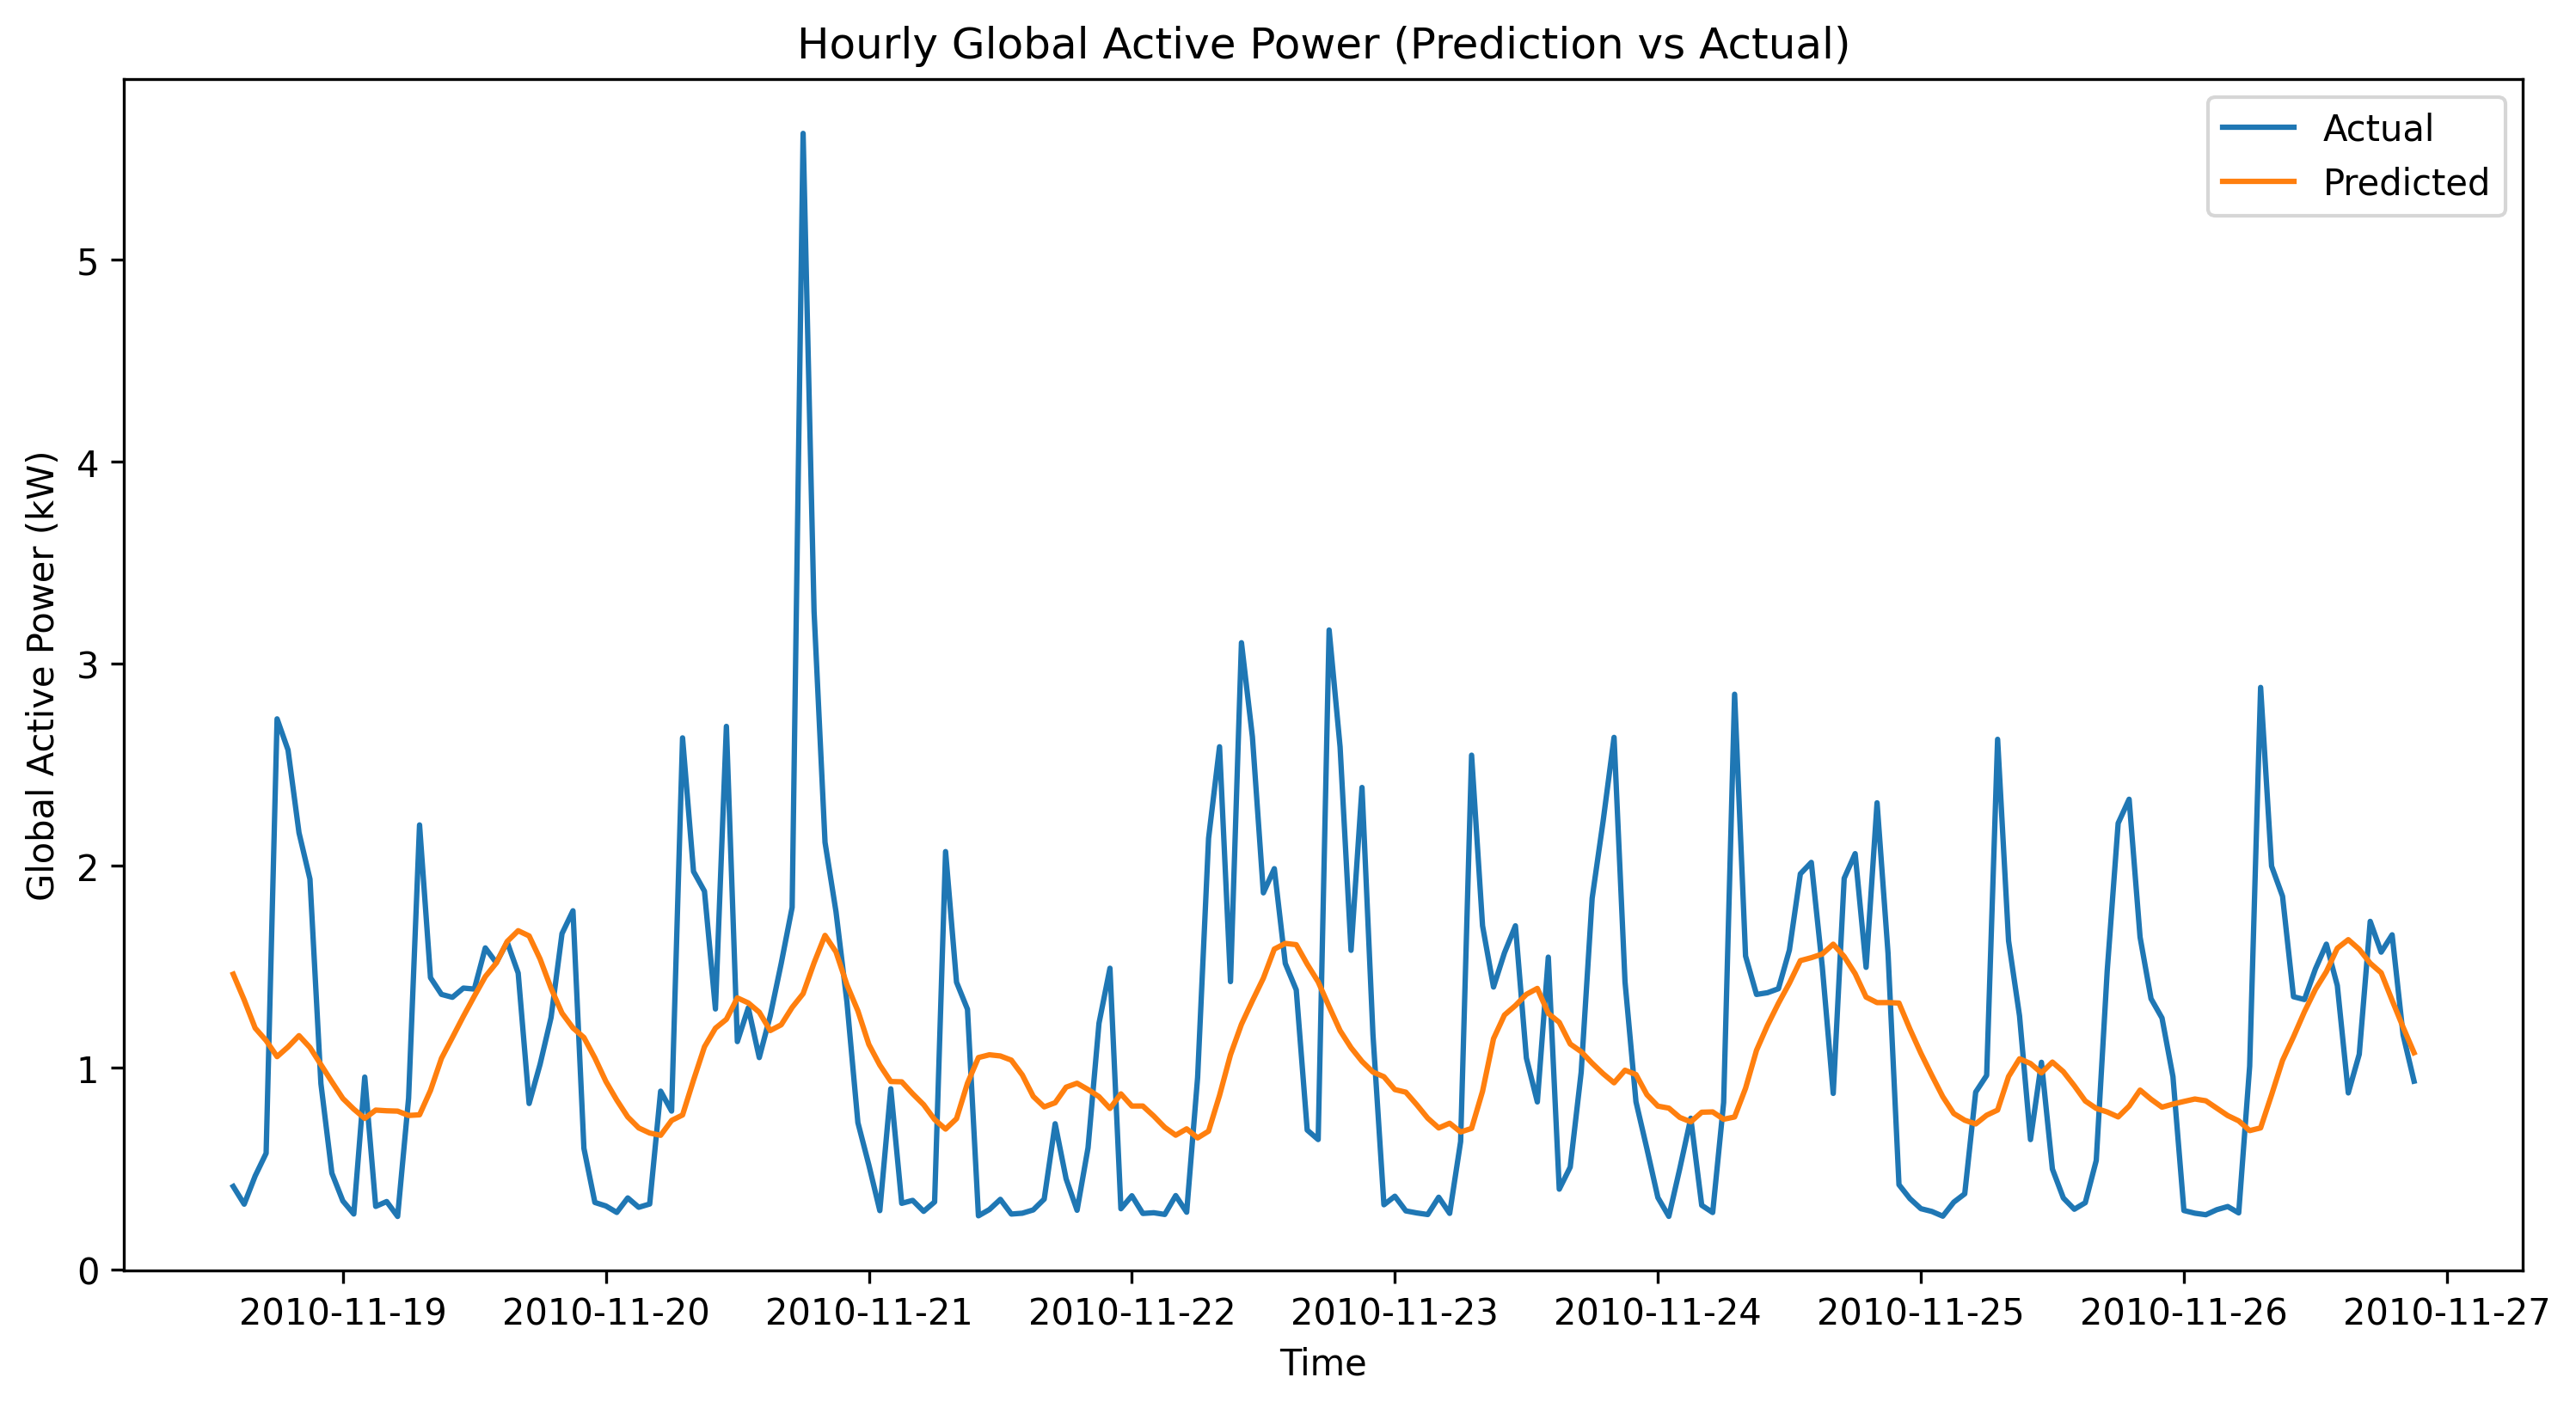

In [26]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-9 RMSProp(learning_rate=0.0001, epochs=20, batch_size=32)

Epoch 1/20
865/865 - 10s - 12ms/step - loss: 0.0186 - val_loss: 0.0103
Epoch 2/20
865/865 - 10s - 11ms/step - loss: 0.0138 - val_loss: 0.0093
Epoch 3/20
865/865 - 11s - 13ms/step - loss: 0.0124 - val_loss: 0.0088
Epoch 4/20
865/865 - 21s - 24ms/step - loss: 0.0117 - val_loss: 0.0085
Epoch 5/20
865/865 - 9s - 11ms/step - loss: 0.0113 - val_loss: 0.0084
Epoch 6/20
865/865 - 9s - 11ms/step - loss: 0.0110 - val_loss: 0.0083
Epoch 7/20
865/865 - 12s - 14ms/step - loss: 0.0107 - val_loss: 0.0081
Epoch 8/20
865/865 - 18s - 21ms/step - loss: 0.0106 - val_loss: 0.0081
Epoch 9/20
865/865 - 10s - 12ms/step - loss: 0.0104 - val_loss: 0.0079
Epoch 10/20
865/865 - 19s - 22ms/step - loss: 0.0103 - val_loss: 0.0081
Epoch 11/20
865/865 - 11s - 12ms/step - loss: 0.0102 - val_loss: 0.0080
Epoch 12/20
865/865 - 19s - 22ms/step - loss: 0.0101 - val_loss: 0.0080
Epoch 13/20
865/865 - 11s - 13ms/step - loss: 0.0099 - val_loss: 0.0080
Epoch 14/20
865/865 - 8s - 9ms/step - loss: 0.0098 - val_loss: 0.0080
Epoch

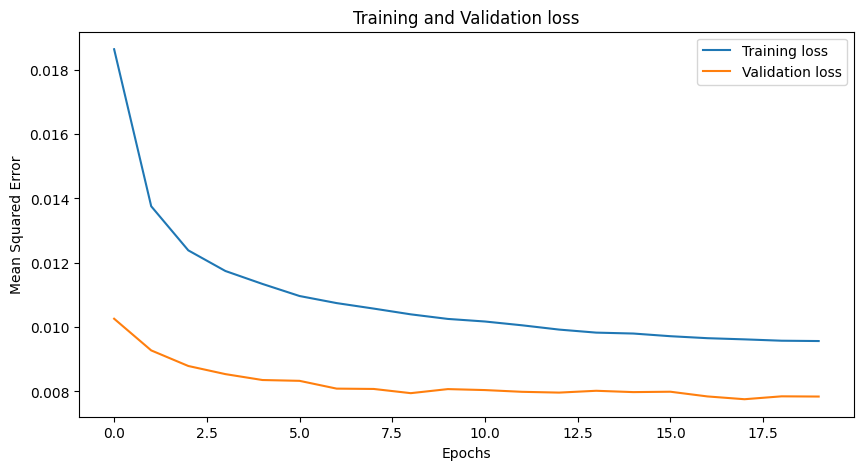

865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Train MAE: 0.509
Train MSE: 0.418
Train RMSE: 0.647
Train R² score: 0.514

Test MAE: 0.459
Test MSE: 0.325
Test RMSE: 0.570
Test R² score: 0.380


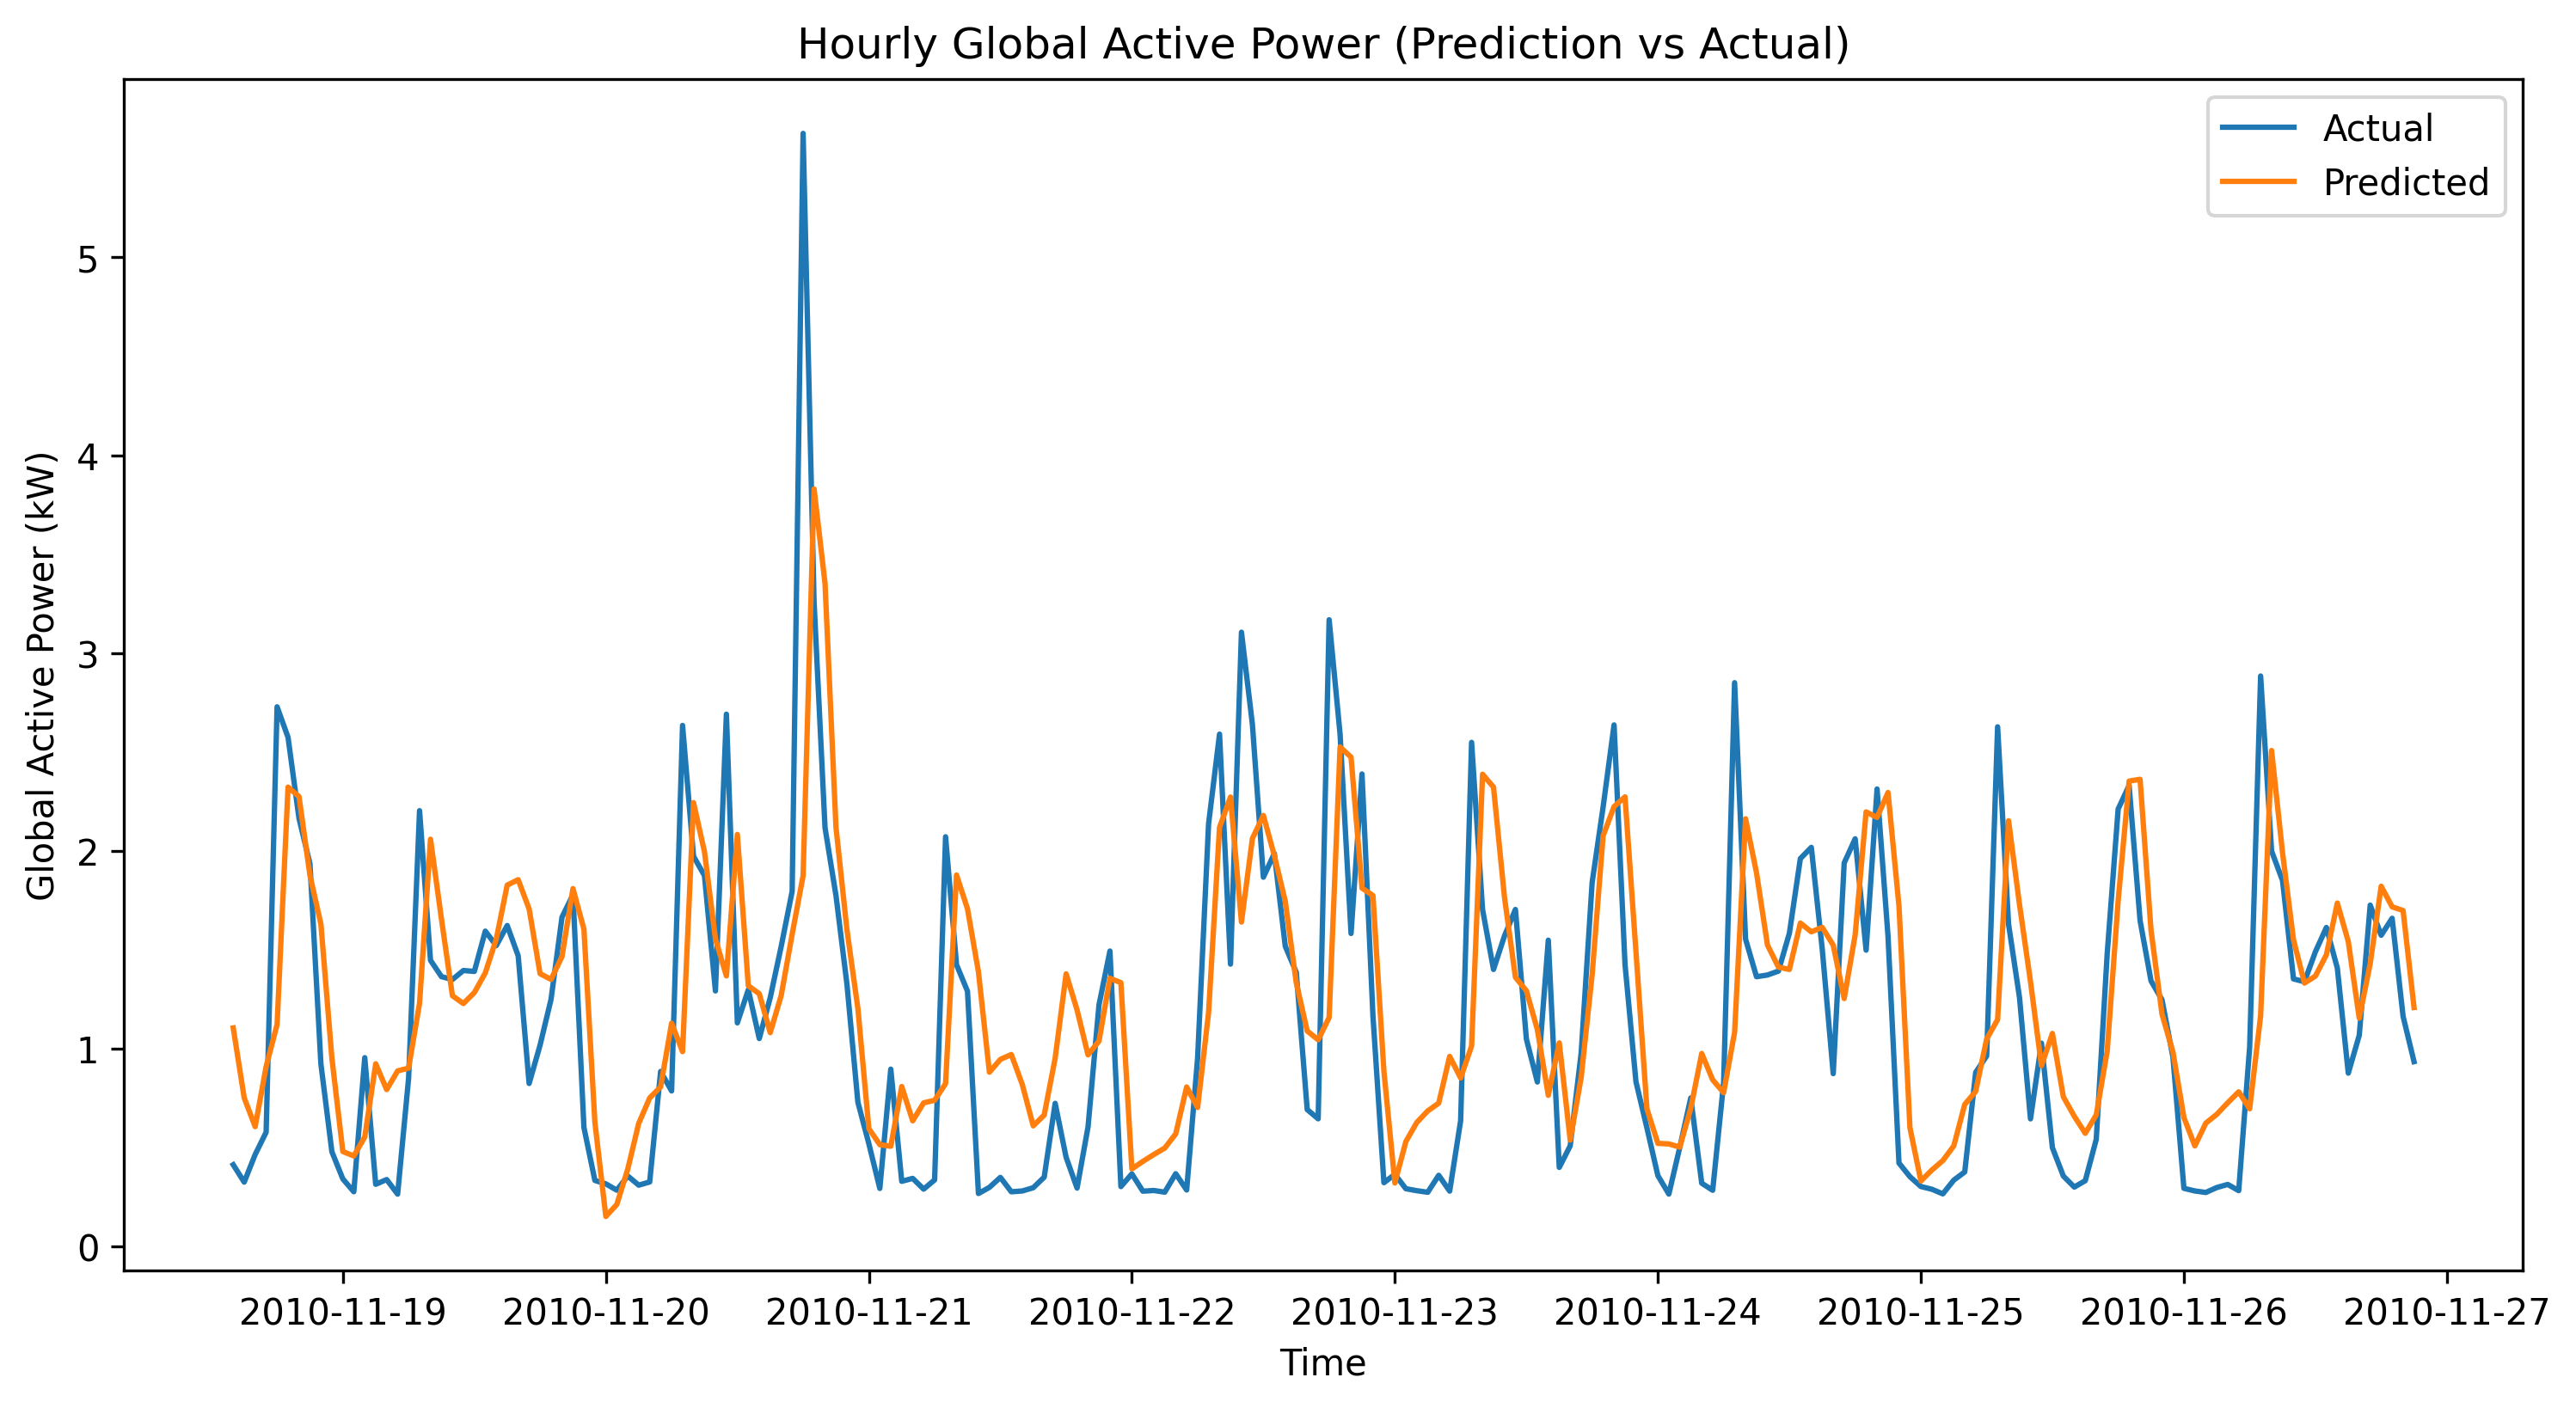

In [27]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-10 RMSProp(learning_rate=0.0001, epochs=30, batch_size=64)

Epoch 1/30
433/433 - 11s - 26ms/step - loss: 0.0247 - val_loss: 0.0120
Epoch 2/30
433/433 - 8s - 18ms/step - loss: 0.0155 - val_loss: 0.0108
Epoch 3/30
433/433 - 13s - 30ms/step - loss: 0.0141 - val_loss: 0.0105
Epoch 4/30
433/433 - 8s - 17ms/step - loss: 0.0131 - val_loss: 0.0094
Epoch 5/30
433/433 - 10s - 22ms/step - loss: 0.0125 - val_loss: 0.0089
Epoch 6/30
433/433 - 10s - 23ms/step - loss: 0.0120 - val_loss: 0.0084
Epoch 7/30
433/433 - 8s - 18ms/step - loss: 0.0118 - val_loss: 0.0085
Epoch 8/30
433/433 - 13s - 30ms/step - loss: 0.0114 - val_loss: 0.0083
Epoch 9/30
433/433 - 9s - 20ms/step - loss: 0.0112 - val_loss: 0.0082
Epoch 10/30
433/433 - 9s - 20ms/step - loss: 0.0111 - val_loss: 0.0080
Epoch 11/30
433/433 - 10s - 22ms/step - loss: 0.0109 - val_loss: 0.0079
Epoch 12/30
433/433 - 7s - 17ms/step - loss: 0.0107 - val_loss: 0.0080
Epoch 13/30
433/433 - 12s - 27ms/step - loss: 0.0107 - val_loss: 0.0079
Epoch 14/30
433/433 - 12s - 28ms/step - loss: 0.0105 - val_loss: 0.0078
Epoch 1

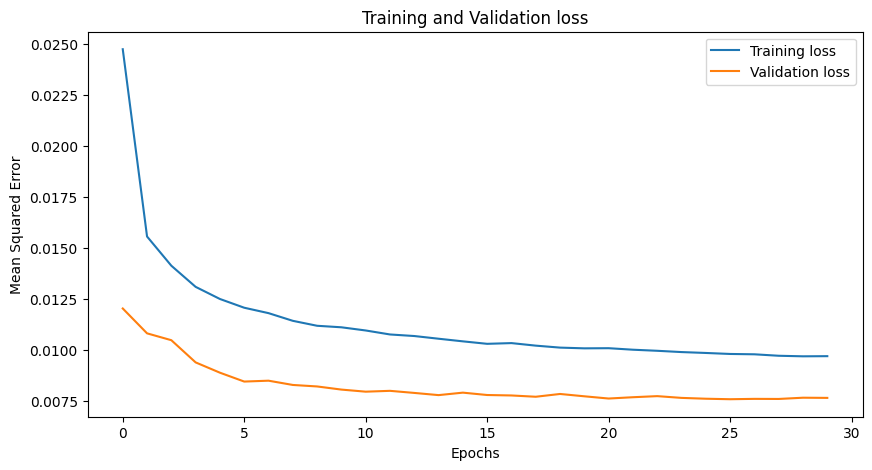

865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Train MAE: 0.500
Train MSE: 0.413
Train RMSE: 0.643
Train R² score: 0.520

Test MAE: 0.448
Test MSE: 0.316
Test RMSE: 0.562
Test R² score: 0.396


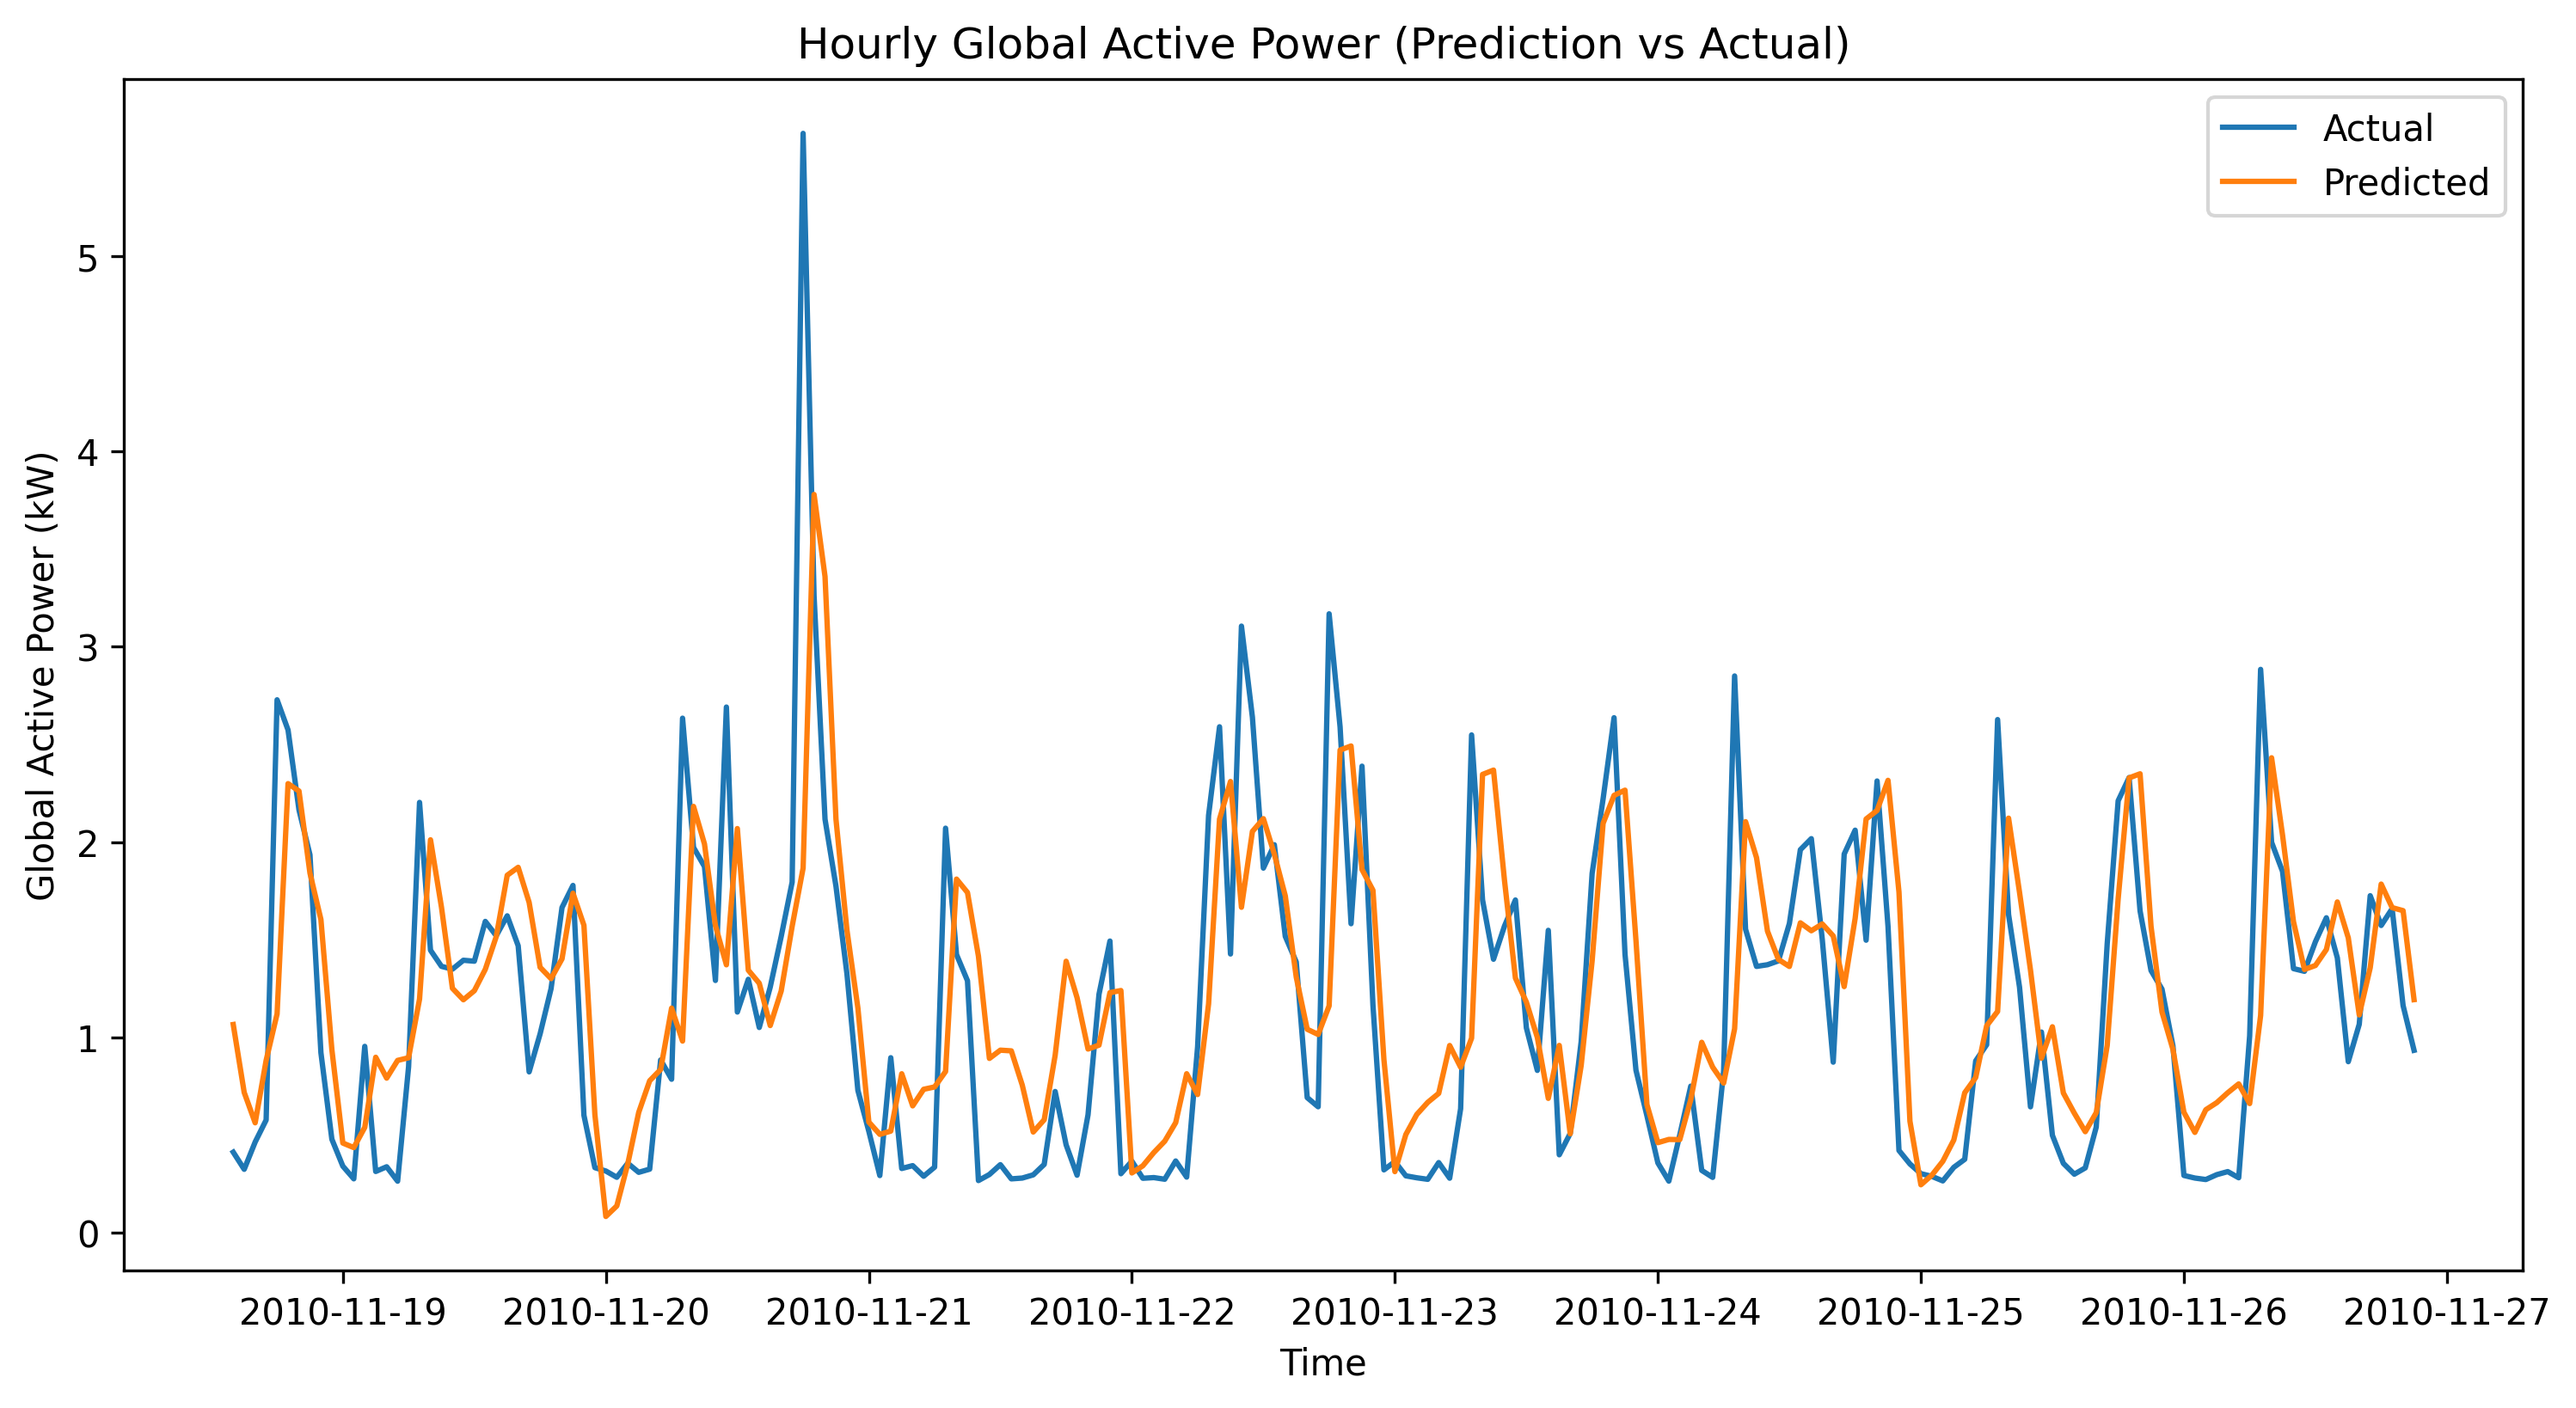

In [28]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-11 RMSProp(learning_rate=0.0001, epochs=50, batch_size=128)

Epoch 1/50
217/217 - 7s - 32ms/step - loss: 0.0287 - val_loss: 0.0114
Epoch 2/50
217/217 - 7s - 33ms/step - loss: 0.0180 - val_loss: 0.0103
Epoch 3/50
217/217 - 6s - 28ms/step - loss: 0.0160 - val_loss: 0.0099
Epoch 4/50
217/217 - 5s - 24ms/step - loss: 0.0149 - val_loss: 0.0092
Epoch 5/50
217/217 - 10s - 47ms/step - loss: 0.0141 - val_loss: 0.0089
Epoch 6/50
217/217 - 7s - 32ms/step - loss: 0.0135 - val_loss: 0.0085
Epoch 7/50
217/217 - 8s - 39ms/step - loss: 0.0130 - val_loss: 0.0083
Epoch 8/50
217/217 - 12s - 53ms/step - loss: 0.0127 - val_loss: 0.0082
Epoch 9/50
217/217 - 5s - 24ms/step - loss: 0.0122 - val_loss: 0.0081
Epoch 10/50
217/217 - 10s - 47ms/step - loss: 0.0121 - val_loss: 0.0079
Epoch 11/50
217/217 - 13s - 58ms/step - loss: 0.0118 - val_loss: 0.0079
Epoch 12/50
217/217 - 9s - 40ms/step - loss: 0.0117 - val_loss: 0.0078
Epoch 13/50
217/217 - 9s - 43ms/step - loss: 0.0115 - val_loss: 0.0077
Epoch 14/50
217/217 - 12s - 54ms/step - loss: 0.0114 - val_loss: 0.0078
Epoch 15/5

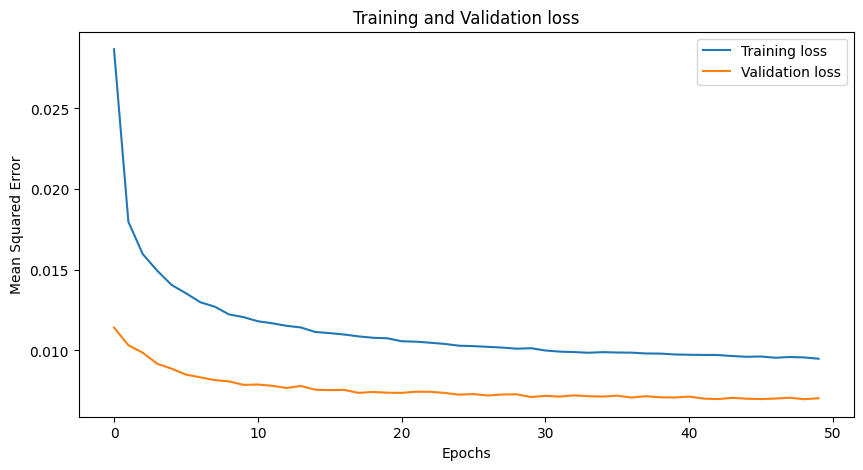

865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Train MAE: 0.472
Train MSE: 0.390
Train RMSE: 0.624
Train R² score: 0.547

Test MAE: 0.418
Test MSE: 0.291
Test RMSE: 0.540
Test R² score: 0.443


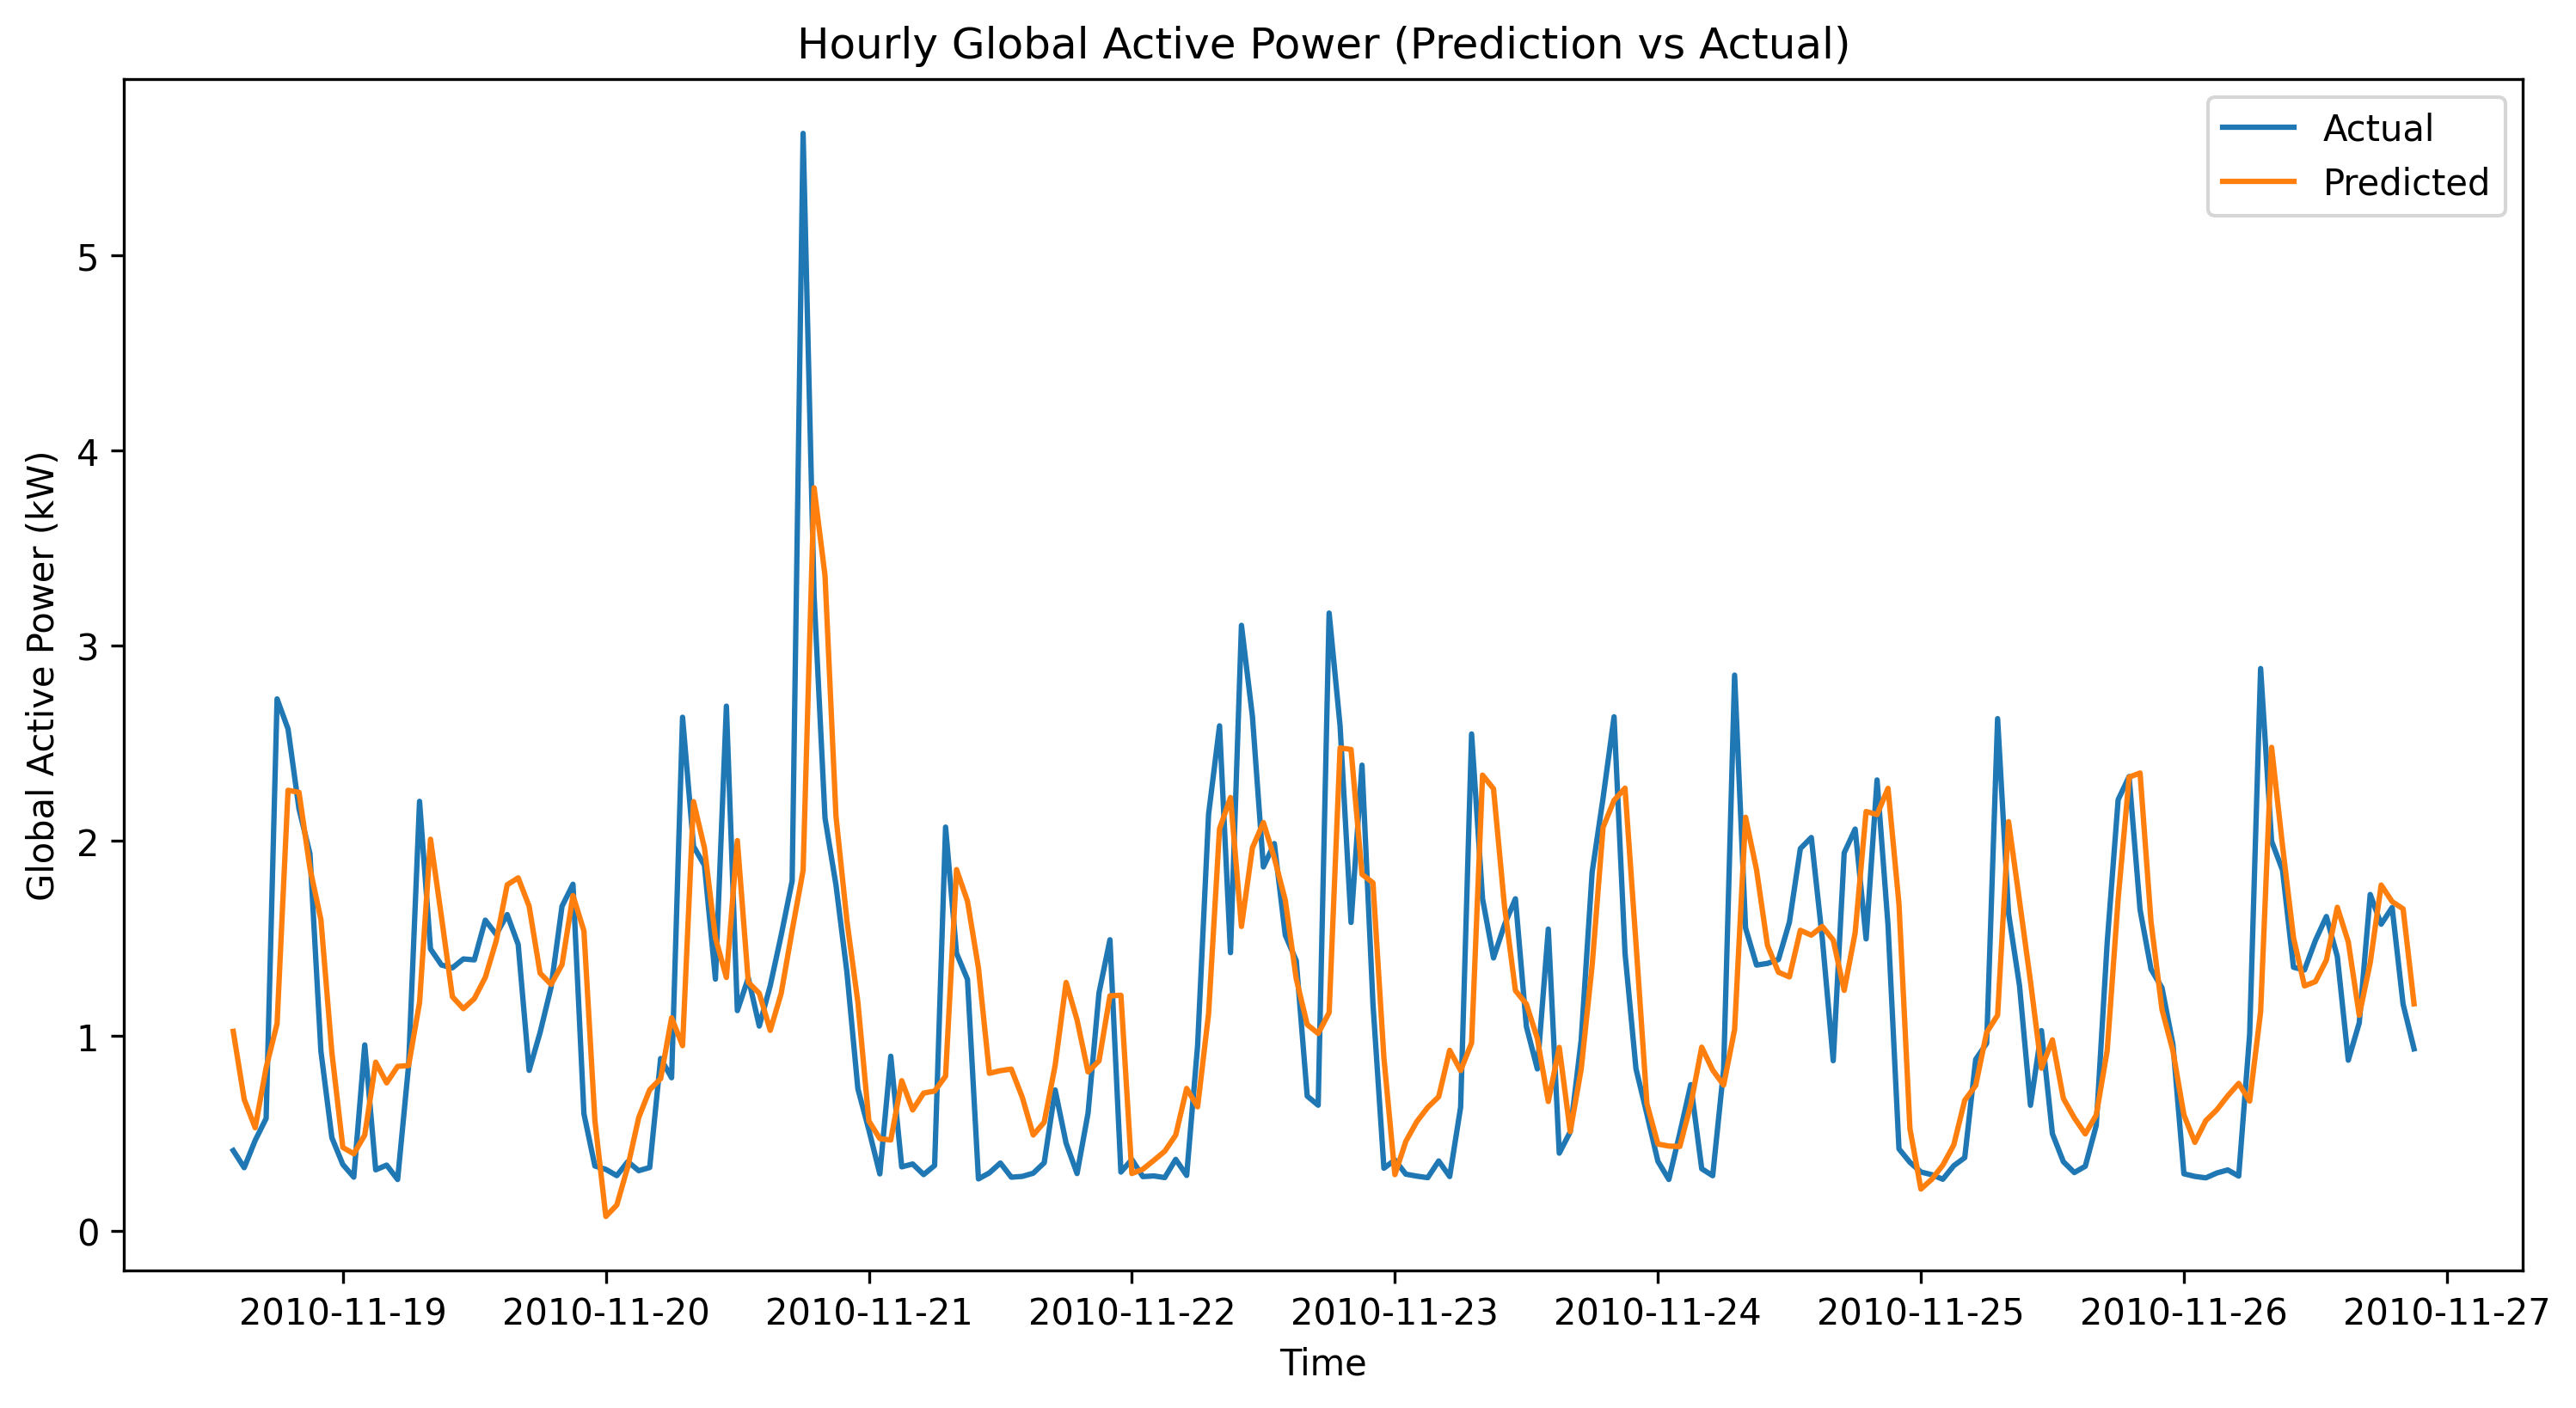

In [29]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-12 RMSProp(learning_rate=0.0001, epochs=100, batch_size=256)

Epoch 1/100
109/109 - 6s - 53ms/step - loss: 0.0300 - val_loss: 0.0118
Epoch 2/100
109/109 - 7s - 66ms/step - loss: 0.0195 - val_loss: 0.0105
Epoch 3/100
109/109 - 8s - 72ms/step - loss: 0.0176 - val_loss: 0.0099
Epoch 4/100
109/109 - 7s - 63ms/step - loss: 0.0165 - val_loss: 0.0095
Epoch 5/100
109/109 - 9s - 78ms/step - loss: 0.0158 - val_loss: 0.0093
Epoch 6/100
109/109 - 7s - 63ms/step - loss: 0.0152 - val_loss: 0.0090
Epoch 7/100
109/109 - 8s - 77ms/step - loss: 0.0147 - val_loss: 0.0088
Epoch 8/100
109/109 - 6s - 53ms/step - loss: 0.0143 - val_loss: 0.0087
Epoch 9/100
109/109 - 9s - 79ms/step - loss: 0.0138 - val_loss: 0.0086
Epoch 10/100
109/109 - 7s - 67ms/step - loss: 0.0136 - val_loss: 0.0084
Epoch 11/100
109/109 - 4s - 41ms/step - loss: 0.0133 - val_loss: 0.0083
Epoch 12/100
109/109 - 5s - 44ms/step - loss: 0.0130 - val_loss: 0.0082
Epoch 13/100
109/109 - 8s - 77ms/step - loss: 0.0128 - val_loss: 0.0080
Epoch 14/100
109/109 - 7s - 65ms/step - loss: 0.0126 - val_loss: 0.0079
E

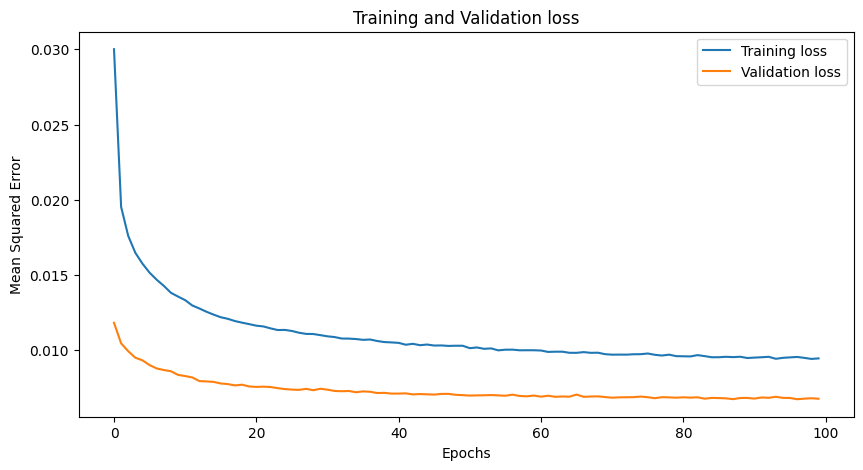

865/865 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Train MAE: 0.457
Train MSE: 0.381
Train RMSE: 0.617
Train R² score: 0.557

Test MAE: 0.402
Test MSE: 0.281
Test RMSE: 0.530
Test R² score: 0.463


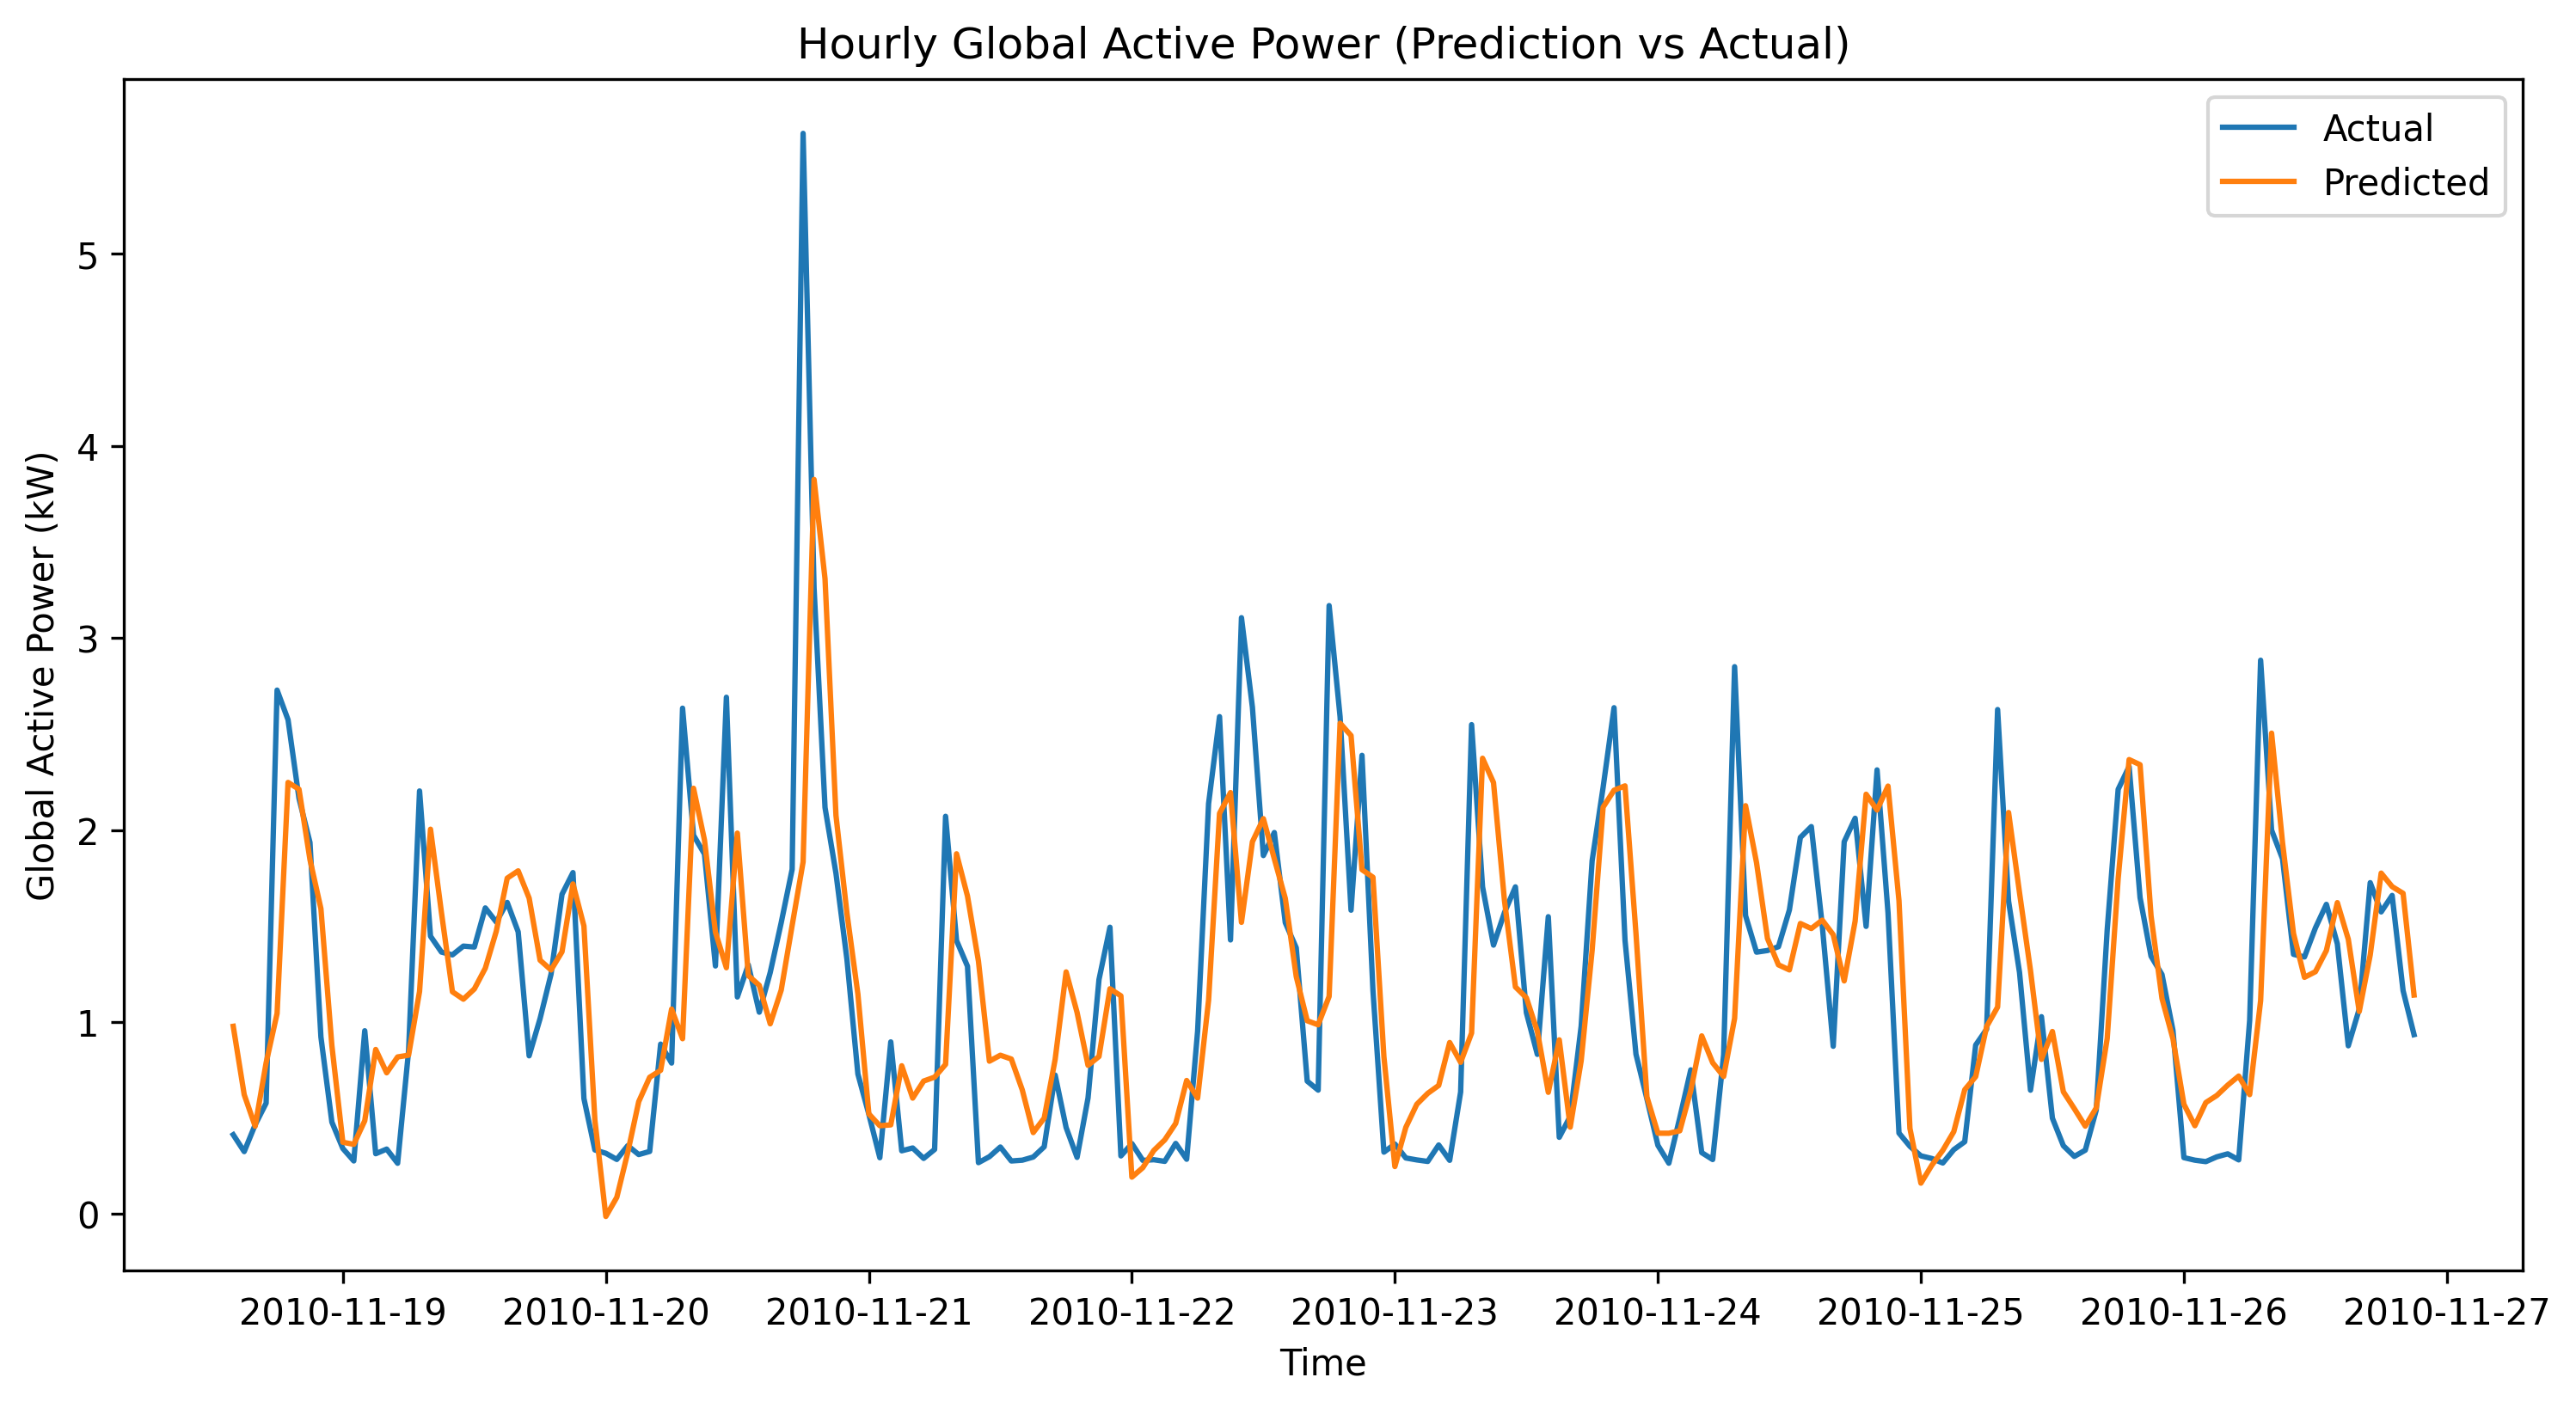

In [30]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=256, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# LSTM model-12 RMSProp(learning_rate=0.0001, epochs=200, batch_size=512)

Epoch 1/200
55/55 - 15s - 266ms/step - loss: 0.0425 - val_loss: 0.0114
Epoch 2/200
55/55 - 10s - 188ms/step - loss: 0.0226 - val_loss: 0.0108
Epoch 3/200
55/55 - 5s - 92ms/step - loss: 0.0206 - val_loss: 0.0104
Epoch 4/200
55/55 - 5s - 86ms/step - loss: 0.0194 - val_loss: 0.0100
Epoch 5/200
55/55 - 7s - 129ms/step - loss: 0.0182 - val_loss: 0.0097
Epoch 6/200
55/55 - 8s - 148ms/step - loss: 0.0173 - val_loss: 0.0095
Epoch 7/200
55/55 - 6s - 104ms/step - loss: 0.0167 - val_loss: 0.0092
Epoch 8/200
55/55 - 8s - 150ms/step - loss: 0.0162 - val_loss: 0.0091
Epoch 9/200
55/55 - 4s - 66ms/step - loss: 0.0158 - val_loss: 0.0089
Epoch 10/200
55/55 - 6s - 105ms/step - loss: 0.0155 - val_loss: 0.0088
Epoch 11/200
55/55 - 8s - 141ms/step - loss: 0.0150 - val_loss: 0.0087
Epoch 12/200
55/55 - 7s - 126ms/step - loss: 0.0148 - val_loss: 0.0086
Epoch 13/200
55/55 - 8s - 153ms/step - loss: 0.0145 - val_loss: 0.0085
Epoch 14/200
55/55 - 4s - 68ms/step - loss: 0.0144 - val_loss: 0.0084
Epoch 15/200
55/5

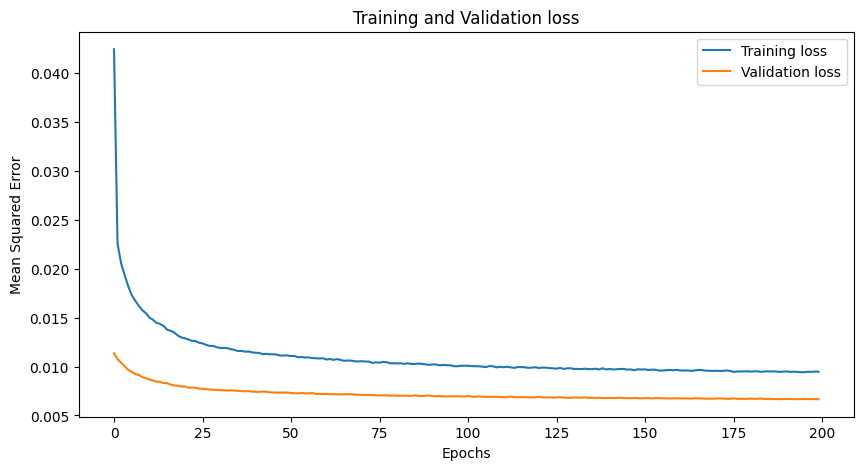

865/865 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Train MAE: 0.444
Train MSE: 0.376
Train RMSE: 0.613
Train R² score: 0.563

Test MAE: 0.387
Test MSE: 0.276
Test RMSE: 0.525
Test R² score: 0.473


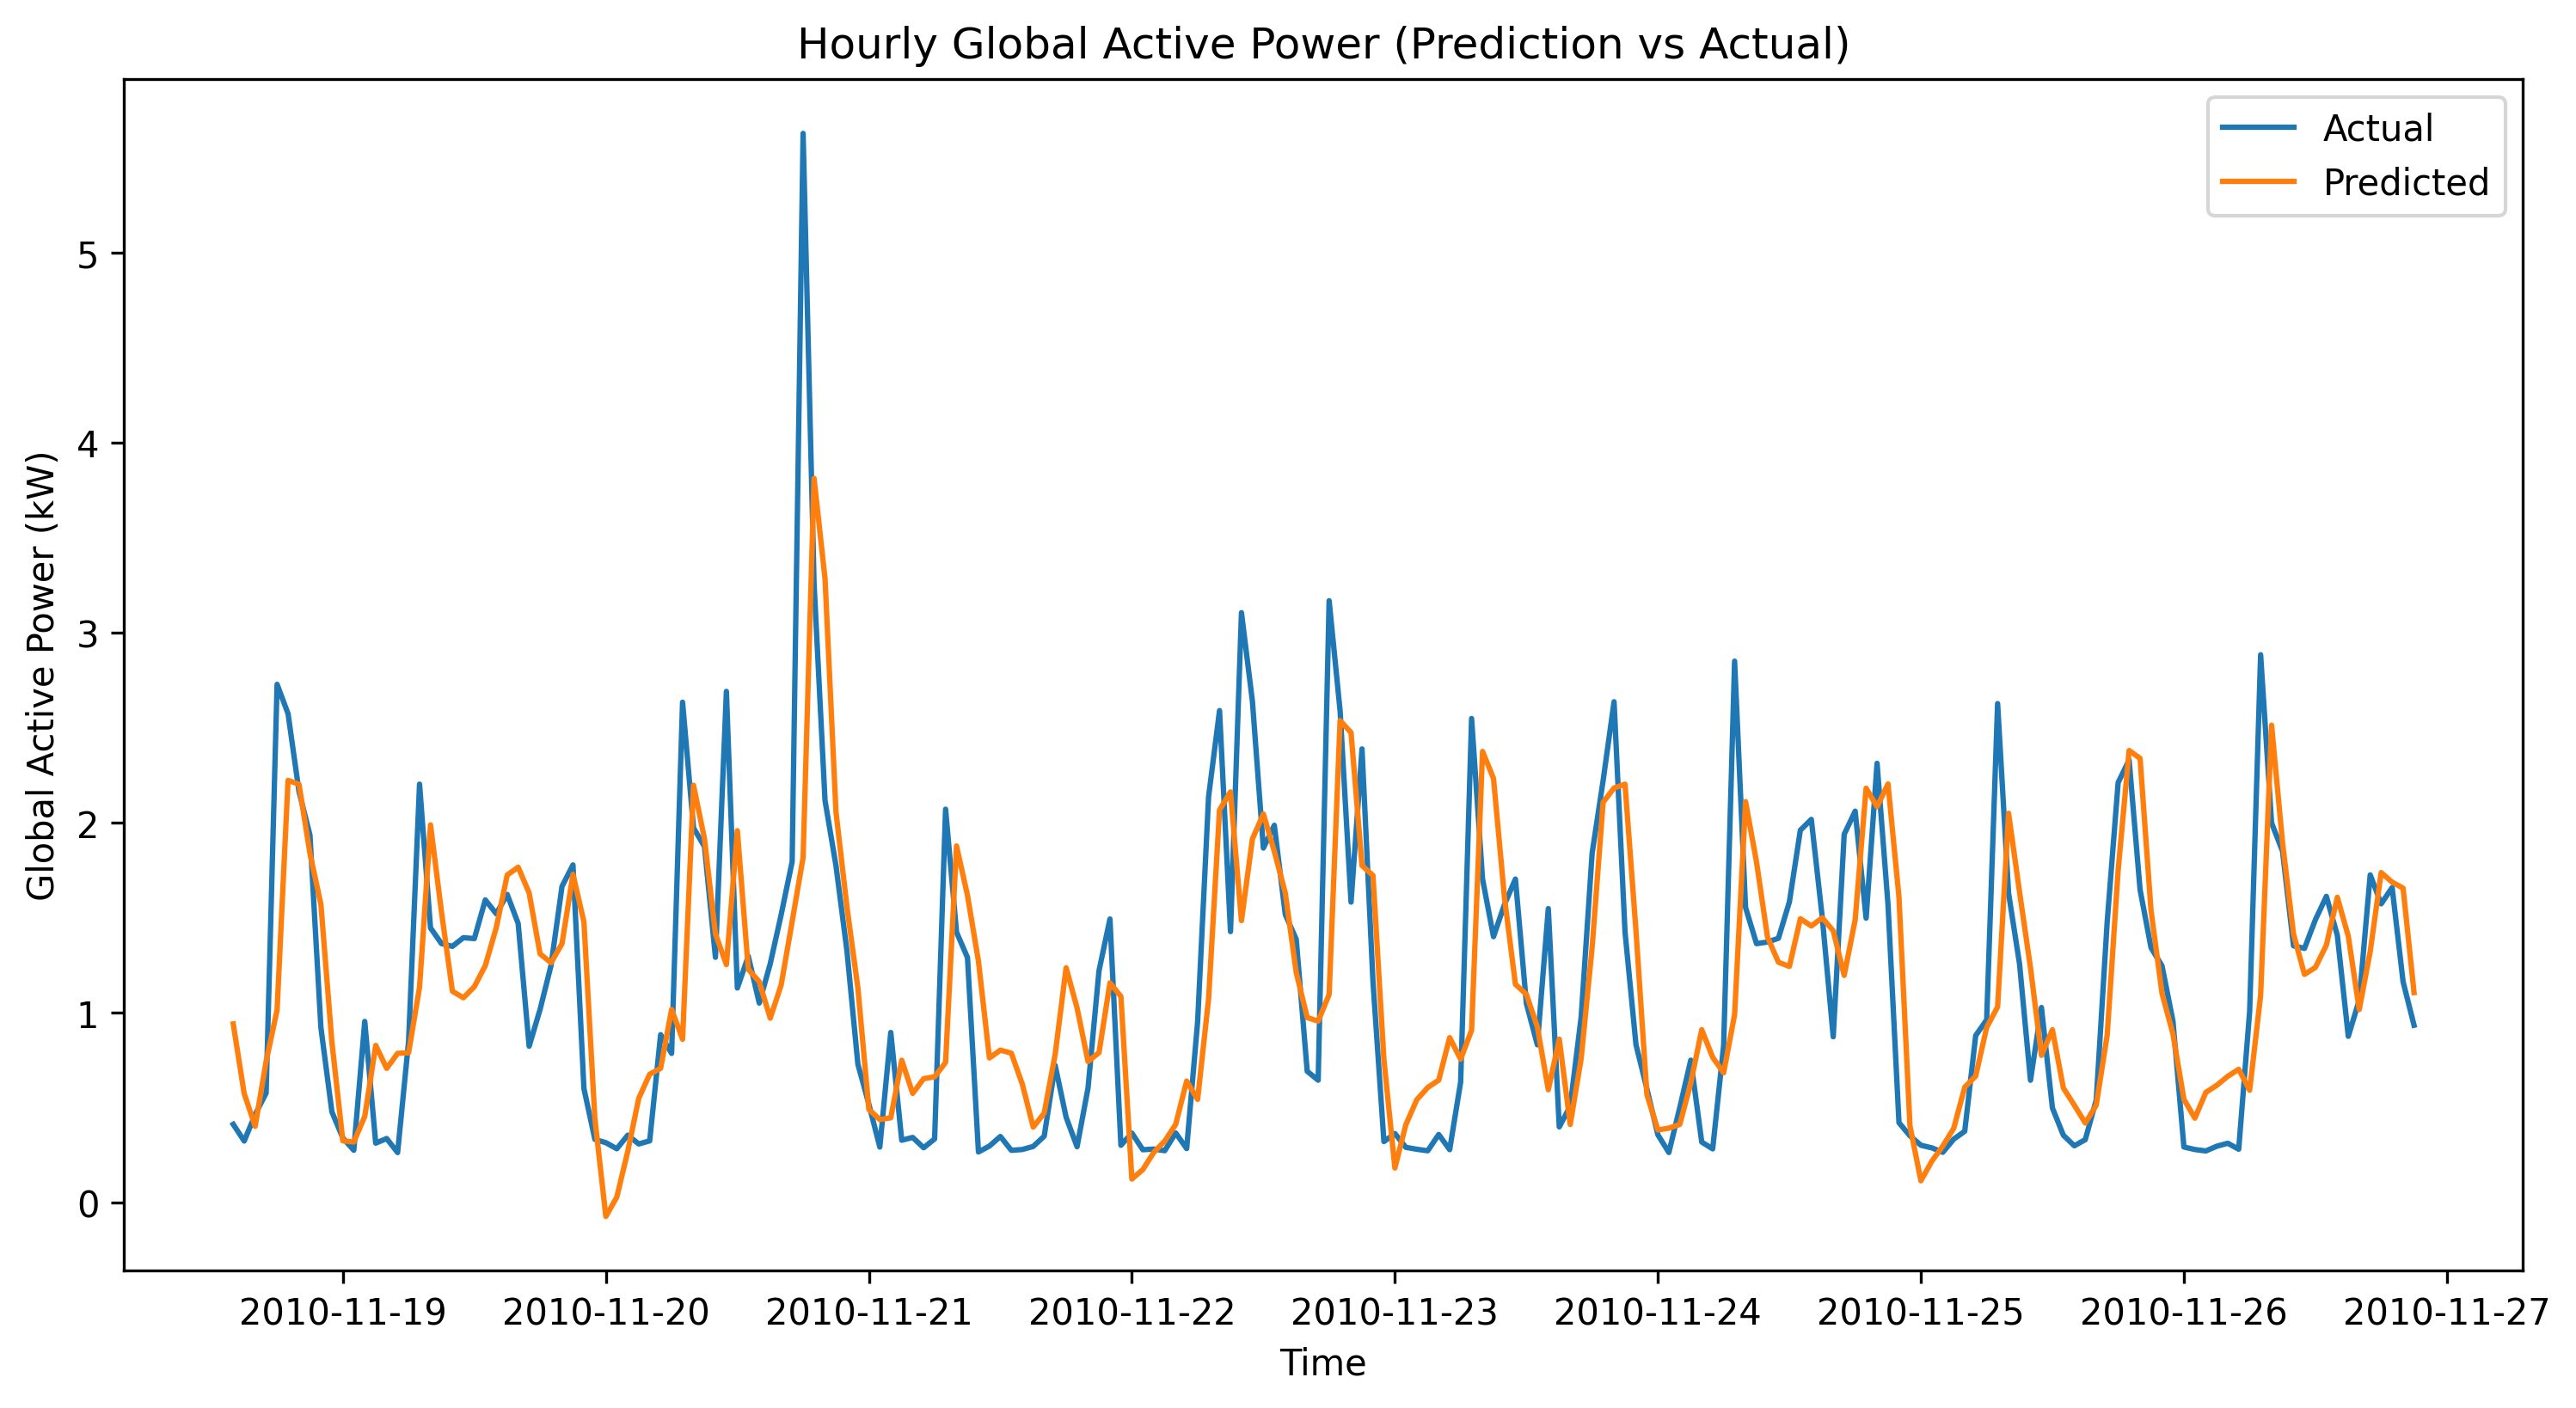

In [31]:
# Define sequence length and features
sequence_length = 12             # Number of time steps to consider in each sequence
num_features = len(df1.columns)  # Number of features

# Create sequences and corresponding labels
sequences = []
labels = []
for i in range(len(scaled_df) - sequence_length):
    seq = scaled_df[i:i+sequence_length]
    label = scaled_df[i+sequence_length][0]  # 'Global_Active_Power' column index
    sequences.append(seq)
    labels.append(label)

# Convert to numpy arrays
sequences = np.array(sequences)
labels = np.array(labels)

# Split into train and test sets
train_size = int(0.8 * len(sequences))
X_train, X_test = sequences[:train_size], sequences[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Check the shape of Train & Test Split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# LSTM model
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='mean_squared_error')

# Fit the model
history = model.fit(X_train, y_train, epochs=200, batch_size=512, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# Plot the training and validation loss (MSE)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

# Predict train and test data using the trained model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Perform inverse transformation to rescale back to original range
# y_true values for train data
y_train_copies = np.repeat(y_train.reshape(-1, 1), X_train.shape[-1], axis=-1)
true_y_train = scaler.inverse_transform(y_train_copies)[:,0]

# predicted values for train data
train_prediction_copies = np.repeat(train_predict, df1.shape[1], axis=-1)
pred_y_train = scaler.inverse_transform(train_prediction_copies)[:,0]

# y_true values for test data
y_test_copies = np.repeat(y_test.reshape(-1, 1), X_test.shape[-1], axis=-1)
true_y_test = scaler.inverse_transform(y_test_copies)[:,0]

# predicted values for test data
test_prediction_copies = np.repeat(test_predict, df1.shape[1], axis=-1)
pred_y_test = scaler.inverse_transform(test_prediction_copies)[:,0]

# Calculate evaluation metrics
print(f'\nTrain MAE: {mean_absolute_error(true_y_train, pred_y_train):.3f}')
print(f'Train MSE: {mean_squared_error(true_y_train, pred_y_train):.3f}')
print(f'Train RMSE: {np.sqrt(mean_squared_error(true_y_train, pred_y_train)):.3f}')
print(f'Train R² score: {r2_score(true_y_train, pred_y_train):.3f}')

print(f'\nTest MAE: {mean_absolute_error(true_y_test, pred_y_test):.3f}')
print(f'Test MSE: {mean_squared_error(true_y_test, pred_y_test):.3f}')
print(f'Test RMSE: {np.sqrt(mean_squared_error(true_y_test, pred_y_test)):.3f}')
print(f'Test R² score: {r2_score(true_y_test, pred_y_test):.3f}')

# Plotting Hourly Global Active Power (Prediction vs Actual)
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df1.index[-200:], true_y_test[-200:], label='Actual')
plt.plot(df1.index[-200:], pred_y_test[-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()